In [1]:
from pandas_datareader import data as pdr
import yfinance as yf
import ta
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import missingno as msno 
import seaborn as sns
from  functions import *

# Load Sentiment data from local file 

In [2]:
sentiment_score = pd.read_csv('data/Sentiment_score.csv',index_col=0)

sentiment_score['Date'] = pd.to_datetime(sentiment_score['Date'])
sentiment_score=sentiment_score.rename(columns={
    'Value': 'sentiment_score'})

In [3]:
sentiment_score.head()

sentiment_score       Date
0           0.1250 2017-03-02
1          -0.0090 2017-03-03
2          -0.3832 2017-03-04
3           0.1771 2017-03-05
4          -0.1986 2017-03-06

In [4]:
sentiment_score.tail()

sentiment_score       Date
2459          -0.2926 2023-11-25
2460          -0.3004 2023-11-26
2461          -0.1801 2023-11-27
2462           0.1895 2023-11-28
2463          -0.1800 2023-11-29

# Fetch Data (btc, gold, oil, s&p500) & merge with sentiment data

In [5]:
start    =sentiment_score.Date.min()
end      =sentiment_score.Date.max()

# Bitcoin data
data_btc = fetch_data('BTC-USD', start, end)
data_btc = data_btc.rename(columns=lambda x: x + '_btc')

# Gold data
data_gold = fetch_data('GC=F', start, end)
data_gold = data_gold.rename(columns=lambda x: x + '_gold')

# Oil data
data_oil = fetch_data('CL=F', start, end)
data_oil = data_oil.rename(columns=lambda x: x + '_oil')

#SP500 Data

data_sp500 = fetch_data('^GSPC', start, end)
data_sp500 = data_sp500.rename(columns=lambda x: x + '_sp500')

# Merging datasets
data = pd.merge(data_btc.reset_index(), data_gold.reset_index(), on='Date', how='left')
data = pd.merge(data, data_oil.reset_index(), on='Date', how='left')
data = pd.merge(data, data_sp500.reset_index(), on='Date', how='left')
data = pd.merge(data, sentiment_score.reset_index(), on='Date', how='left')

data = data.set_index('index')


#data.to_csv('data/btc_gold_oil_sp500_sentiment.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# investigate missing values and impute with ffill

<Axes: >

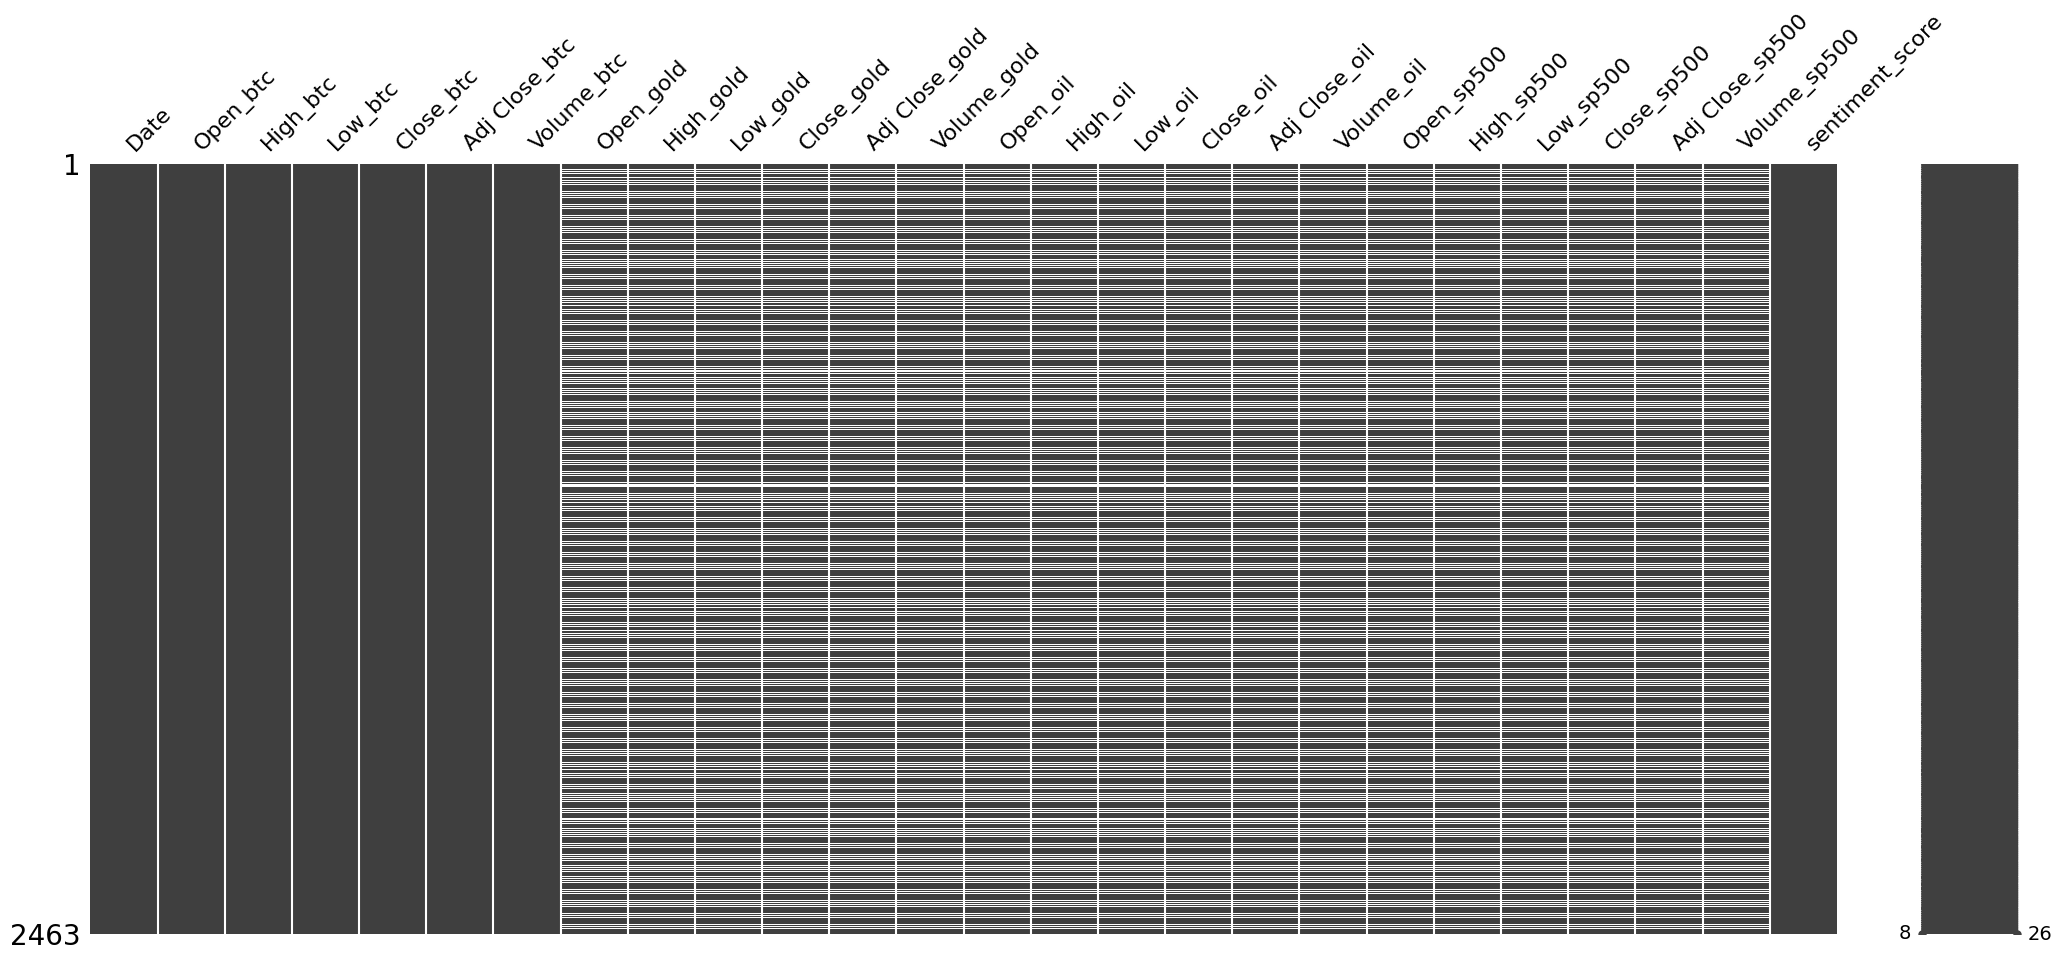

In [6]:
msno.matrix(data)

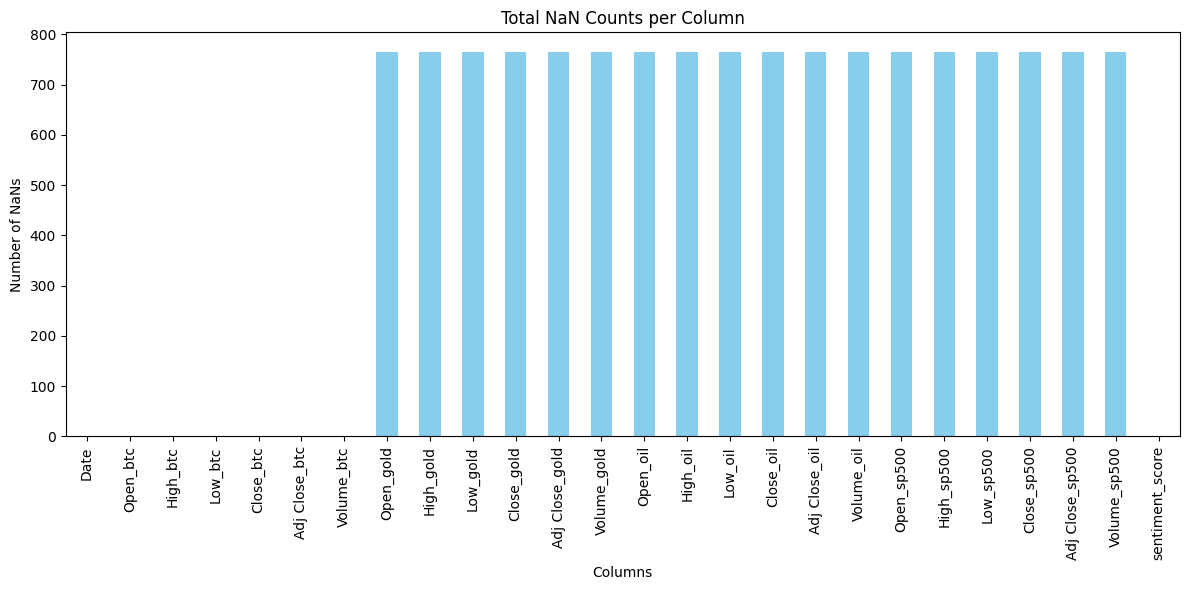

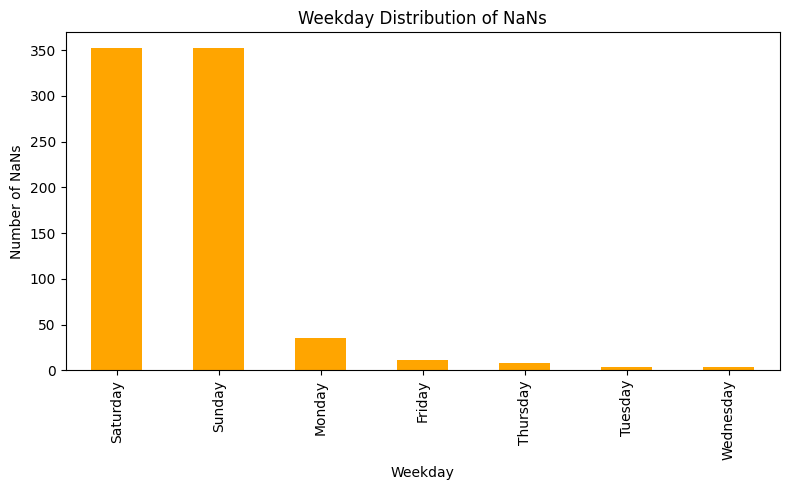

In [7]:
nan_counts, nan_weekday_counts = visualize_nans(data, date_column='Date')


In [8]:
# make forwardfill

data_aug = data.ffill()

<Axes: >

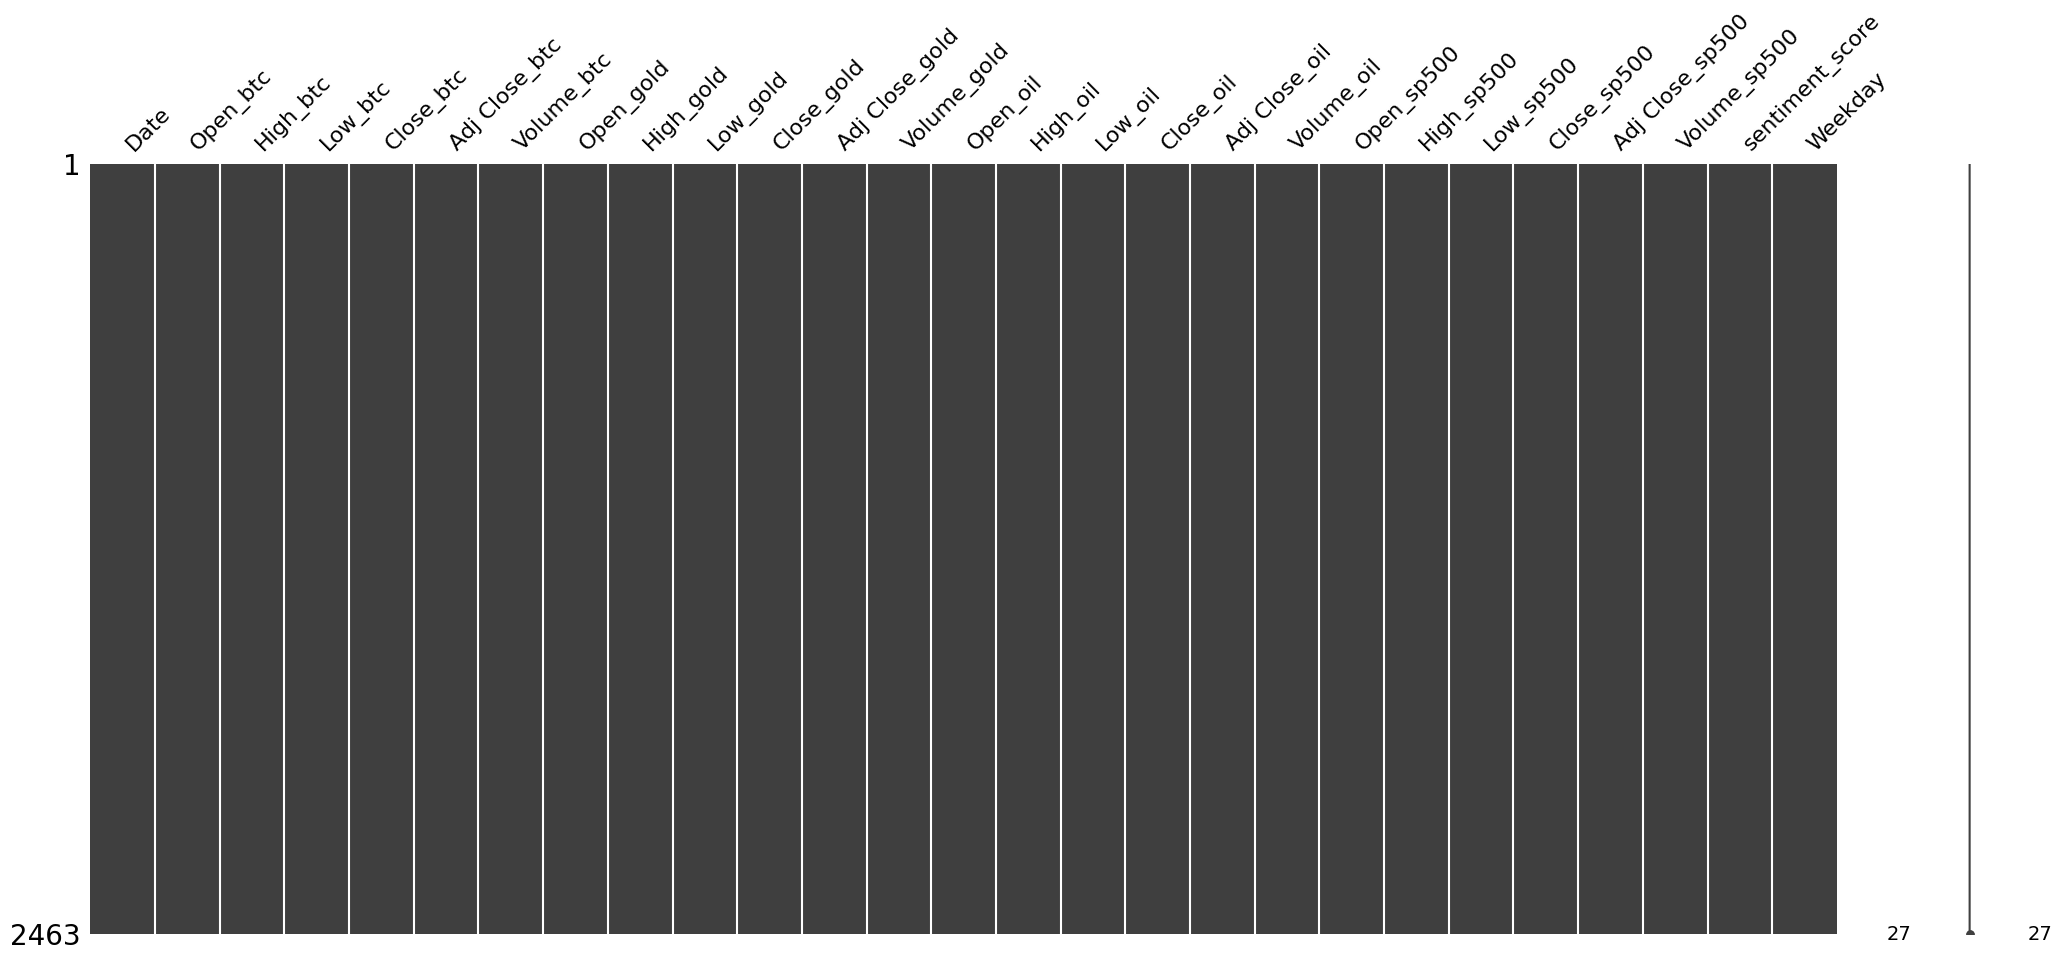

In [9]:
msno.matrix(data_aug)

In [10]:
data_aug.to_csv('data/btc_gold_oil_sp500_sentiment_clean.csv')

# Feature Enigneering 

In [11]:
%run functions.py

## make target column


In [12]:
target   = 'target_class' 
target2   = 'target_value' 
variable = 'Close_btc'

In [13]:
data_aug = add_target_column(data_aug,target,target2,variable)


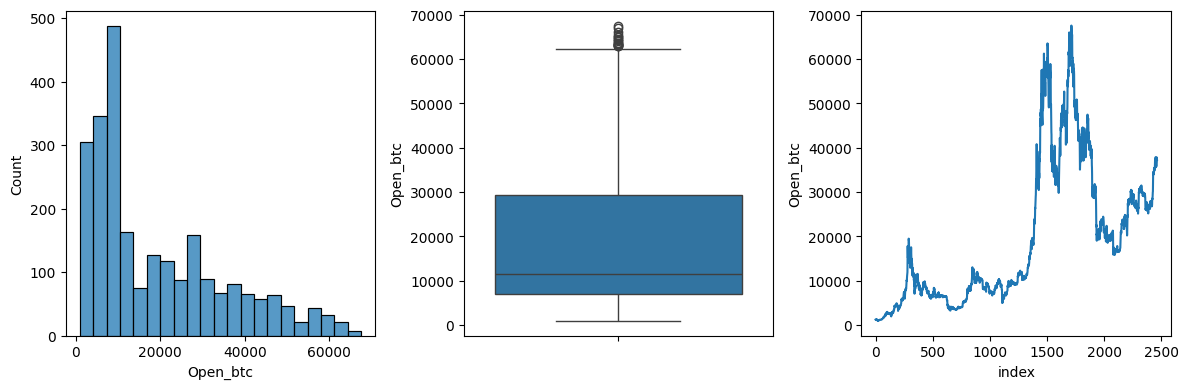

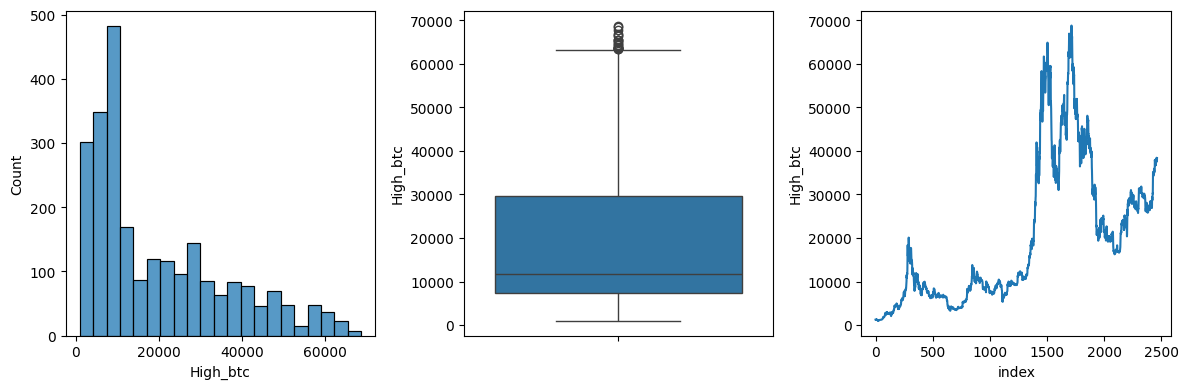

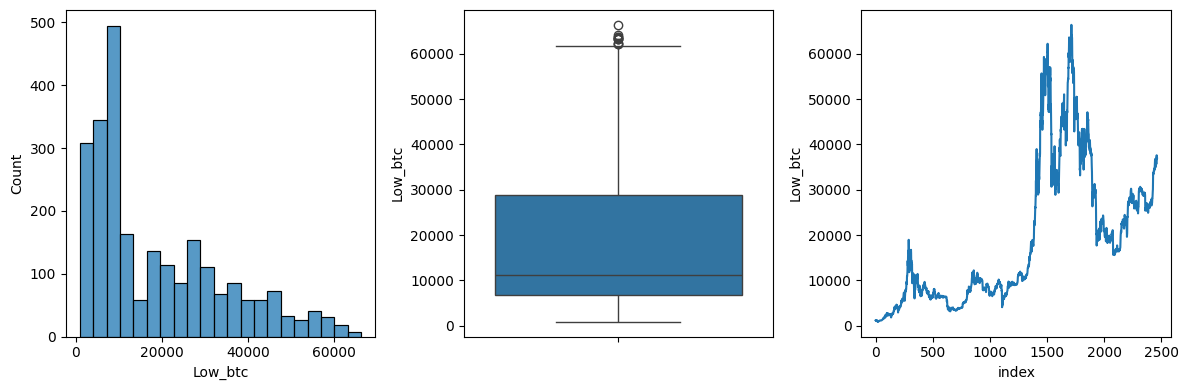

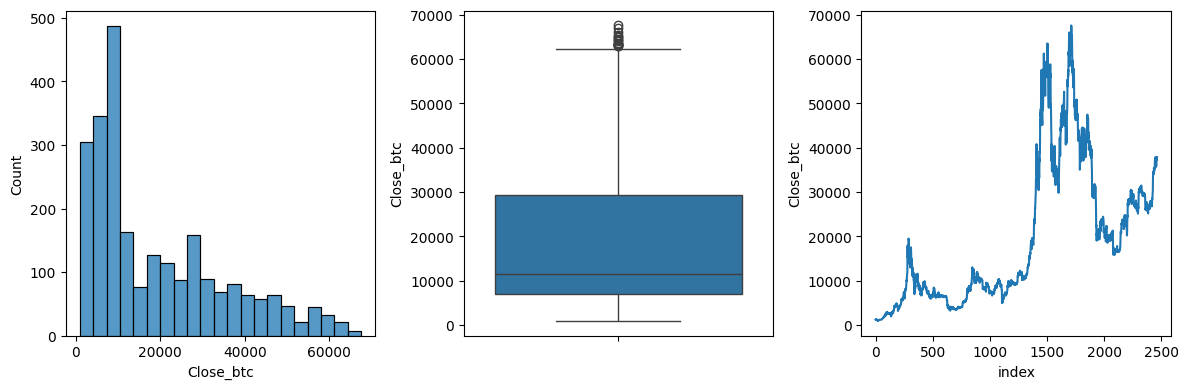

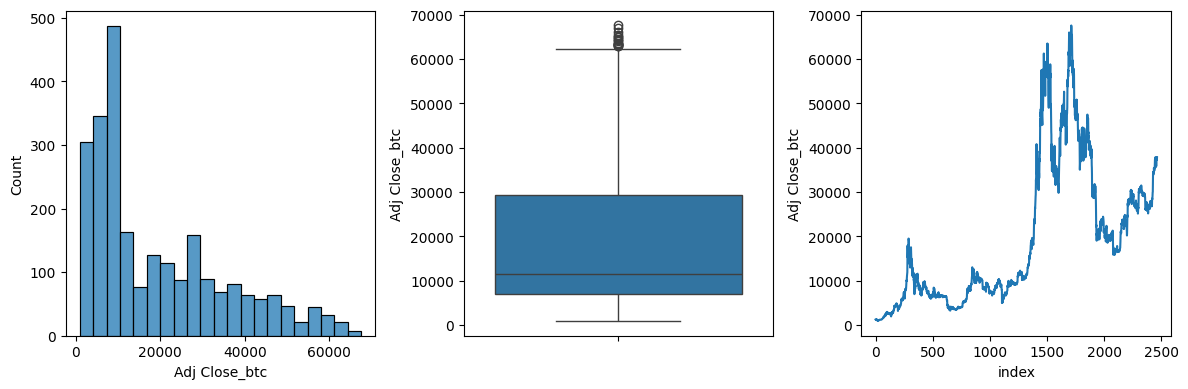

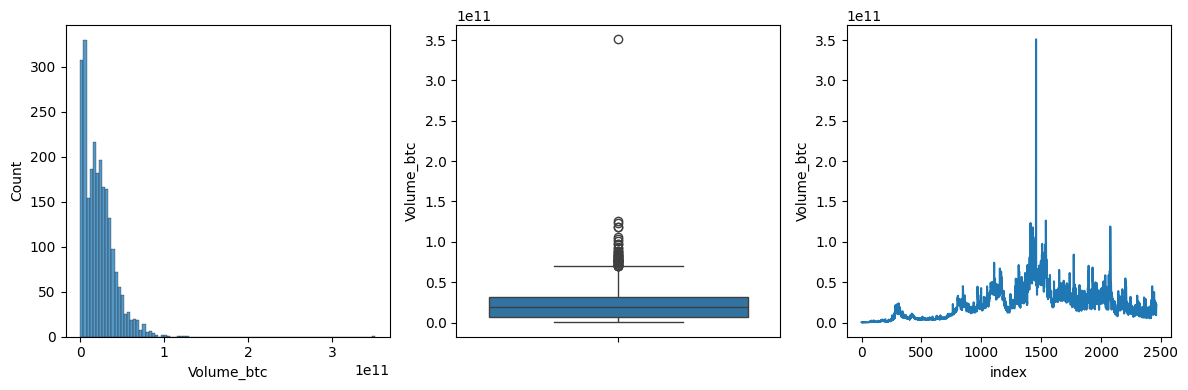

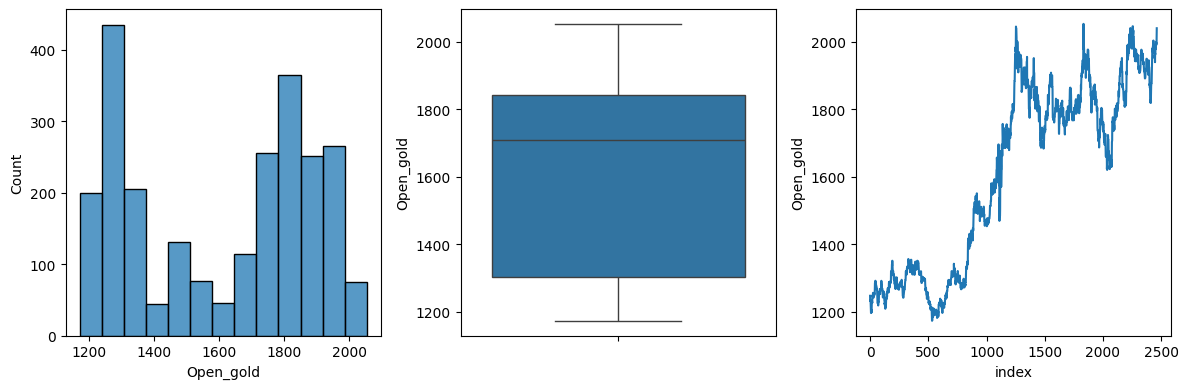

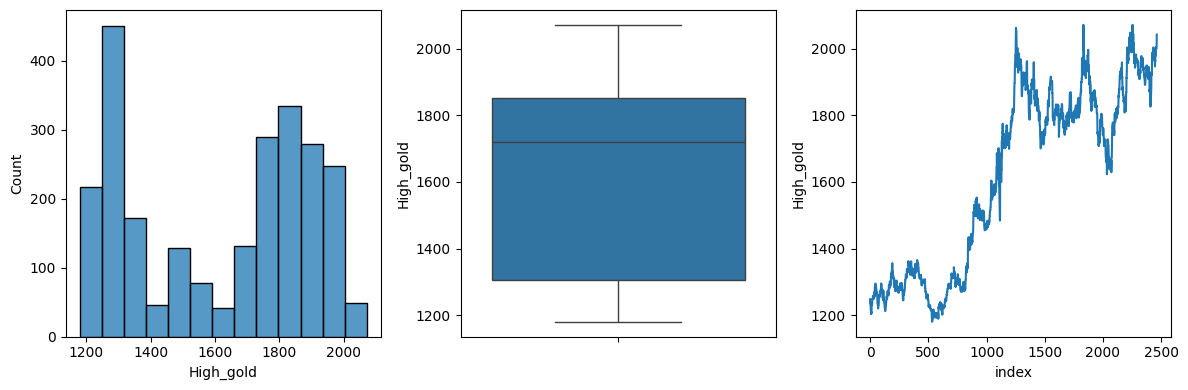

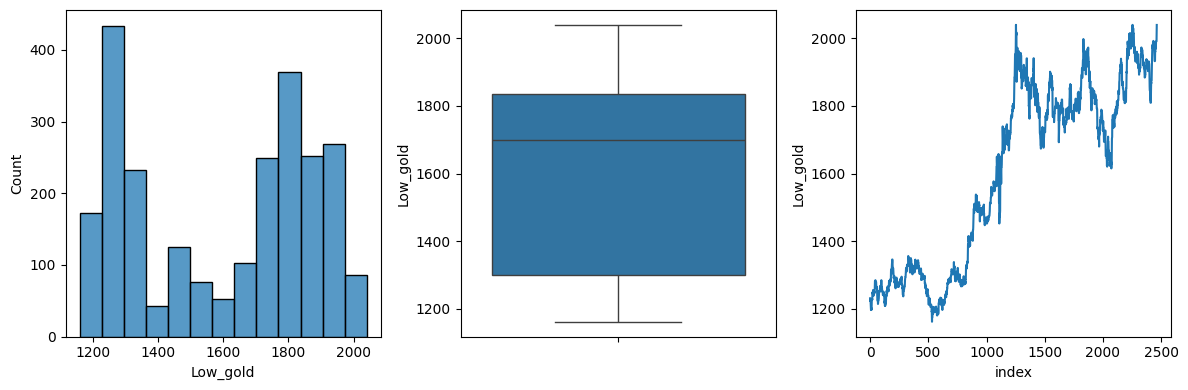

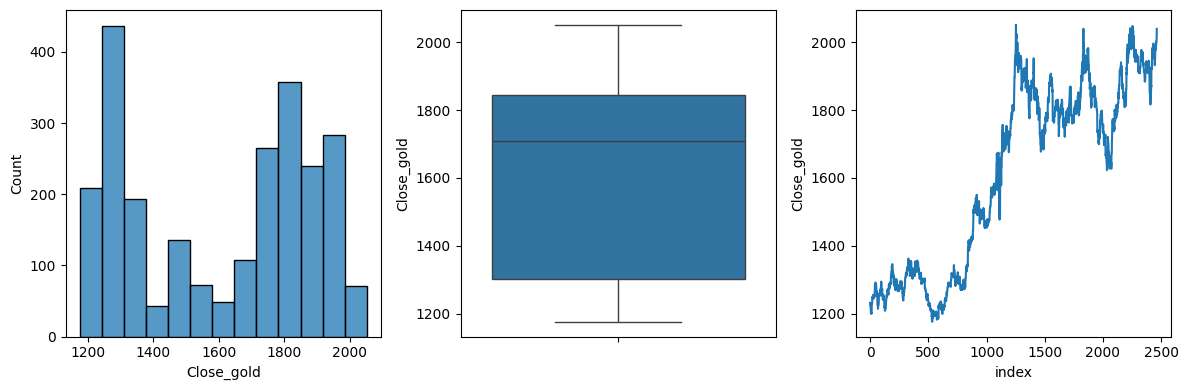

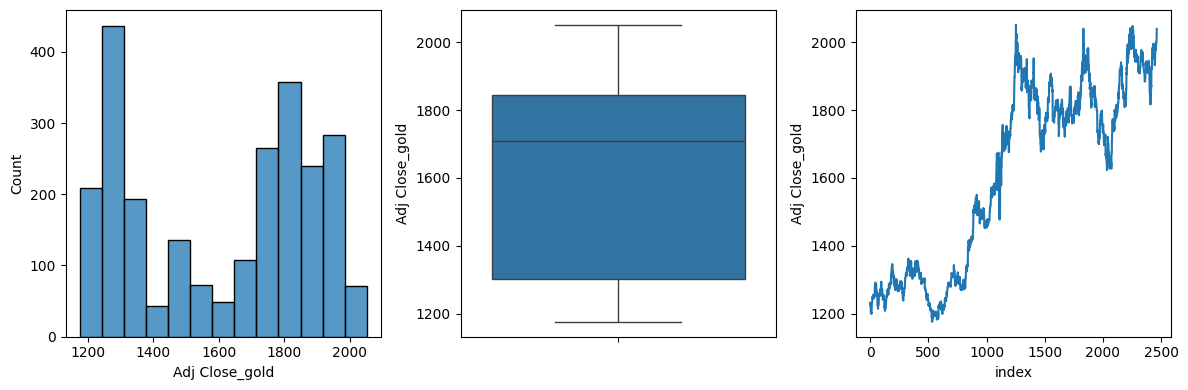

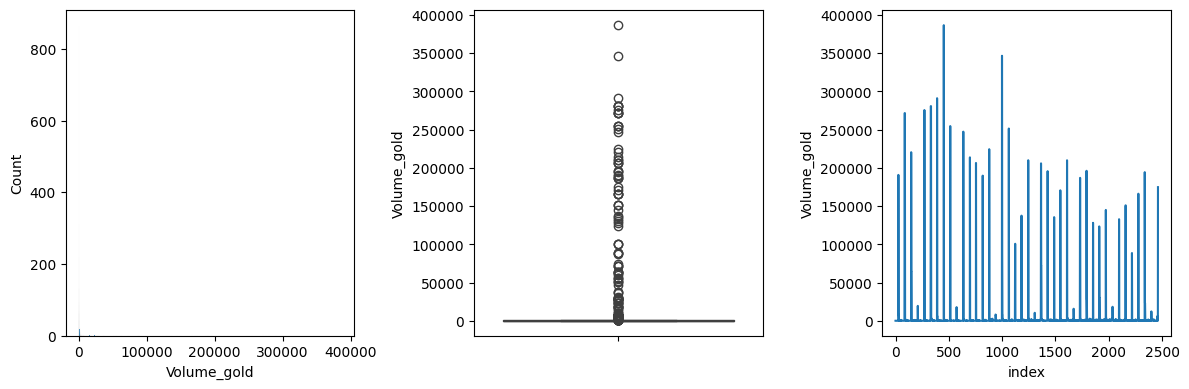

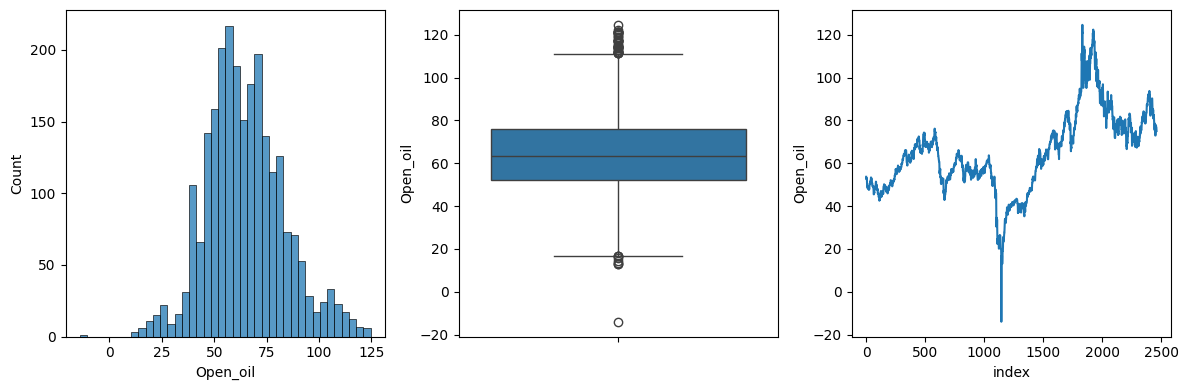

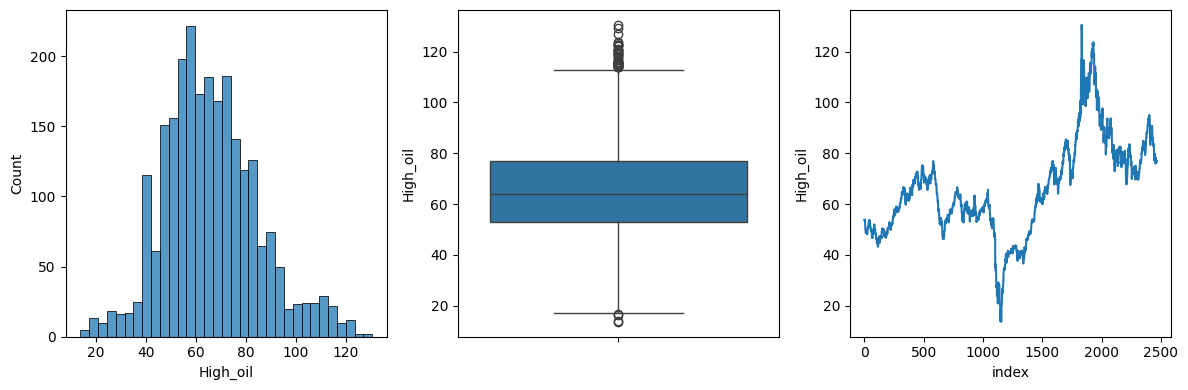

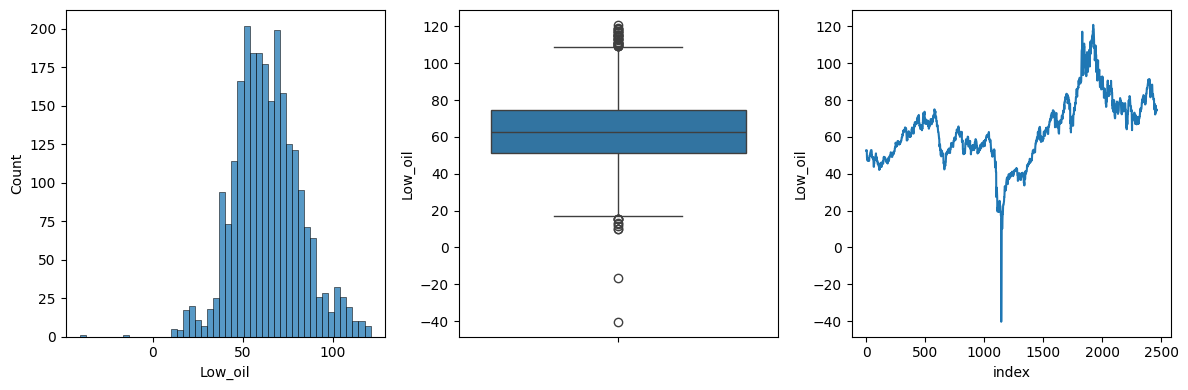

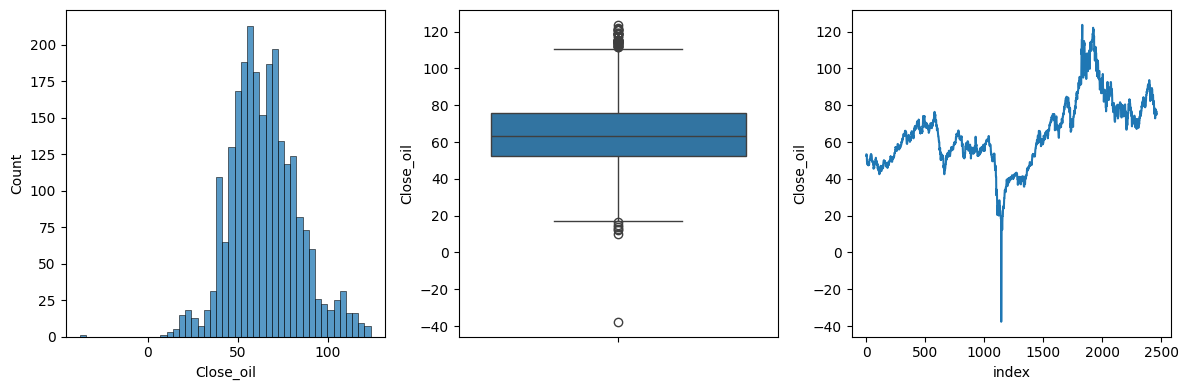

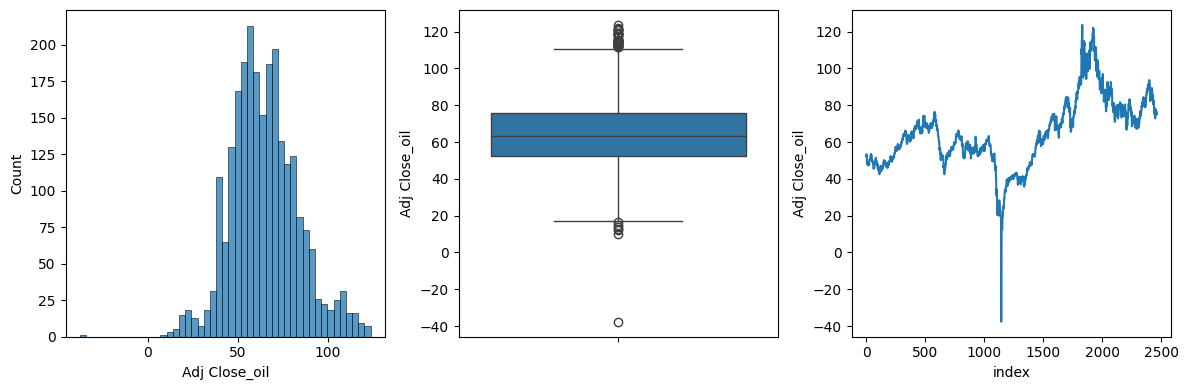

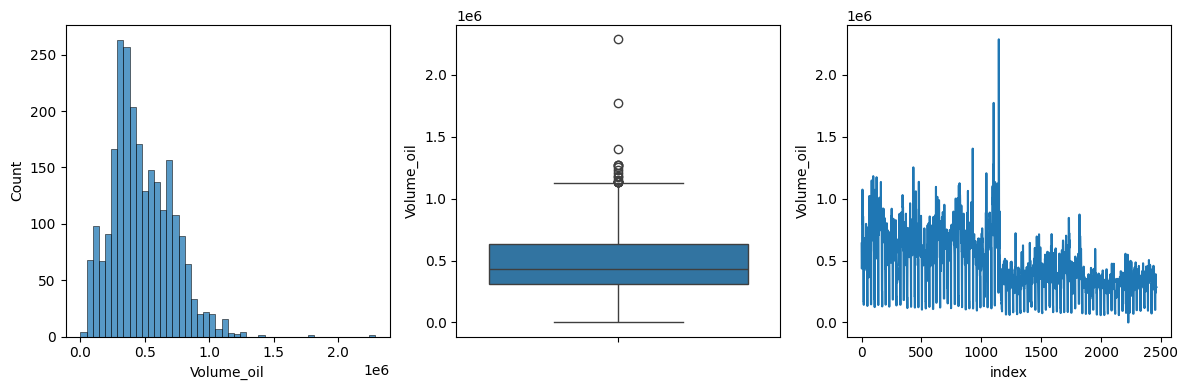

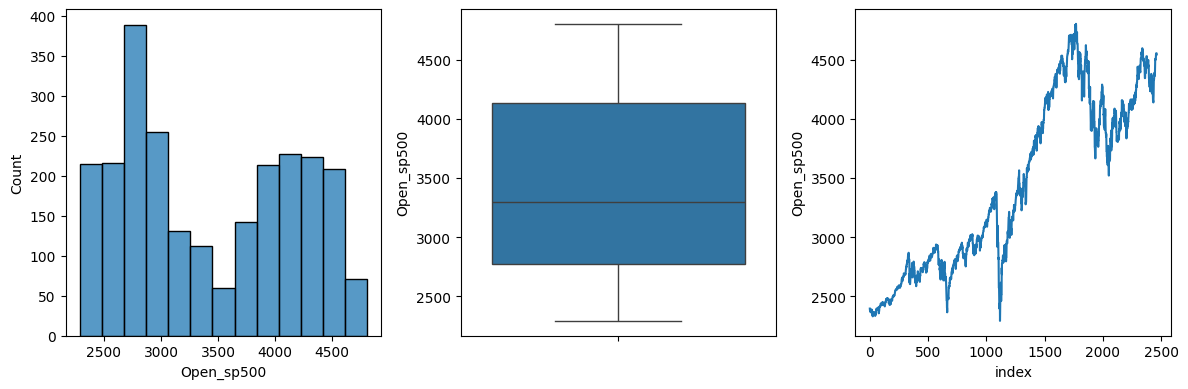

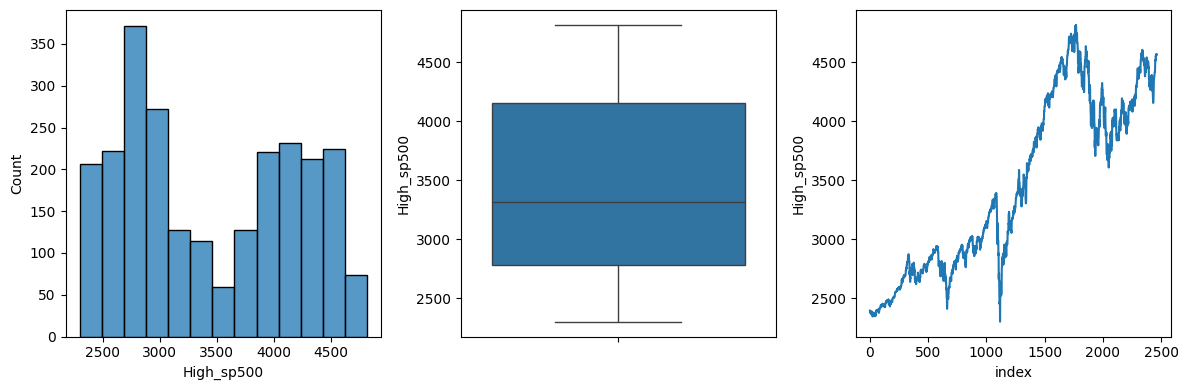

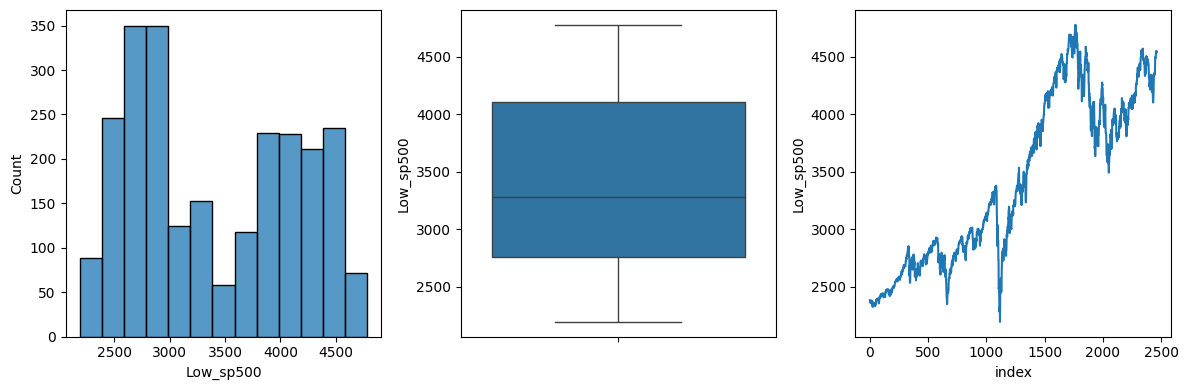

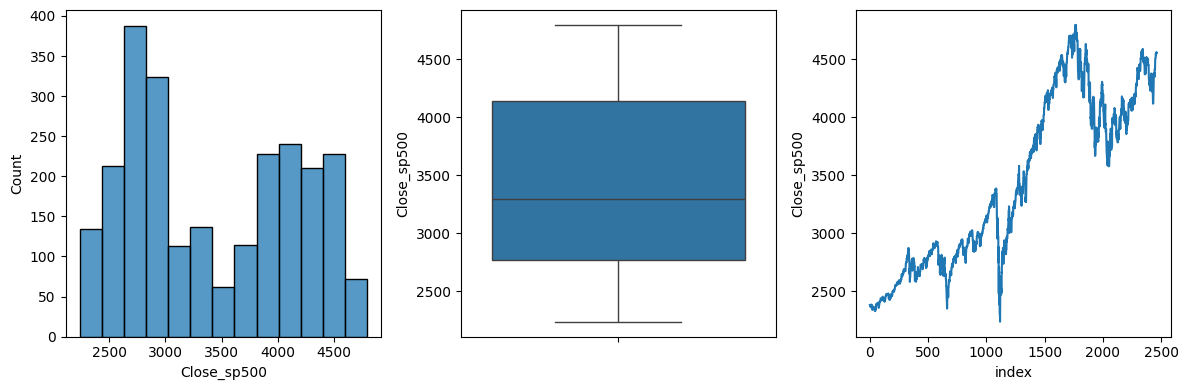

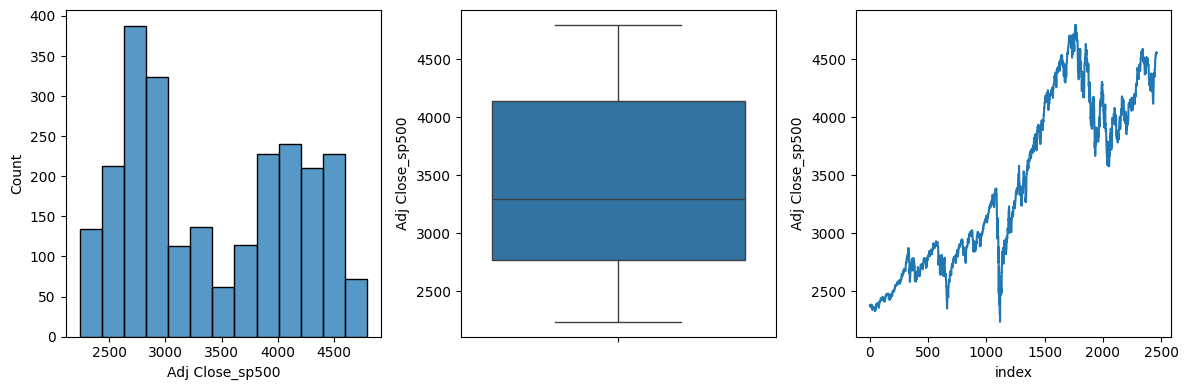

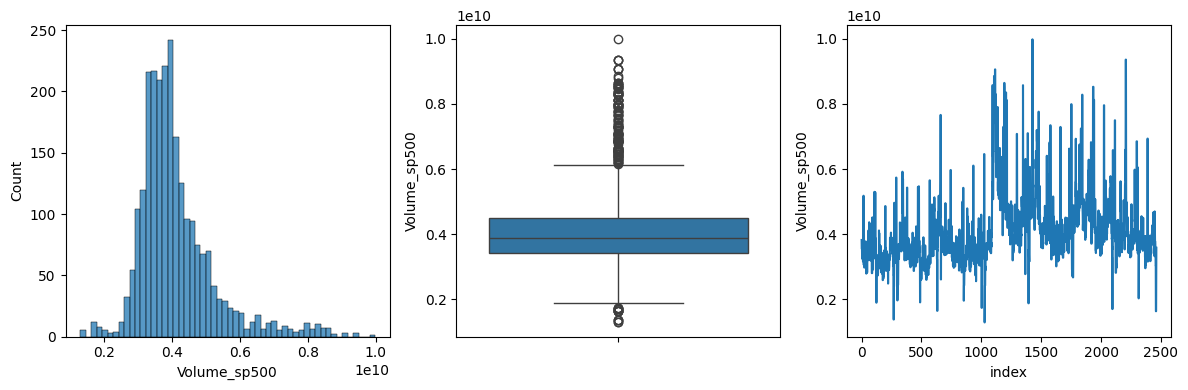

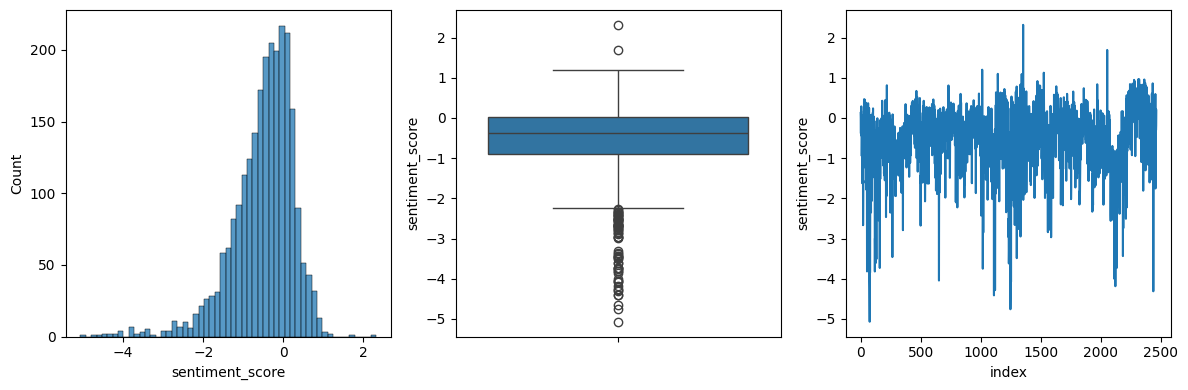

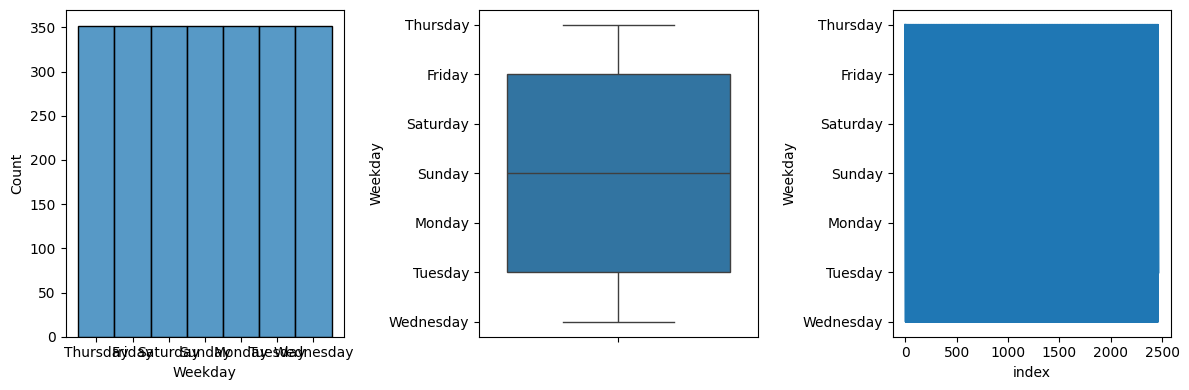

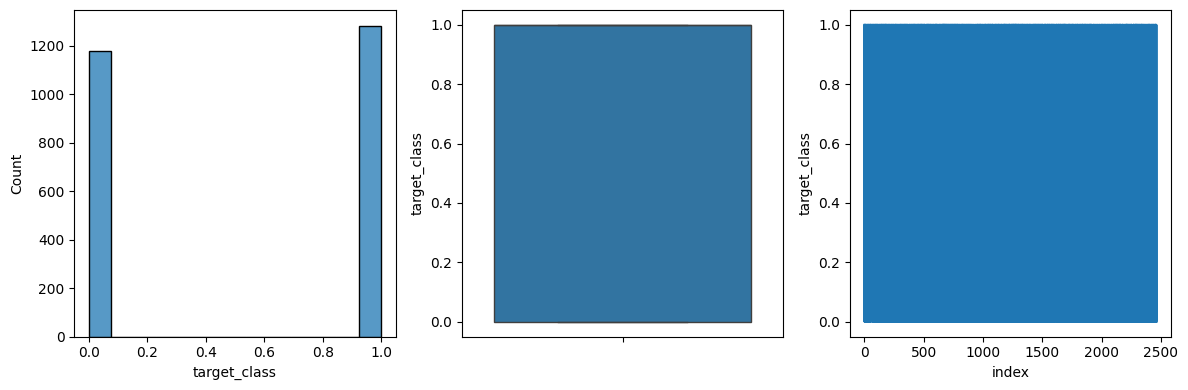

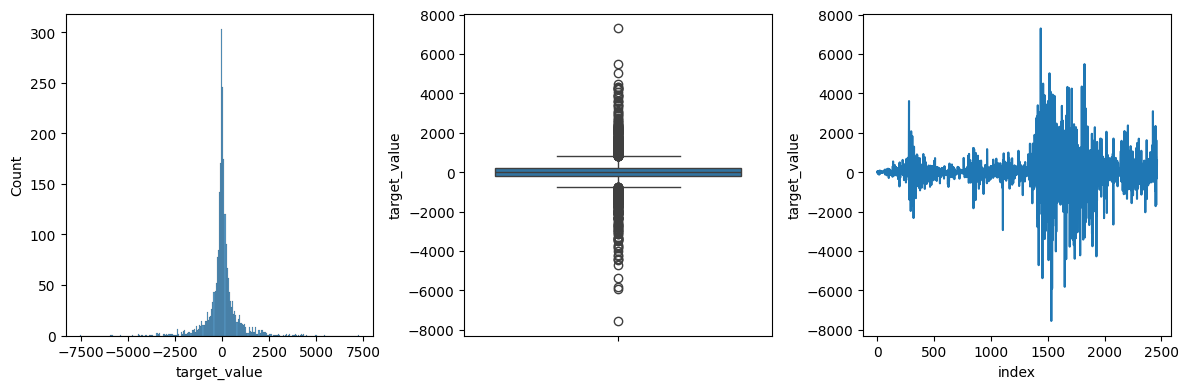

In [14]:
cols = data_aug.columns[1:]

for i in range(cols.shape[0]):
    fig, axes = plt.subplots(1,3,figsize=(12,4))
    sns.histplot(data_aug.loc[:,cols[i]],ax=axes[0])
    sns.boxplot(data_aug.loc[:,cols[i]],ax=axes[1])
    sns.lineplot(data_aug.loc[:,cols[i]],ax=axes[2])
    plt.tight_layout()
    plt.show()

## Impute BTC Volume outlier 

In [15]:
# volume of btc trade and close price btc have decent correlation 
data_aug.loc[:,['Volume_btc','Close_btc']].corr()

Volume_btc  Close_btc
Volume_btc    1.000000   0.565493
Close_btc     0.565493   1.000000

In [16]:
# find max trading day btc and tinvestigate the close price around that day 
max_trading_day = np.argmax(data_aug.loc[:,['Volume_btc']])

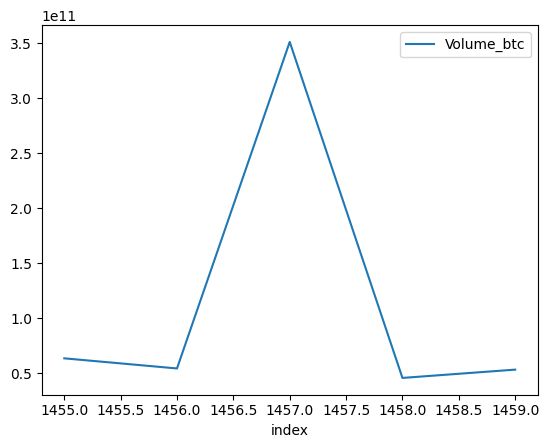

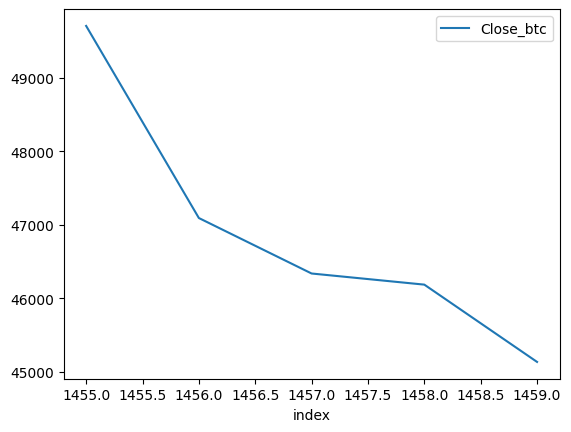

In [17]:
sns.lineplot(data_aug.loc[max_trading_day-2:max_trading_day+2,['Volume_btc']])
plt.show()
sns.lineplot(data_aug.loc[max_trading_day-2:max_trading_day+2,['Close_btc']])
plt.show()

In [18]:
# impute max volume day with volume from max_trading day -1 

data_aug.loc[max_trading_day,['Volume_btc']] = data_aug.loc[max_trading_day-1,['Volume_btc']]

## impute Oil Price negative outlier 

In [19]:
# find max trading day btc and tinvestigate the close price around that day 
crash_day_oil = np.argmin(data_aug.loc[:,['Close_oil']])

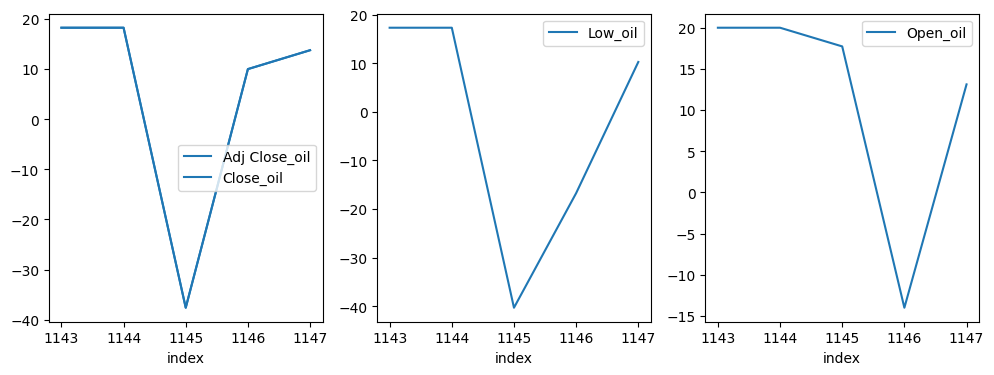

In [20]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

sns.lineplot(data_aug.loc[crash_day_oil-2:crash_day_oil+2,['Adj Close_oil']],ax=axes[0])
sns.lineplot(data_aug.loc[crash_day_oil-2:crash_day_oil+2,['Close_oil']],ax=axes[0])
sns.lineplot(data_aug.loc[crash_day_oil-2:crash_day_oil+2,['Low_oil']],ax=axes[1])
sns.lineplot(data_aug.loc[crash_day_oil-2:crash_day_oil+2,['Open_oil']],ax=axes[2])
plt.show()

In [21]:
# impute Close and Low with value from day -1 

data_aug.loc[crash_day_oil,['Close_oil']] = data_aug.loc[crash_day_oil-1,['Close_oil']]
data_aug.loc[crash_day_oil,['Adj Close_oil']] = data_aug.loc[crash_day_oil-1,['Adj Close_oil']]

data_aug.loc[crash_day_oil,['Low_oil']] = data_aug.loc[crash_day_oil-1,['Low_oil']]
data_aug.loc[crash_day_oil+1,['Low_oil']] = data_aug.loc[crash_day_oil-1,['Low_oil']]

data_aug.loc[crash_day_oil+1,['Open_oil']] = data_aug.loc[crash_day_oil,['Open_oil']]

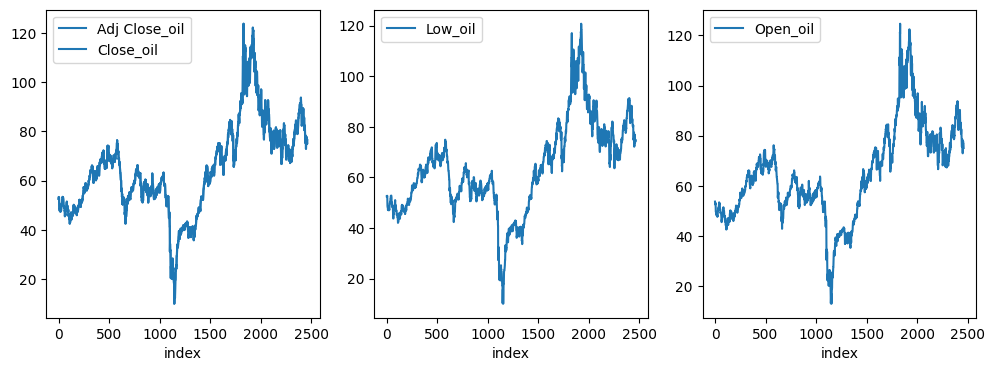

In [22]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

sns.lineplot(data_aug.loc[:,['Adj Close_oil']],ax=axes[0])
sns.lineplot(data_aug.loc[:,['Close_oil']],ax=axes[0])
sns.lineplot(data_aug.loc[:,['Low_oil']],ax=axes[1])
sns.lineplot(data_aug.loc[:,['Open_oil']],ax=axes[2])
plt.show()

## identify the days with extremely high gold volume trade

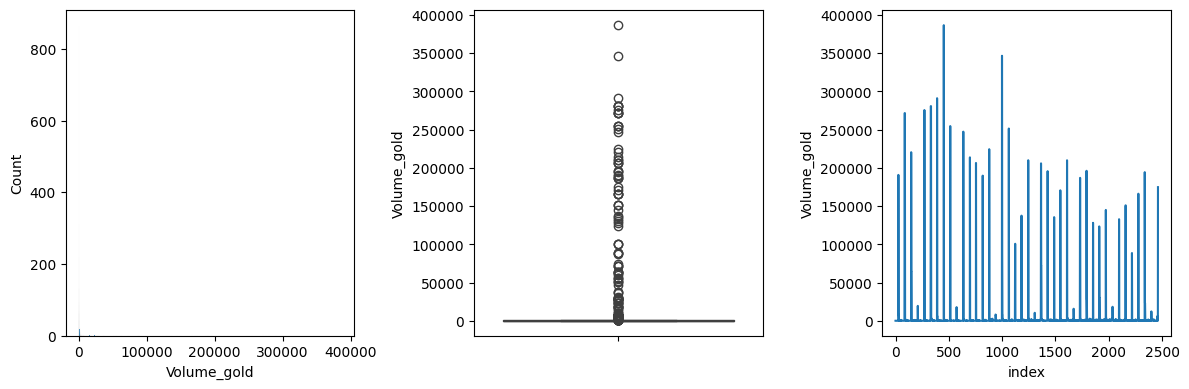

In [23]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
sns.histplot(data_aug.loc[:,'Volume_gold'],ax=axes[0])
sns.boxplot(data_aug.loc[:,'Volume_gold'],ax=axes[1])
sns.lineplot(data_aug.loc[:,'Volume_gold'],ax=axes[2])
plt.tight_layout()
plt.show()

In [24]:
max_volume_days = detect_outliers(data_aug.loc[:,['Volume_gold']], method='iqr', threshold=10)

(20.0, 40.0)

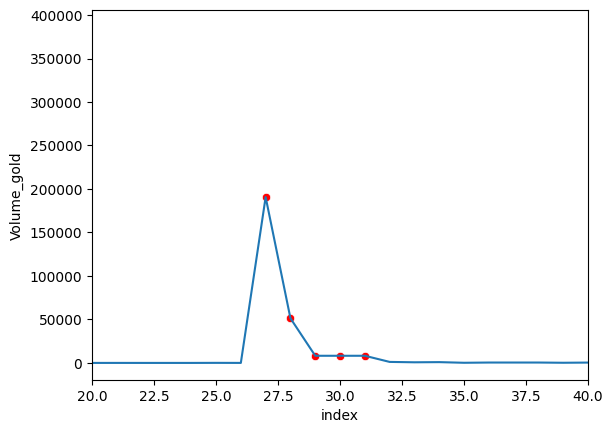

In [25]:
sns.lineplot(data_aug.loc[:,'Volume_gold'])
sns.scatterplot(x=max_volume_days['Volume_gold'], 
                y=data_aug.loc[max_volume_days['Volume_gold'], 'Volume_gold'],
               color='red')

plt.xlim(20,40)

<Axes: xlabel='index', ylabel='Volume_gold'>

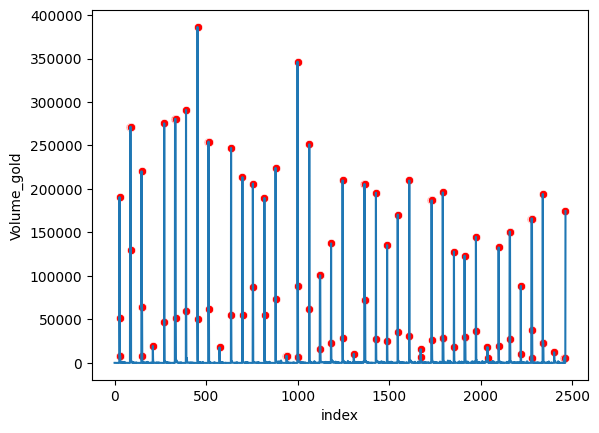

In [26]:
sns.lineplot(data_aug.loc[:,'Volume_gold'])
sns.scatterplot(x=max_volume_days['Volume_gold'], 
                y=data_aug.loc[max_volume_days['Volume_gold'], 'Volume_gold'],
               color='red')



In [27]:
data_aug.loc[:,'High_trading_volume_gold'] = 0
data_aug.loc[max_volume_days['Volume_gold'],'High_trading_volume_gold'] = 1

<Axes: xlabel='target_value', ylabel='Count'>

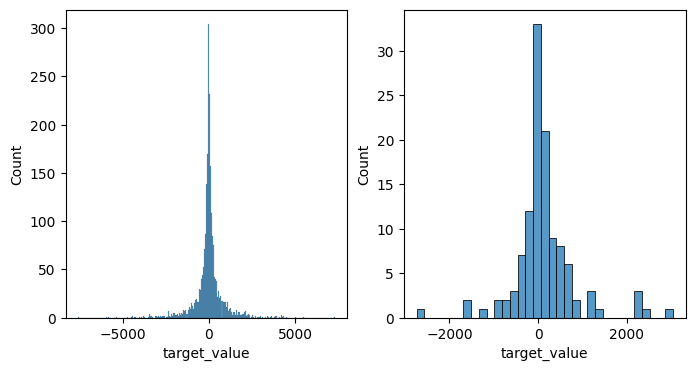

In [28]:
fig, axes = plt.subplots(1,2,figsize=(8,4))

sns.histplot(data_aug.loc[data_aug.High_trading_volume_gold==0,'target_value'],ax=axes[0])
sns.histplot(data_aug.loc[data_aug.High_trading_volume_gold==1,'target_value'],ax=axes[1])

In [29]:
data_aug.loc[data_aug.High_trading_volume_gold==0,'target_class'].value_counts()

target_class
1    1213
0    1131
Name: count, dtype: int64

In [30]:
data_aug.loc[data_aug.High_trading_volume_gold==1,'target_class'].value_counts()

target_class
1    70
0    49
Name: count, dtype: int64

## identify low volume oil trading days 

In [31]:
# volume of btc trade and close price btc have decent correlation 
data_aug.loc[:,['Volume_oil','Close_btc']].corr()

Volume_oil  Close_btc
Volume_oil    1.000000  -0.397992
Close_btc    -0.397992   1.000000

In [32]:
data_aug['next_close'] = data_aug['Close_btc'].shift(-1)


In [33]:
data_aug.loc[:,['Volume_oil','next_close']].corr()

Volume_oil  next_close
Volume_oil    1.000000   -0.397252
next_close   -0.397252    1.000000

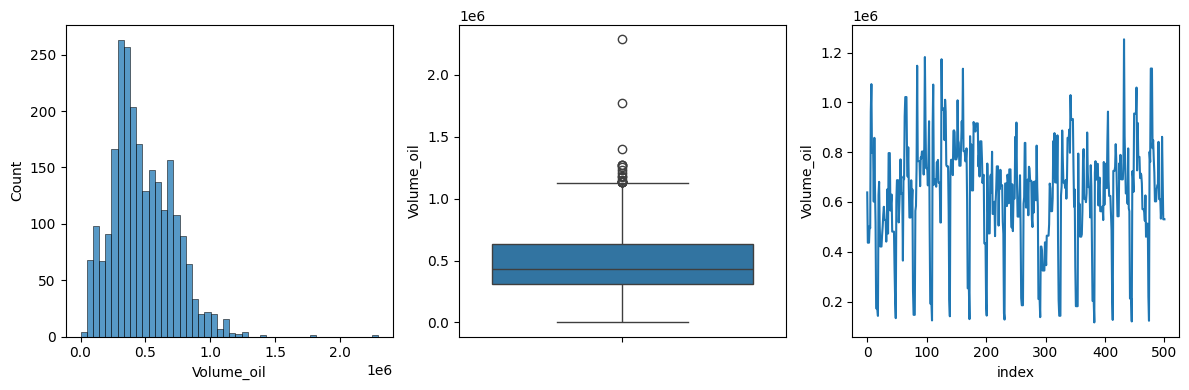

In [34]:
fig, axes = plt.subplots(1,3,figsize=(12,4))
sns.histplot(data_aug.loc[:,'Volume_oil'],ax=axes[0])
sns.boxplot(data_aug.loc[:,'Volume_oil'],ax=axes[1])
sns.lineplot(data_aug.loc[:500,'Volume_oil'],ax=axes[2])
plt.tight_layout()
plt.show()

In [35]:
# define low volume oil days with global thr of 0.3e6

low_volume_days_oil = np.where(data_aug.loc[:,'Volume_oil'] < 0.2*10**6)[0]

<Axes: xlabel='index', ylabel='Volume_oil'>

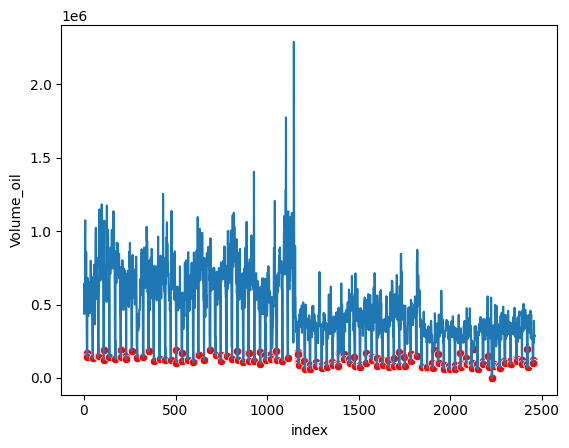

In [36]:
sns.lineplot(data_aug.loc[:,'Volume_oil'])
sns.scatterplot(x=low_volume_days_oil, 
                y=data_aug.loc[low_volume_days_oil, 'Volume_oil'],
               color='red')



In [37]:
data_aug.loc[:,'Low_trading_volume_oil'] = 0
data_aug.loc[low_volume_days_oil,'Low_trading_volume_oil'] = 1

<Axes: xlabel='target_value', ylabel='Count'>

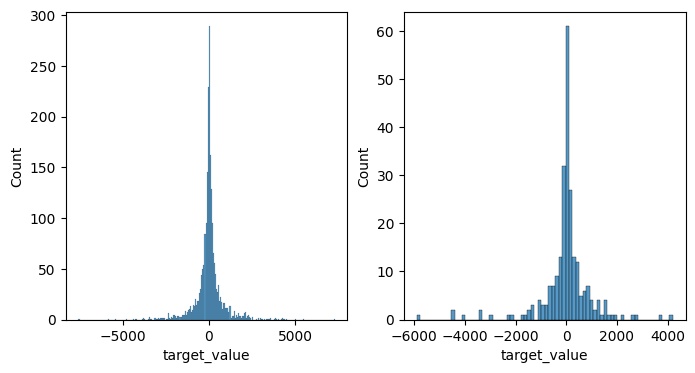

In [38]:
fig, axes = plt.subplots(1,2,figsize=(8,4))

sns.histplot(data_aug.loc[data_aug.Low_trading_volume_oil==0,'target_value'],ax=axes[0])
sns.histplot(data_aug.loc[data_aug.Low_trading_volume_oil==1,'target_value'],ax=axes[1])

In [39]:
data_aug.loc[data_aug.Low_trading_volume_oil==0,'target_class'].value_counts()

target_class
1    1139
0    1076
Name: count, dtype: int64

In [40]:
1139/(1139+1079)

0.5135256988277728

In [41]:
data_aug.loc[data_aug.Low_trading_volume_oil==1,'target_class'].value_counts()

target_class
1    144
0    104
Name: count, dtype: int64

In [42]:
144/(144+104)

0.5806451612903226

In [47]:
names = data_aug.columns[1:-6].to_list()

In [48]:
data_aug = differentiator(data_aug,names)

## calculate some technical features 

In [49]:
data_aug = add_ratio_trend_features(data_aug, target,variable, window_sizes = [5])

data_aug= add_ta_features(data_aug, suffixes=['_btc', '_oil', '_gold', '_sp500'], window_sizes=[5,])

data_aug = add_custom_features(data_aug, suffixes=['_btc', '_oil', '_gold', '_sp500'])

data_aug = add_technical_indicators(data_aug, suffixes=['_btc', '_oil', '_gold', '_sp500'], rsi_periods=[5])

data_aug = data_aug.dropna()

In [50]:
cols = data_aug.columns

## split bimodal gold and sp500 dists by eyeballing threshold 

In [51]:
sp500_thr = 3500
gold_thr = 1600

data_aug.loc[:,'sp500_high_regime'] = 0
data_aug.loc[data_aug.Close_sp500>sp500_thr,'sp500_high_regime'] = 1

data_aug.loc[:,'gold_high_regime'] = 0
data_aug.loc[data_aug.Close_gold>gold_thr,'gold_high_regime'] = 1

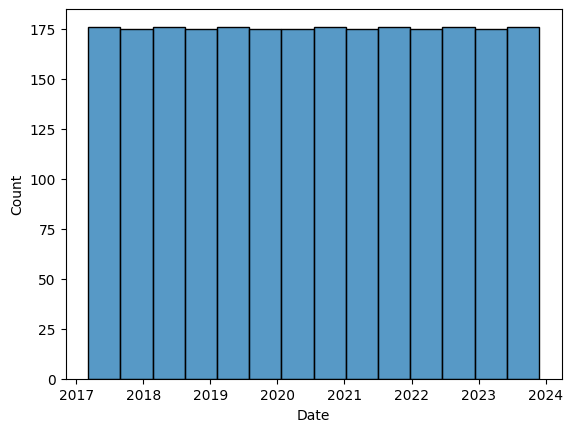

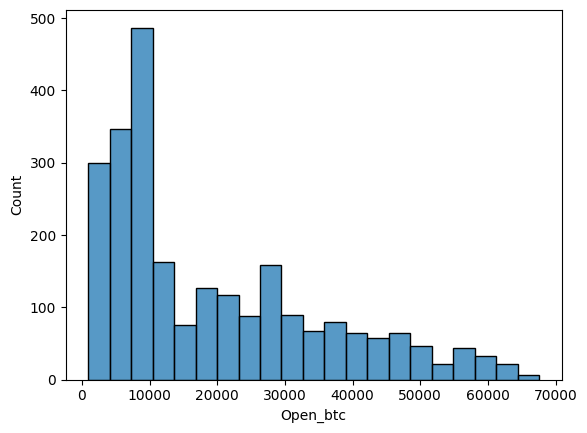

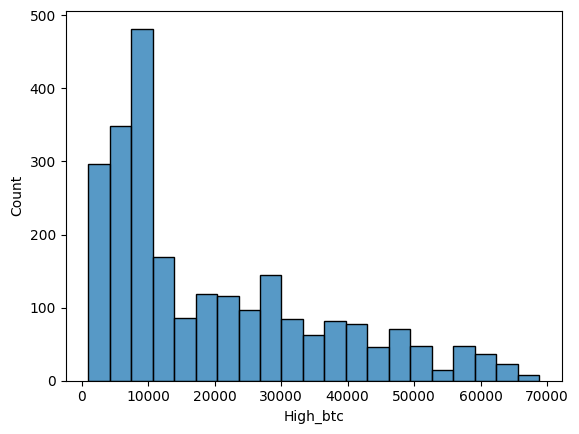

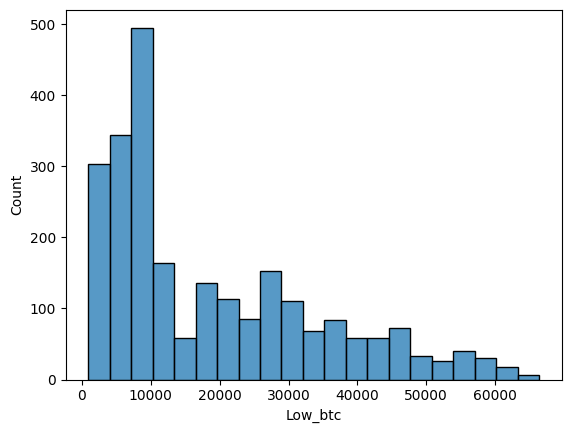

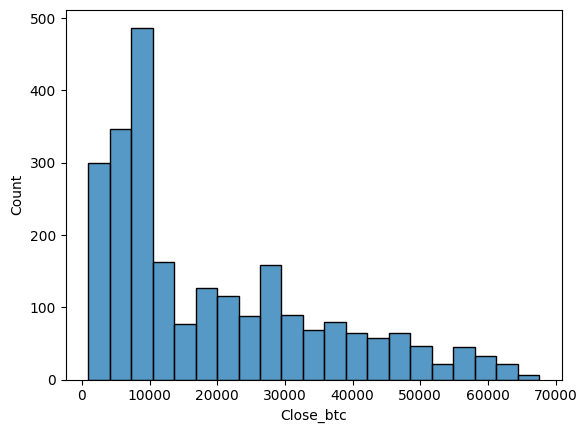

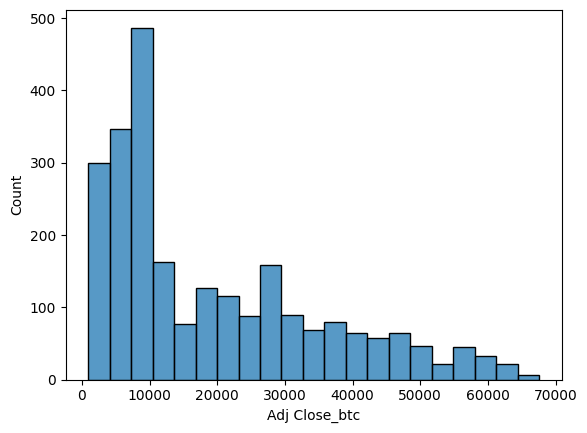

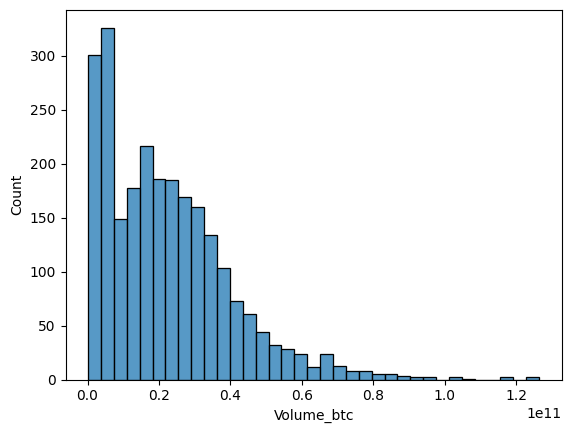

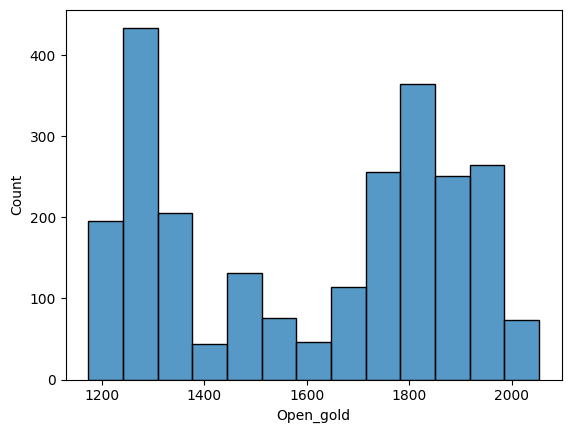

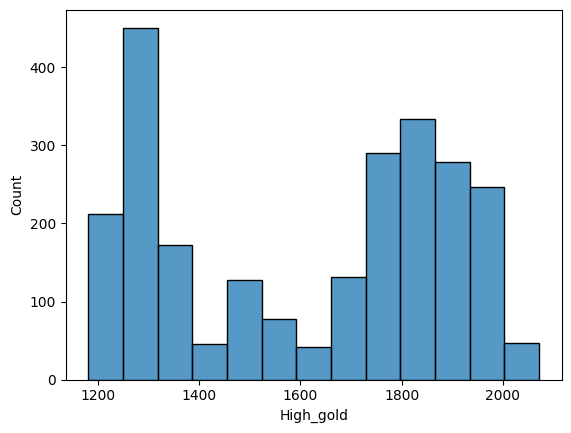

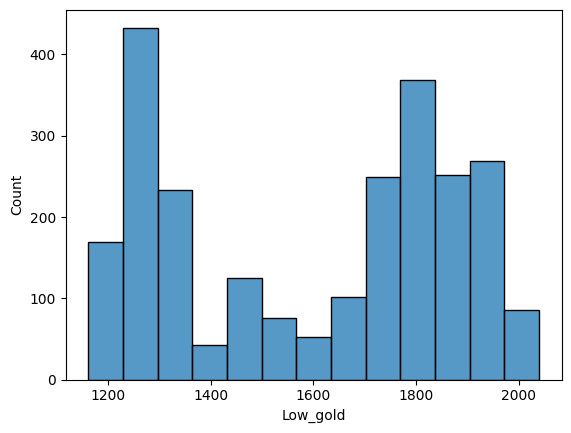

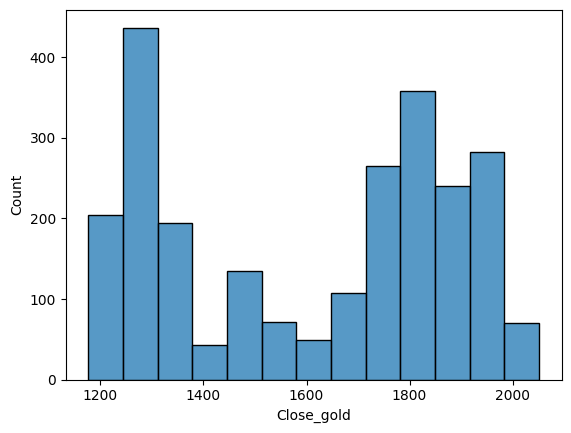

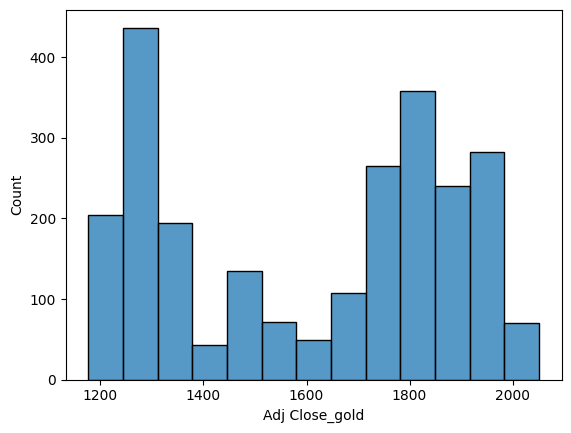

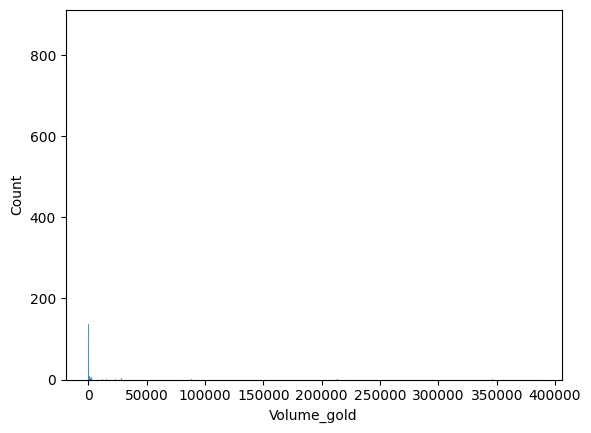

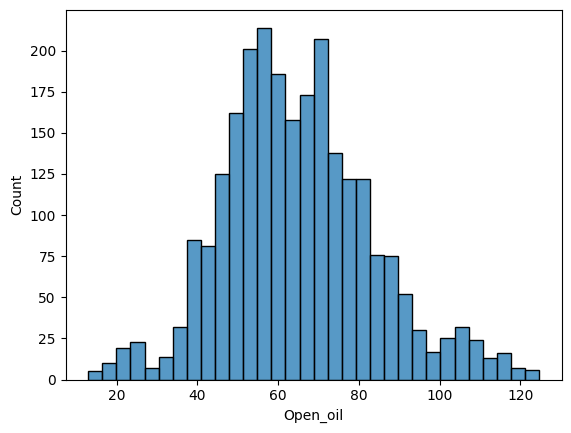

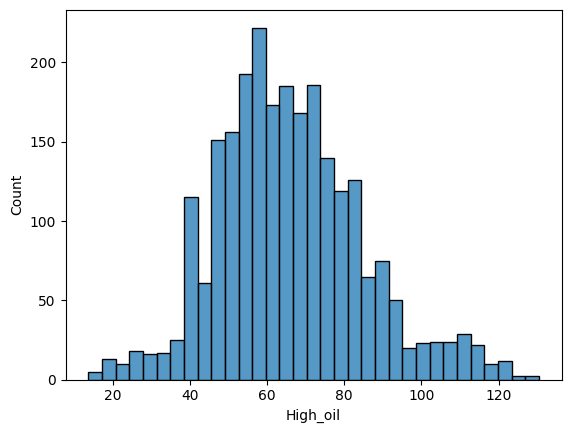

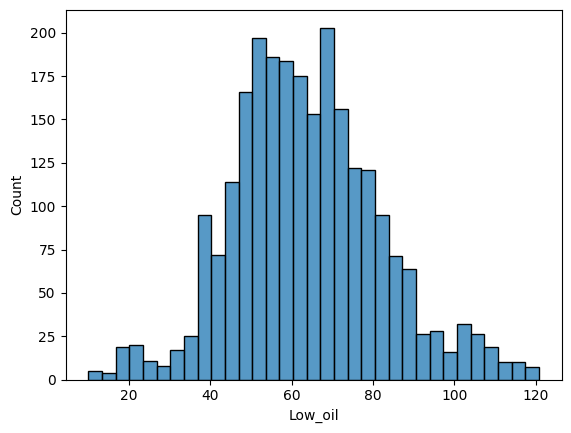

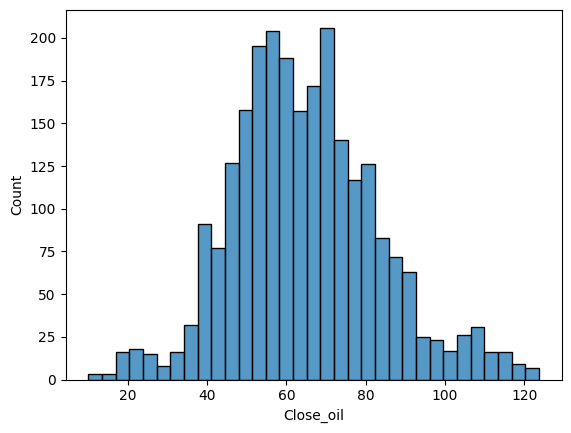

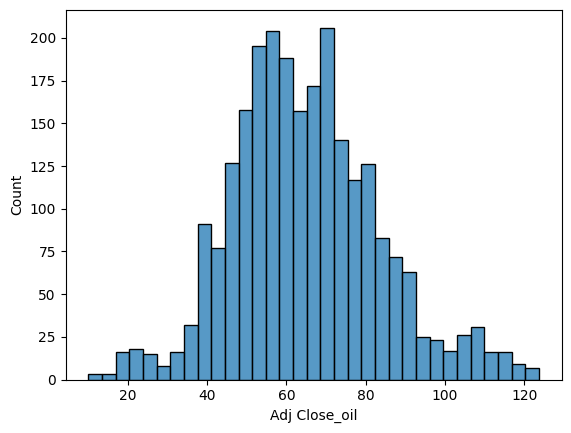

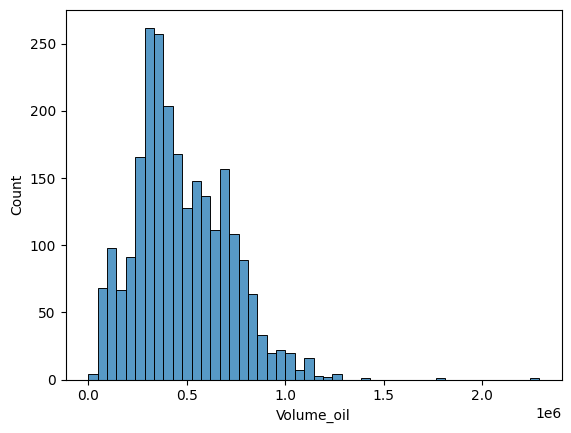

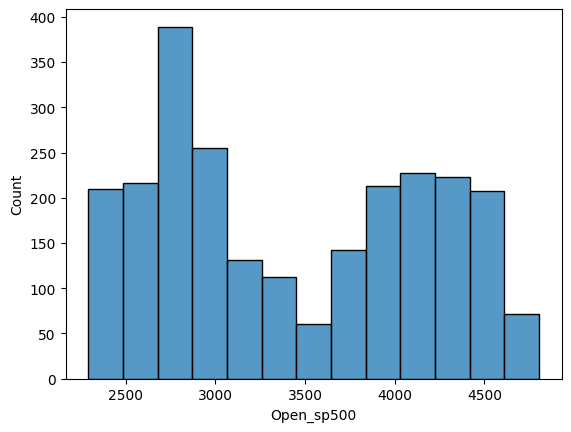

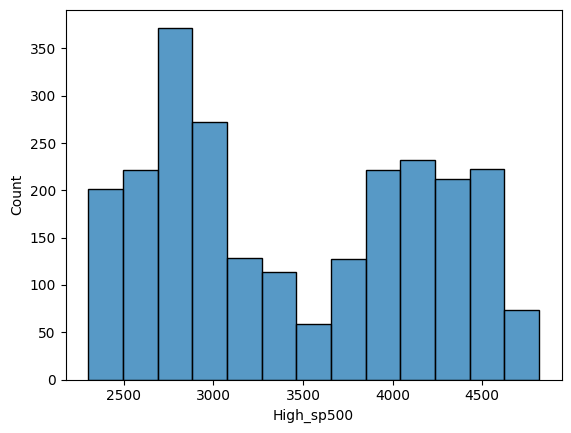

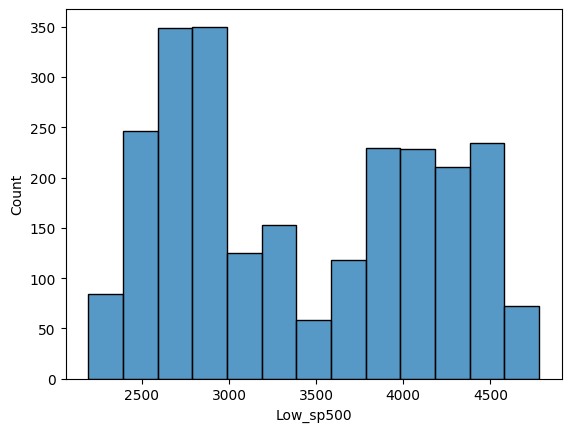

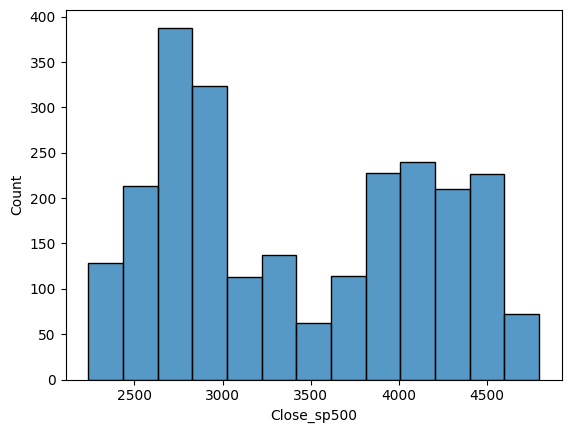

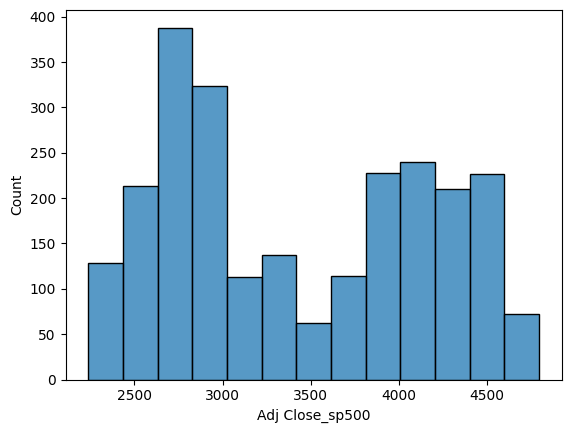

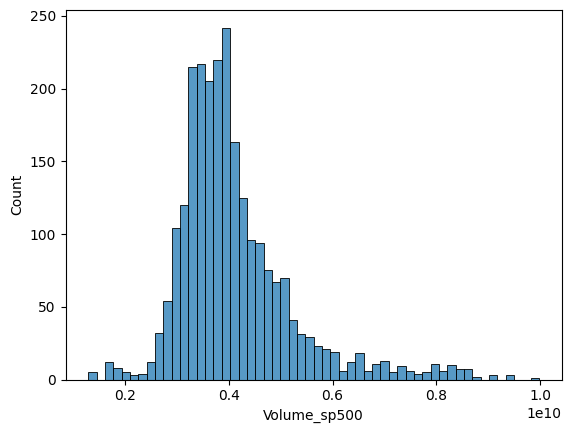

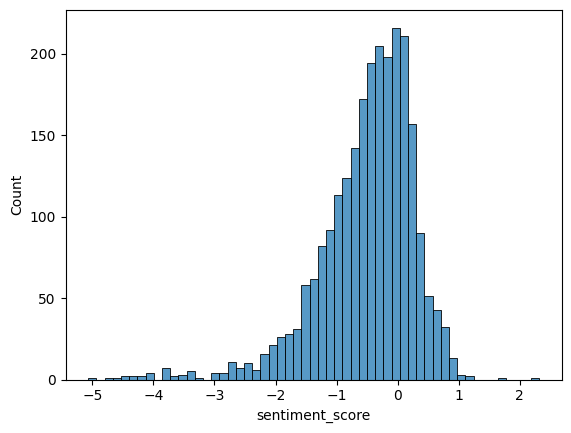

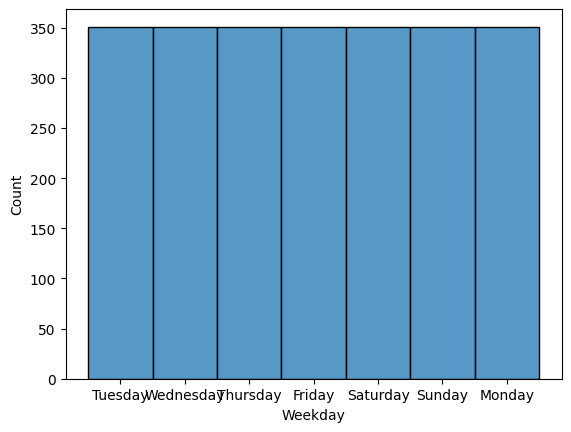

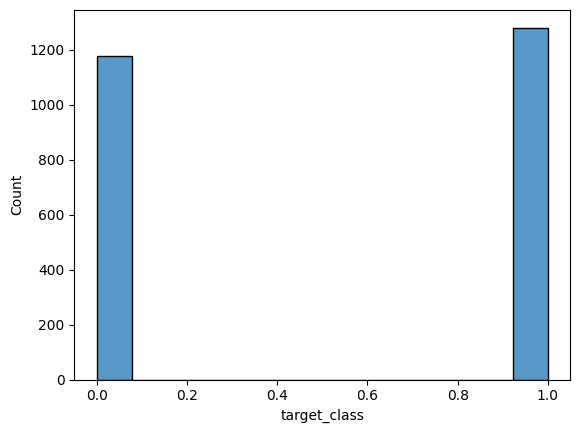

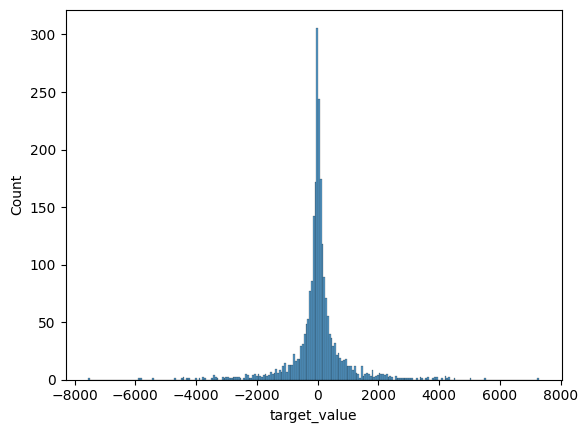

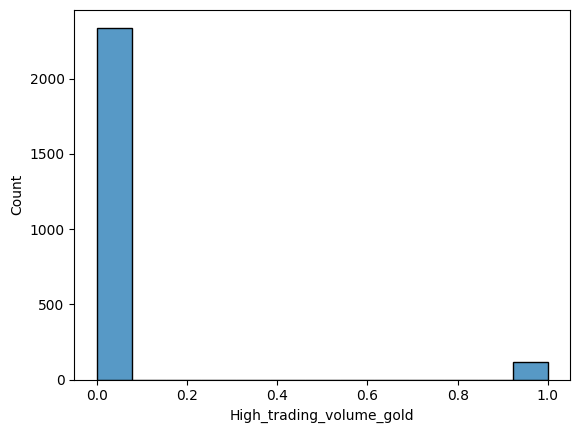

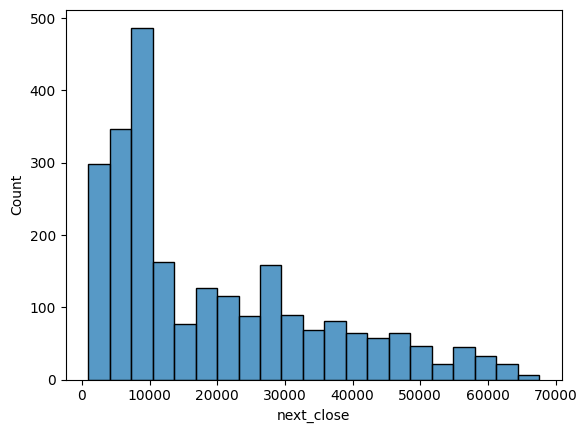

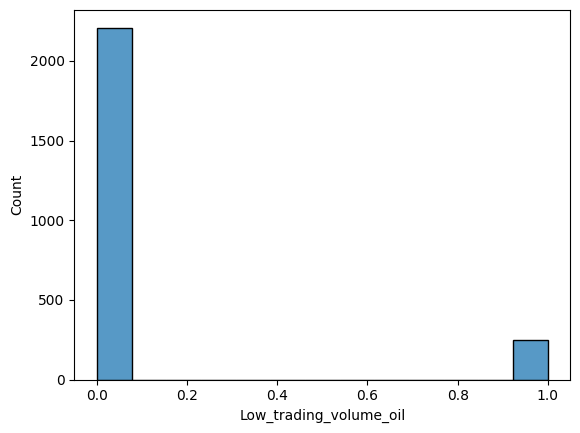

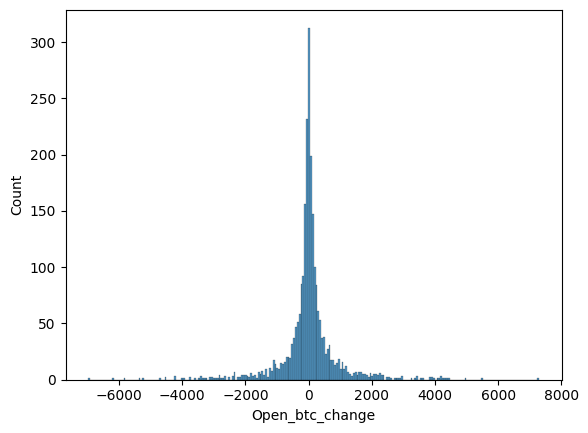

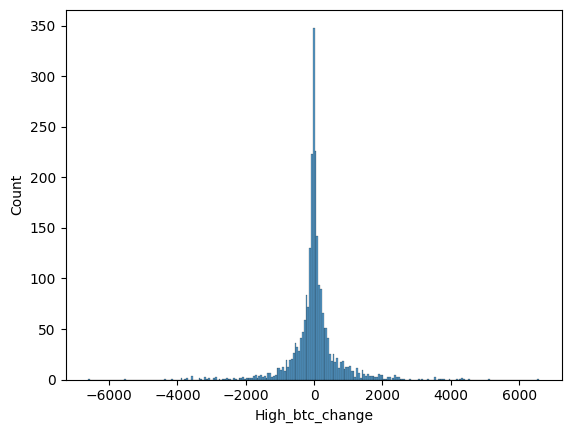

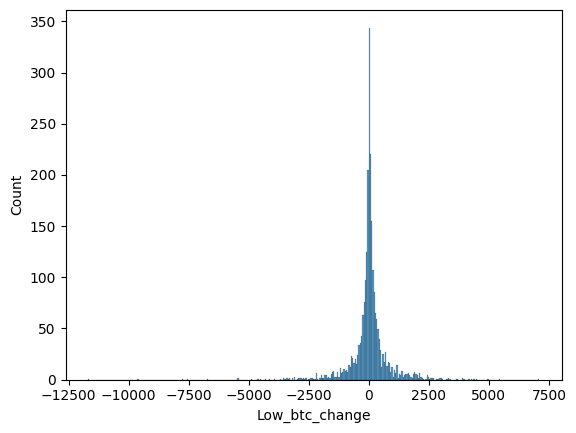

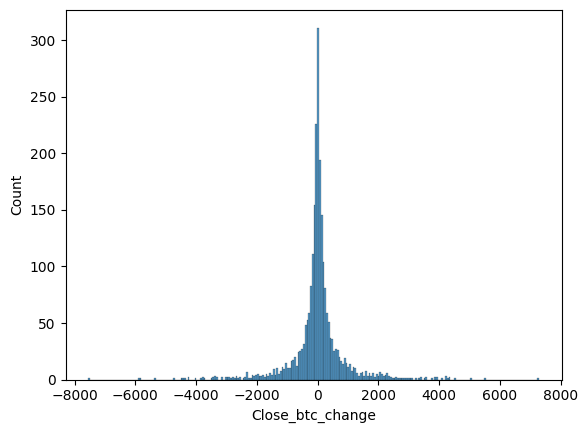

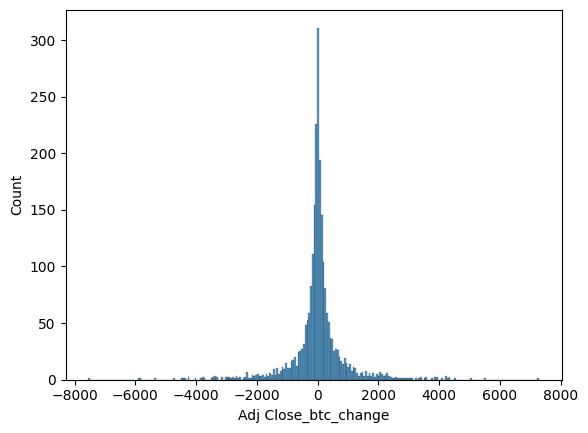

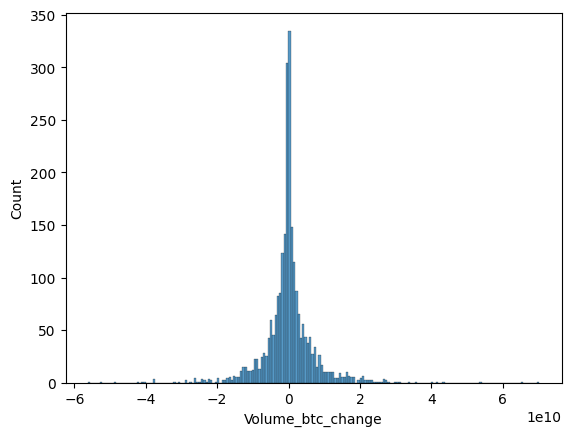

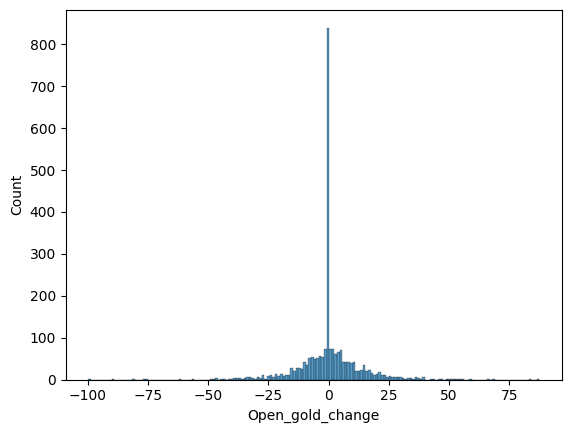

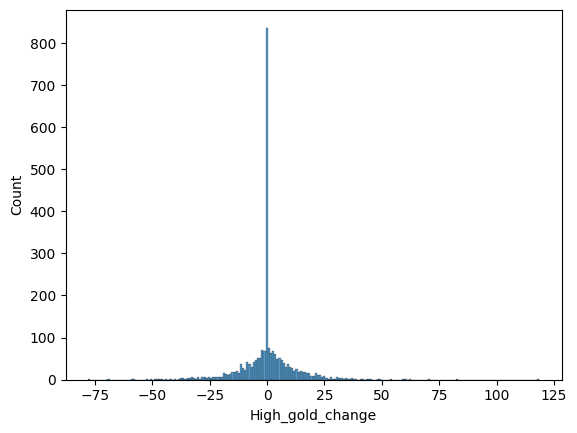

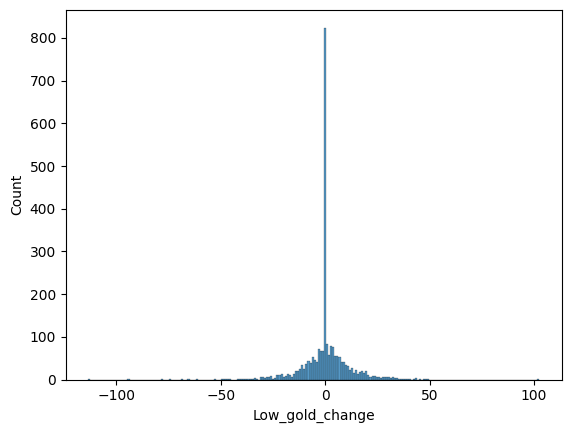

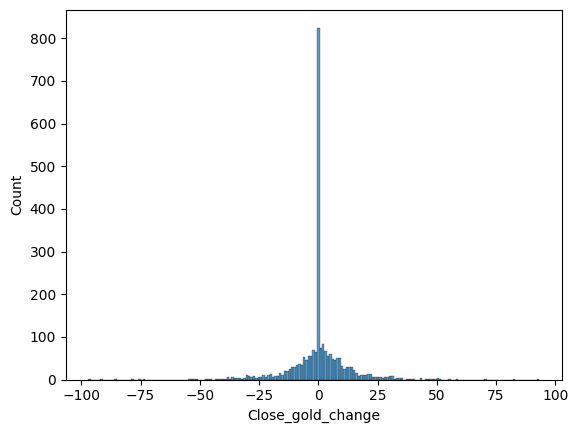

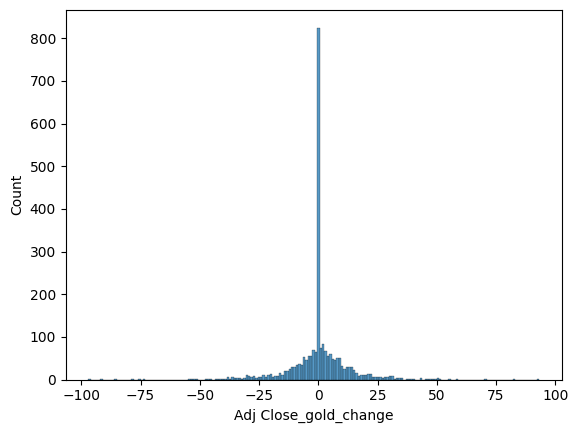

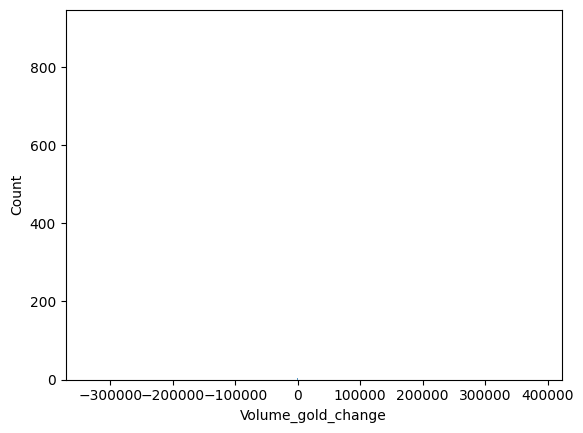

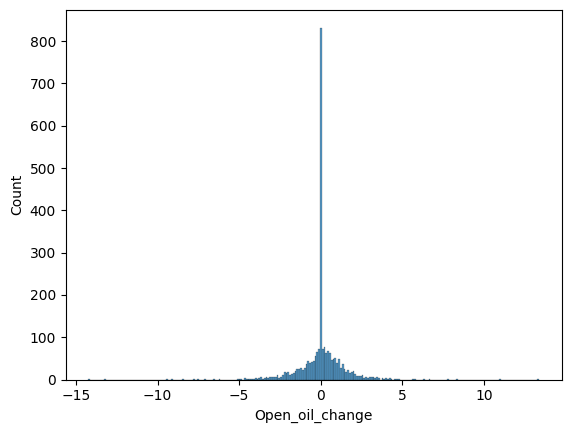

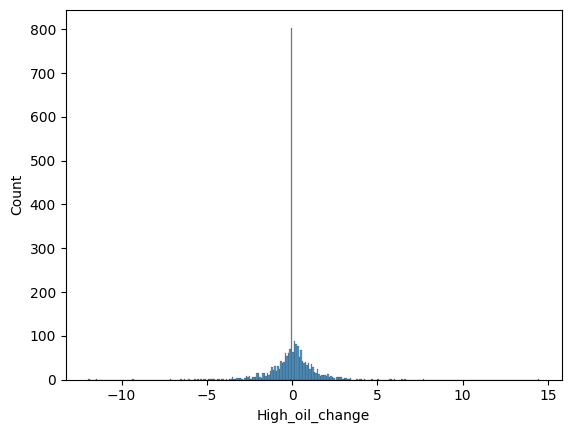

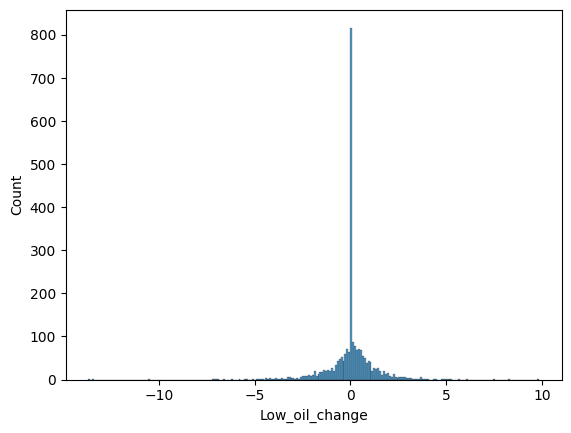

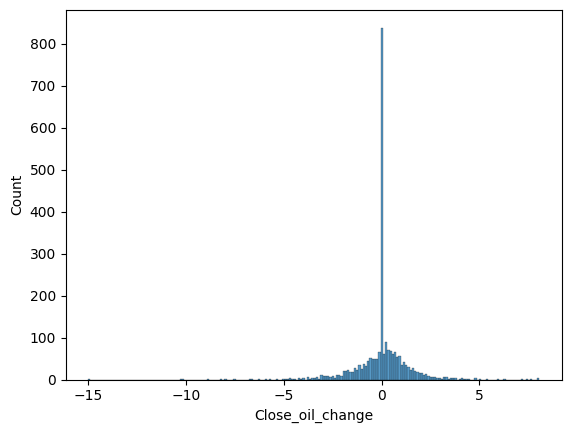

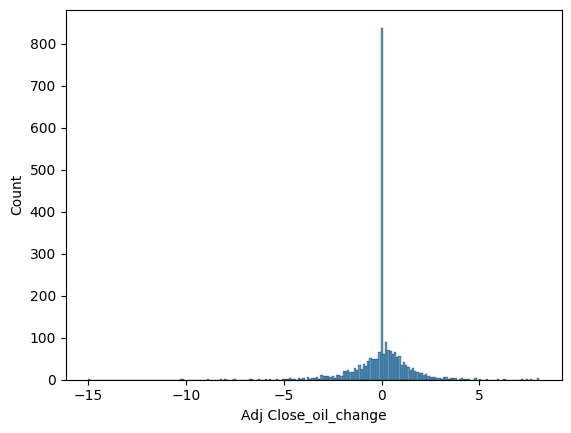

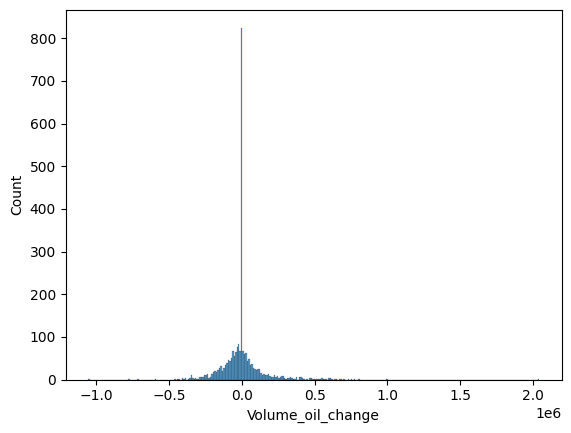

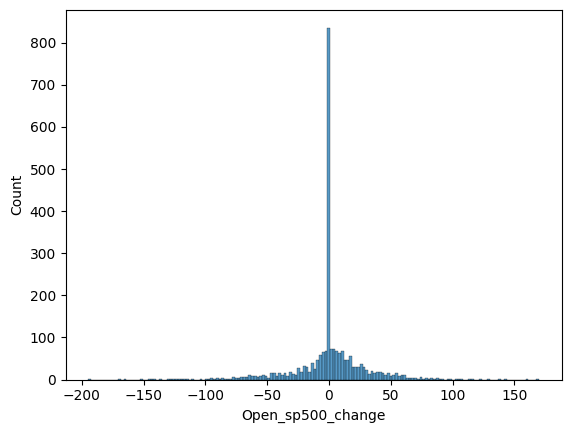

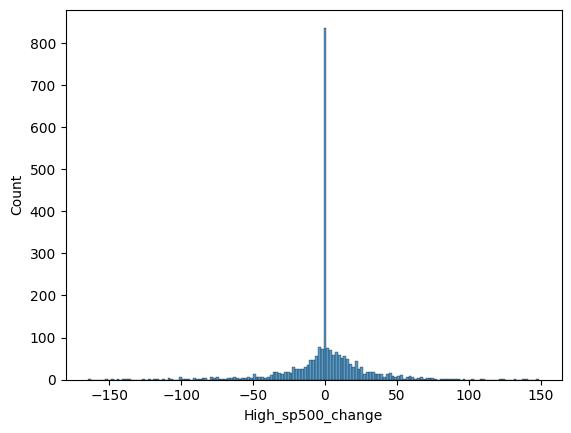

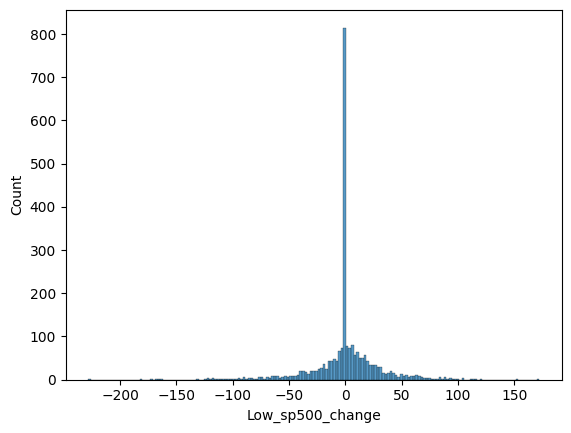

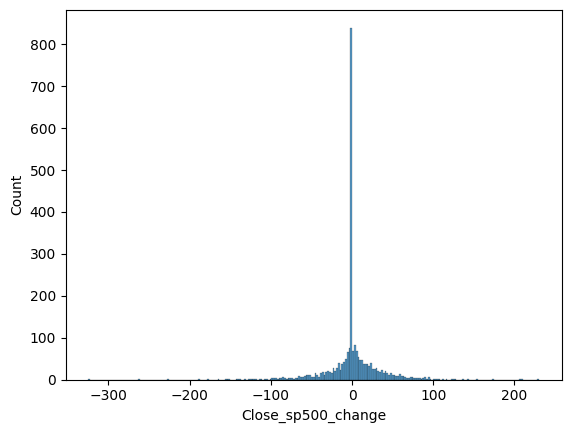

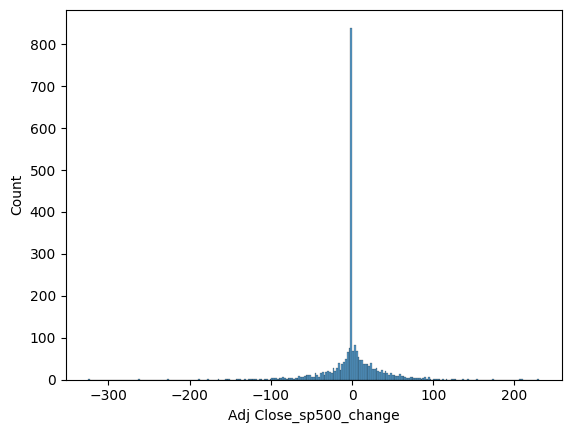

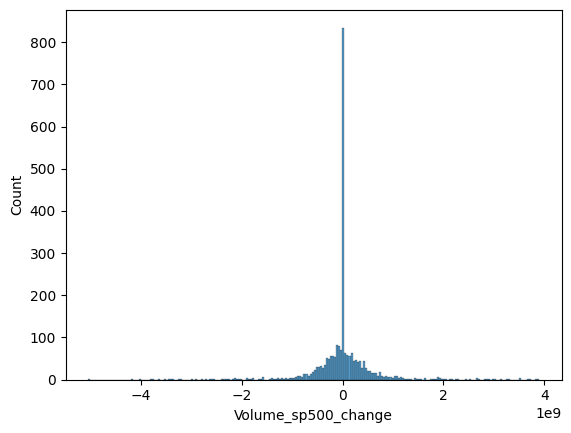

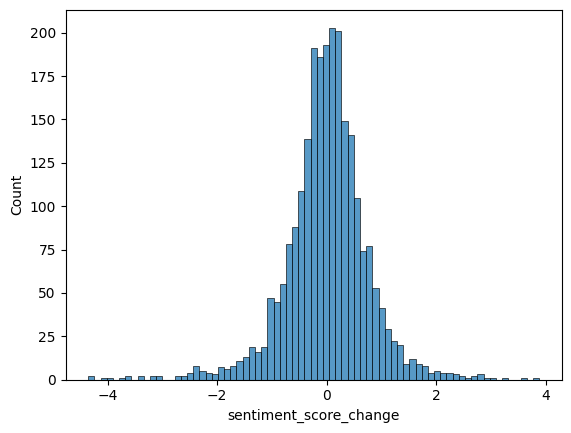

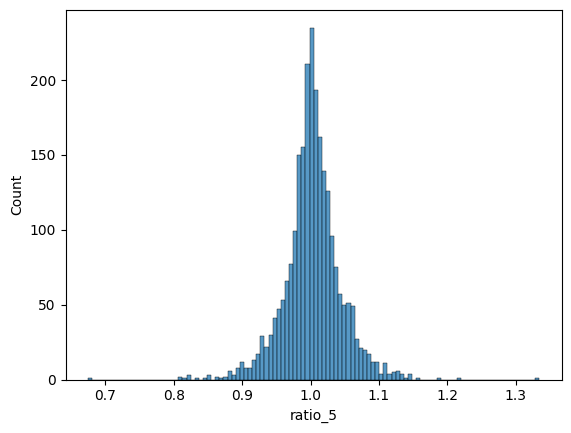

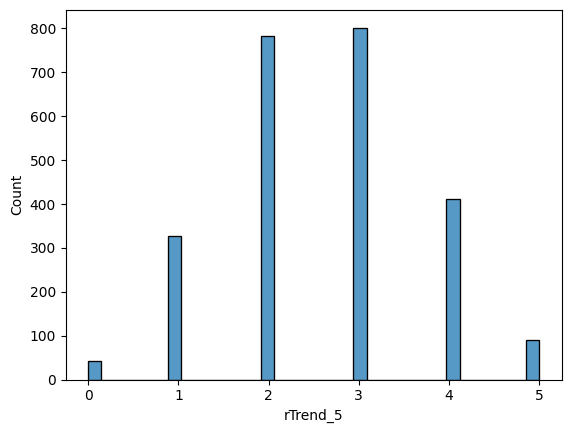

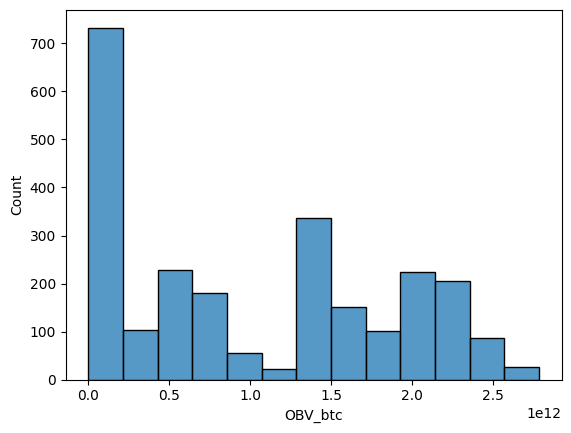

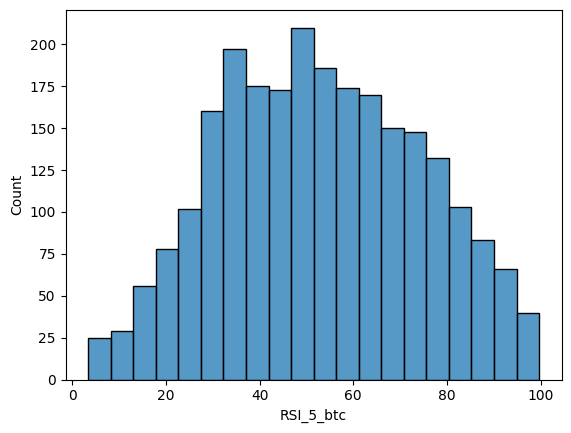

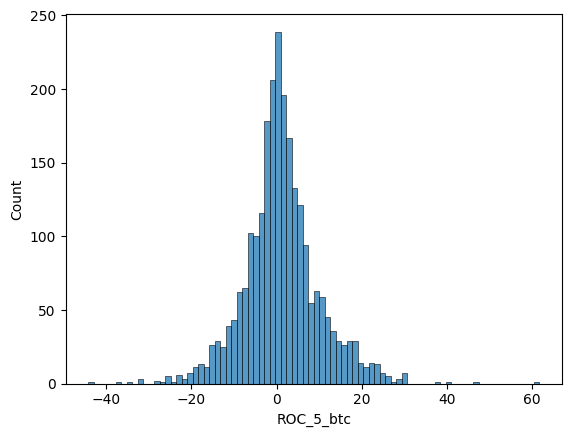

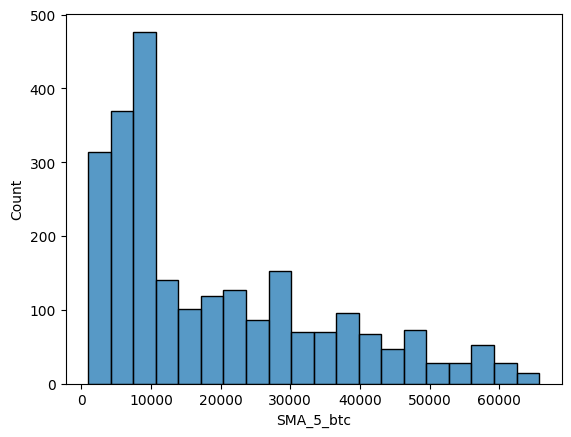

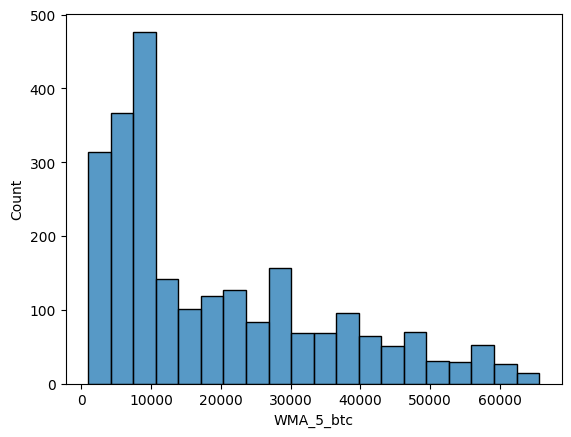

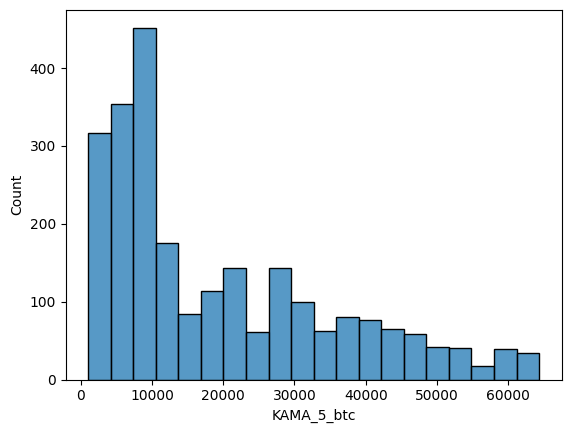

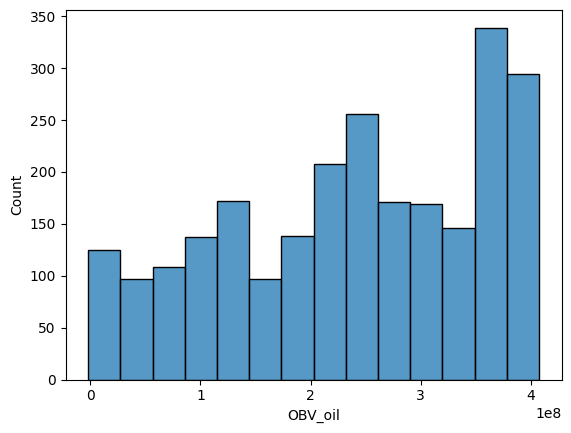

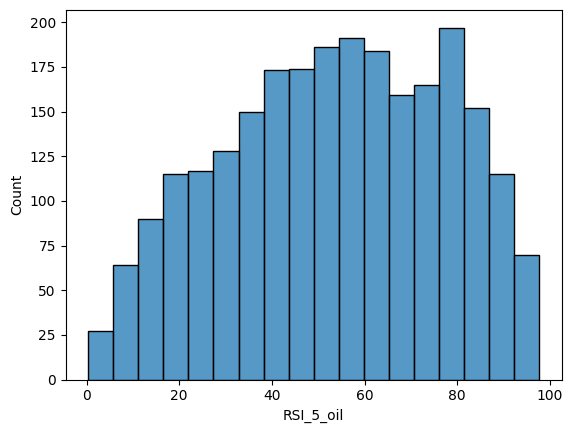

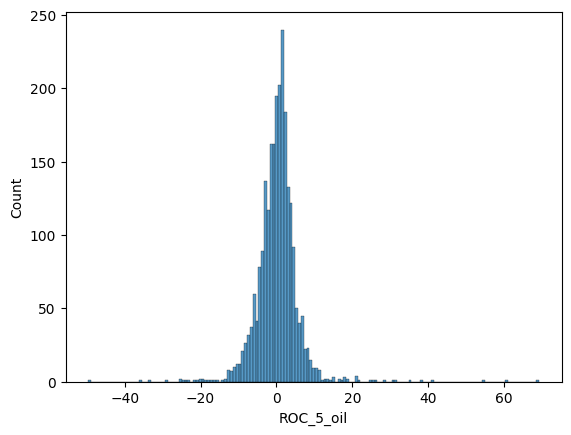

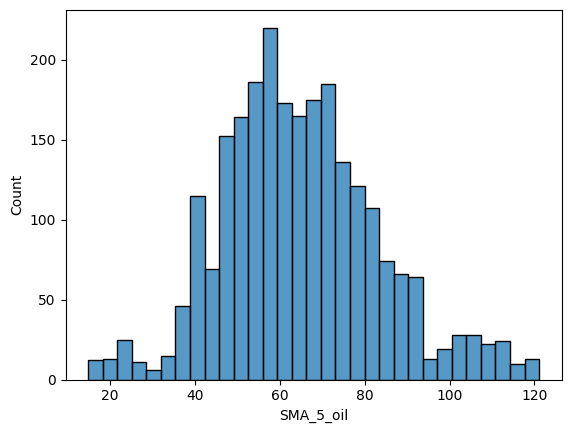

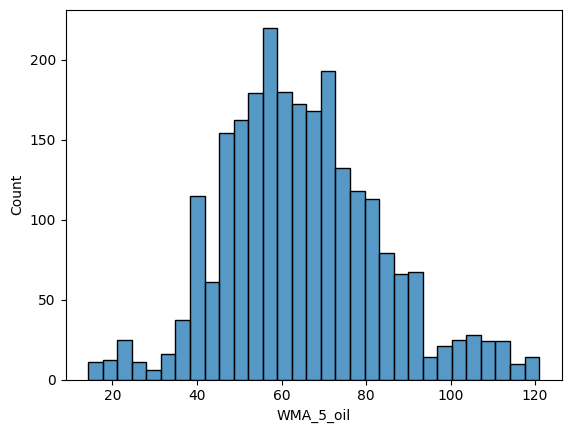

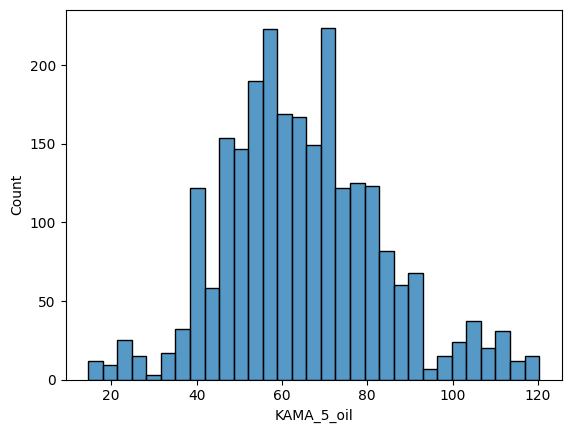

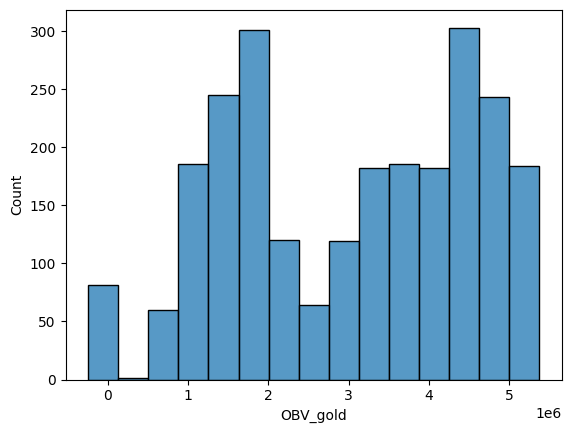

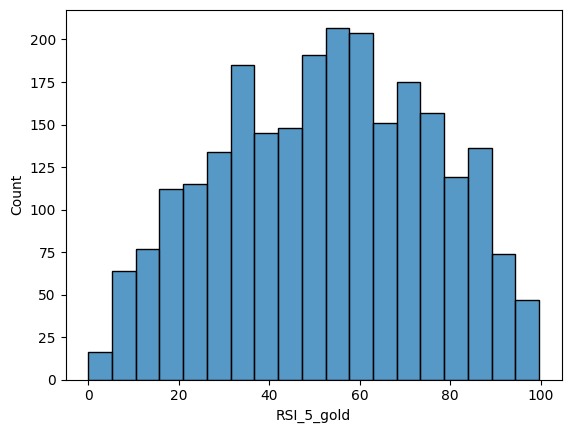

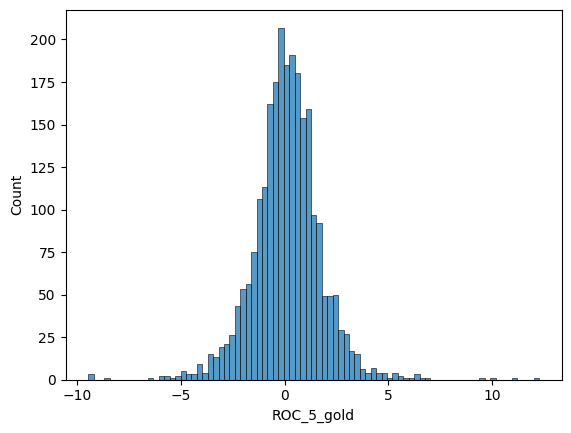

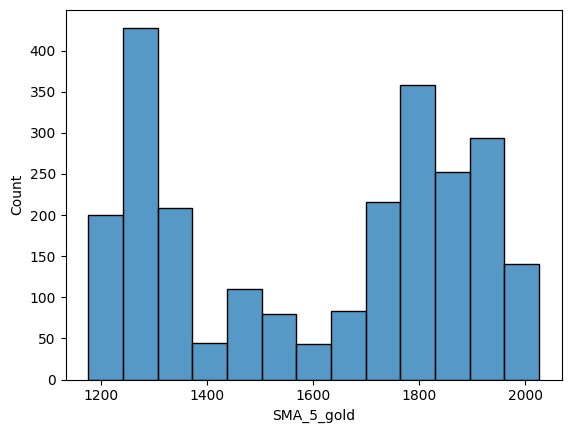

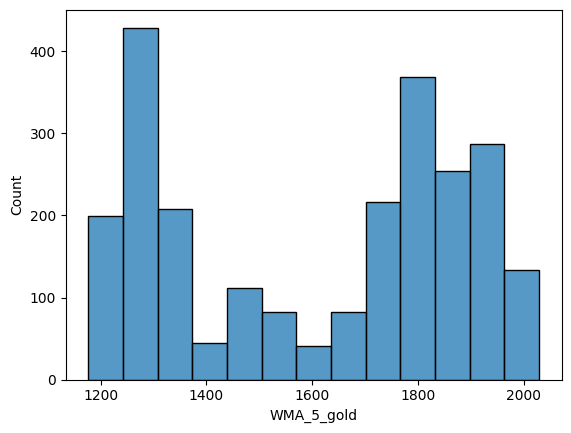

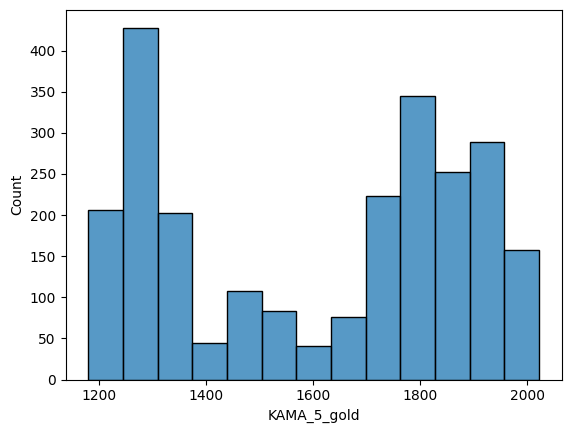

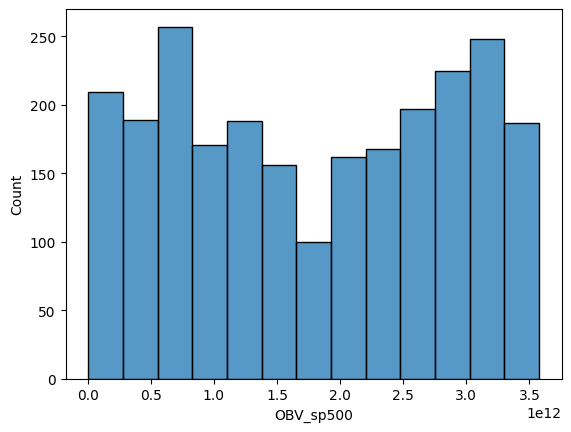

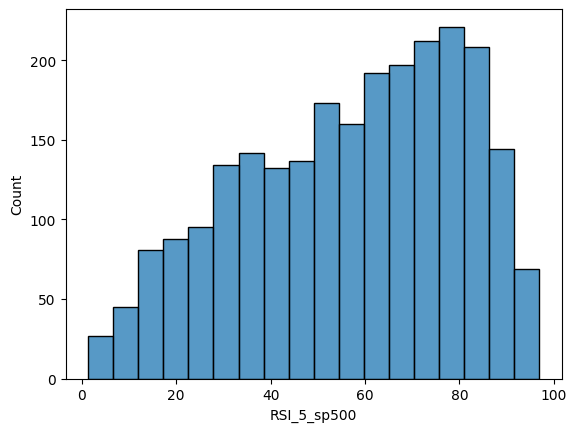

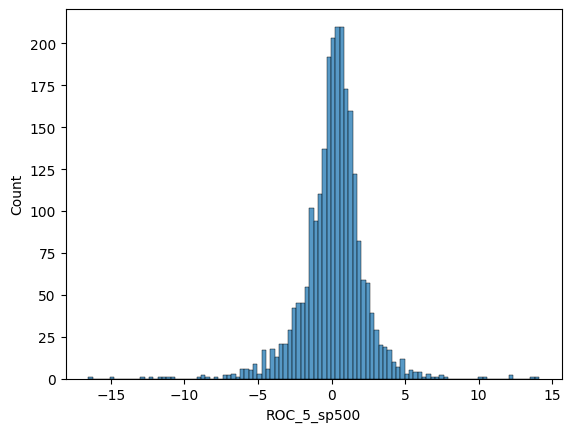

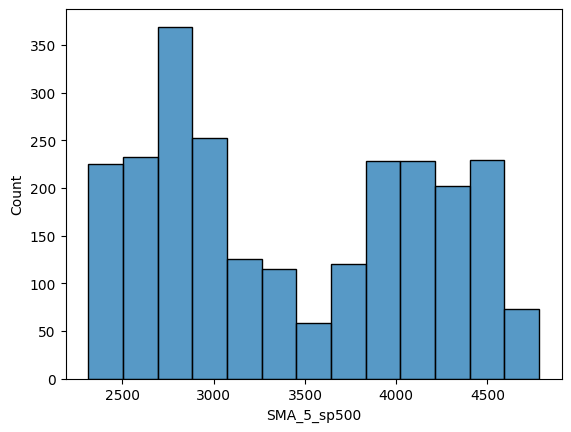

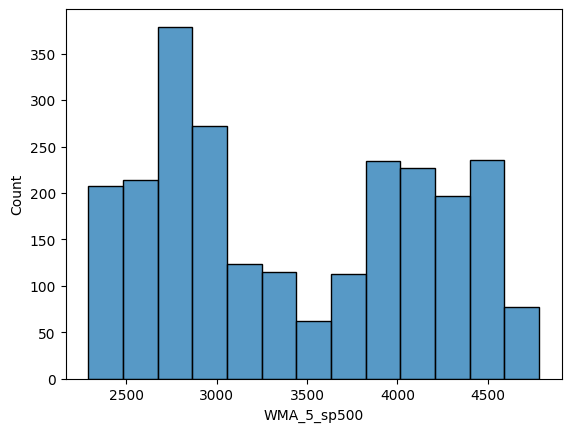

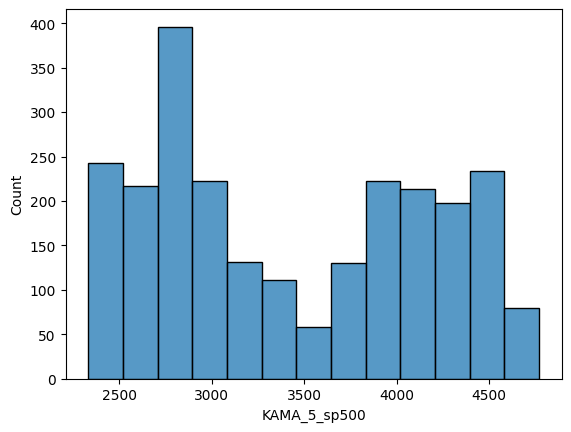

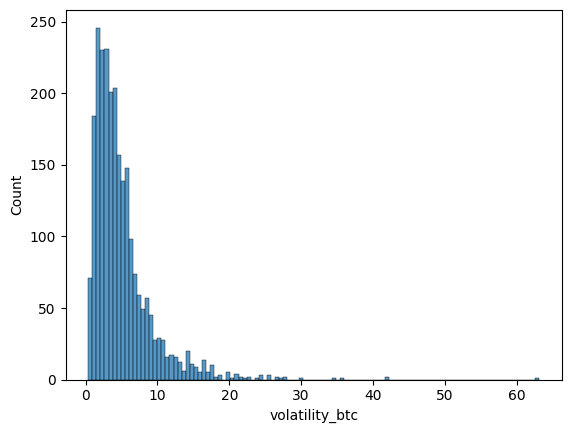

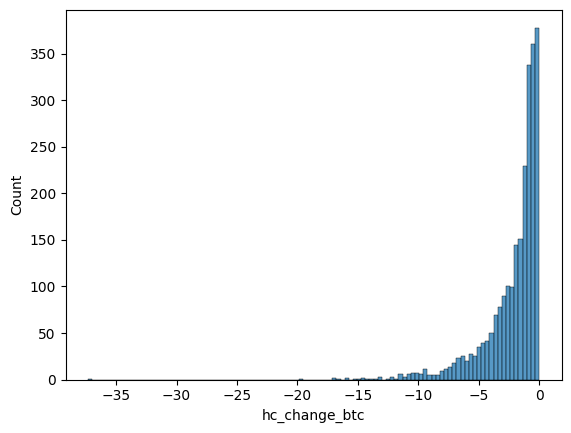

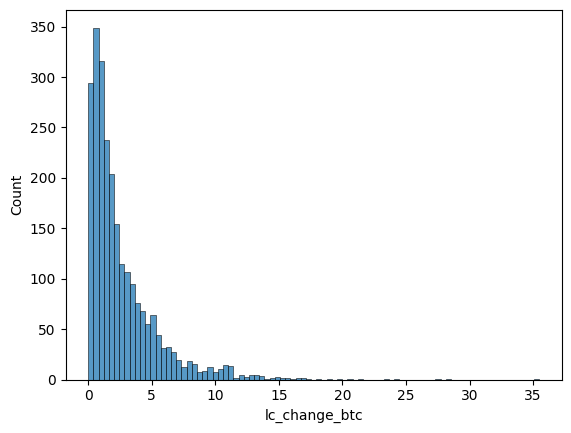

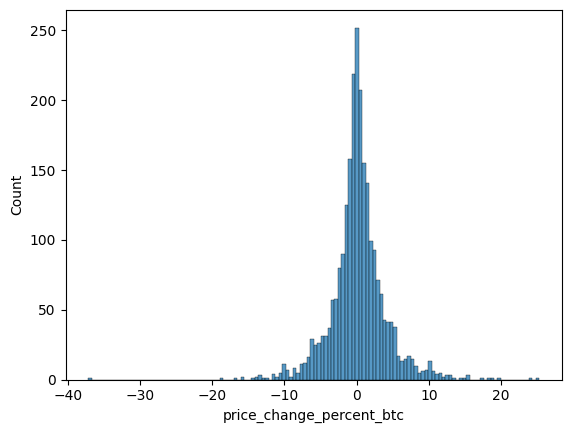

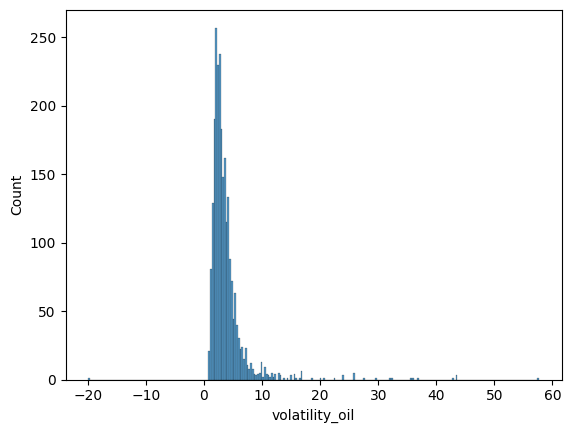

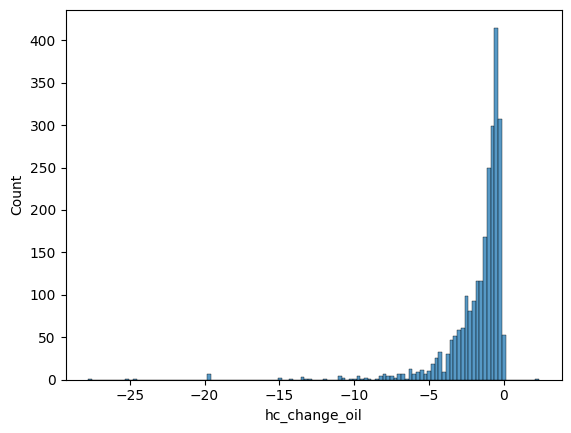

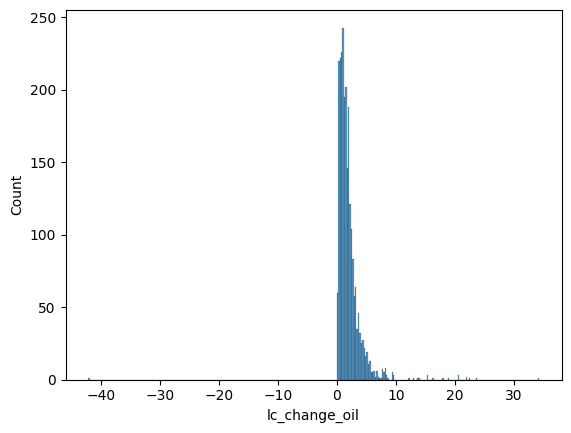

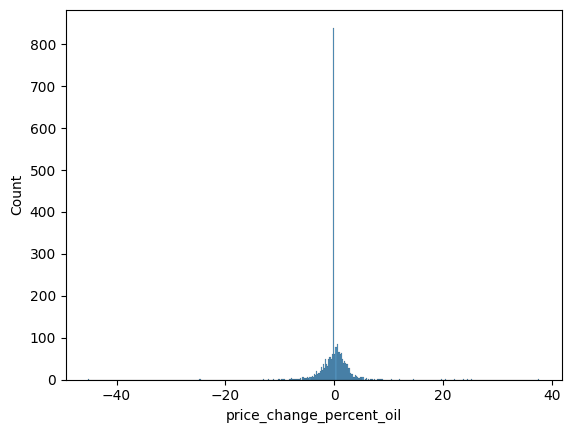

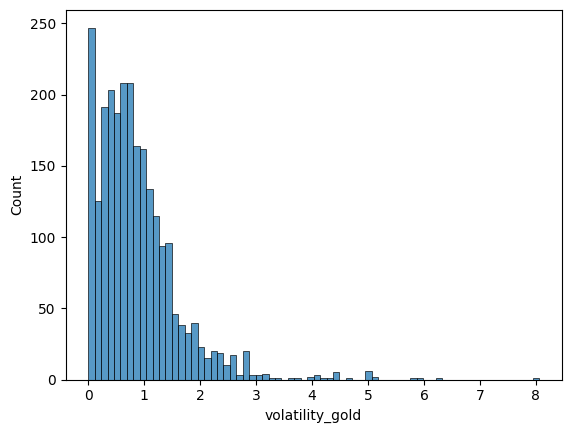

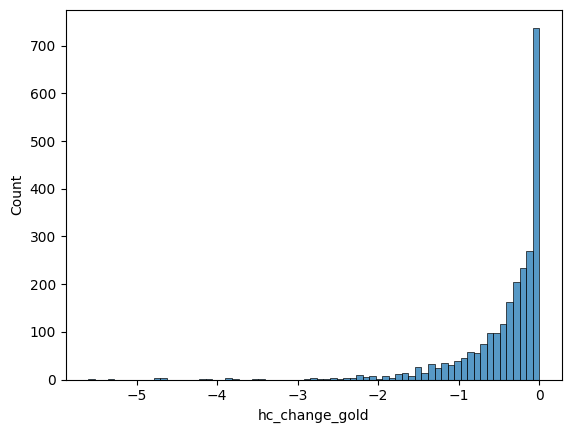

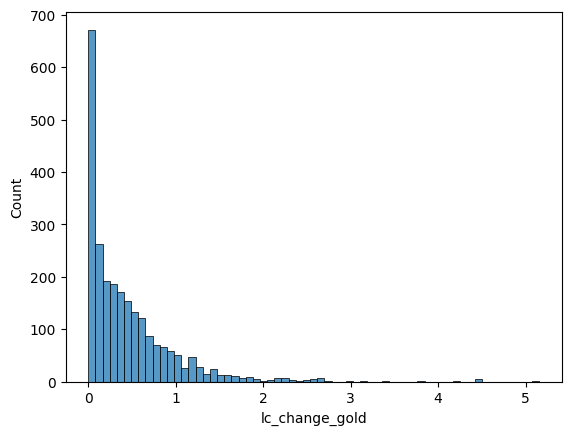

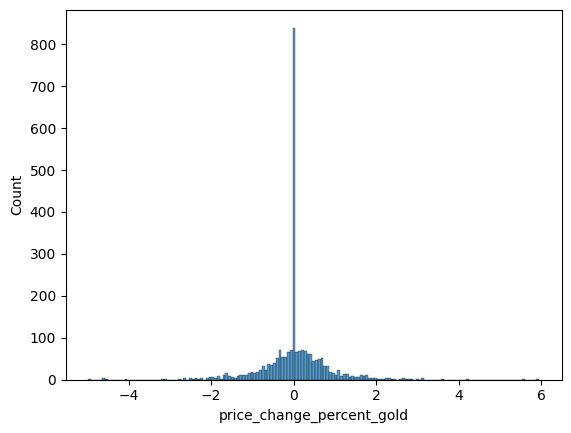

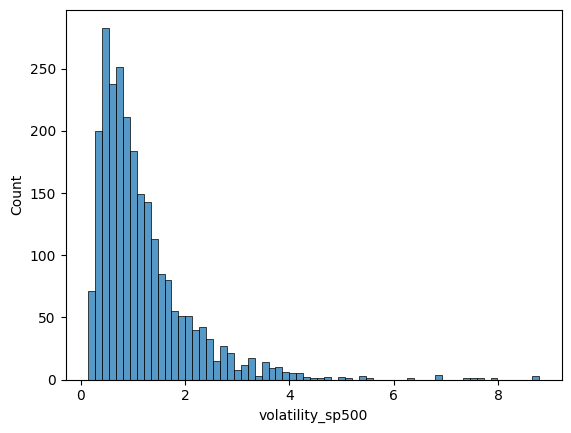

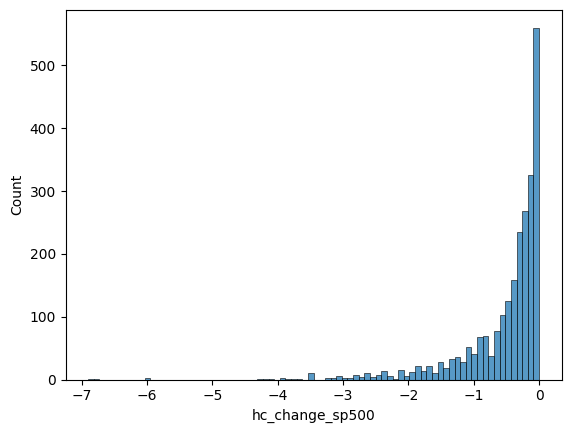

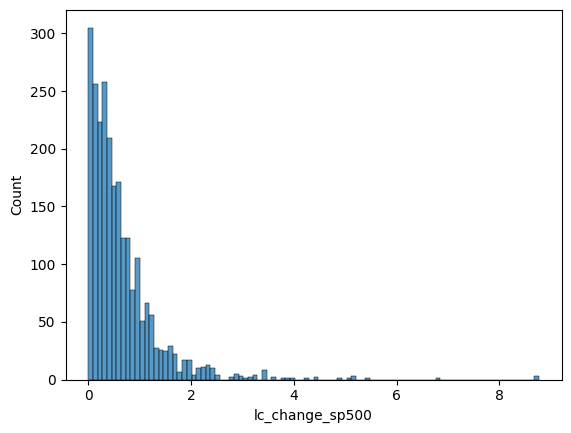

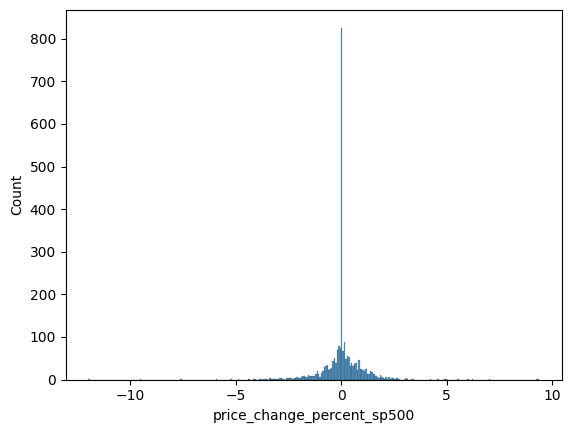

In [52]:
# plot all distirubution to indentify variables with massive outliers and screwed distributions

for i in range(cols.shape[0]):
    sns.histplot(data_aug.loc[:,cols[i]])
    plt.show()

In [53]:
log_norms = ['Open_btc','High_btc','Low_btc','Close_btc','Adj Close_btc','Volume_btc',
            'Volume_oil','Volume_gold','Volume_sp500','SMA_5_btc','WMA_5_btc','KAMA_5_btc',
             'volatility_btc','lc_change_btc','lc_change_gold',
            'volatility_gold','volatility_sp500','lc_change_sp500','next_close']

non_scalables = ['Date','Weekday','target_class','High_trading_volume_gold',
                'Low_trading_volume_oil','rTrend_5']


data_transformed = log_norm_scale(data_aug, log_norms=log_norms,scaler=True, non_scalables=non_scalables)

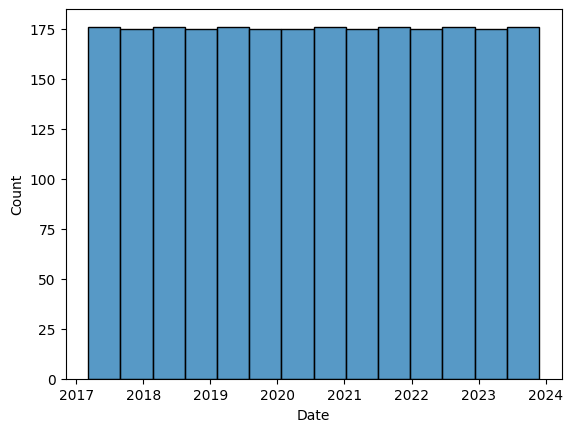

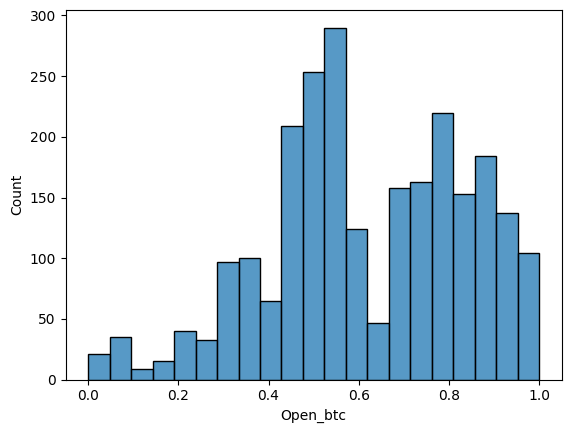

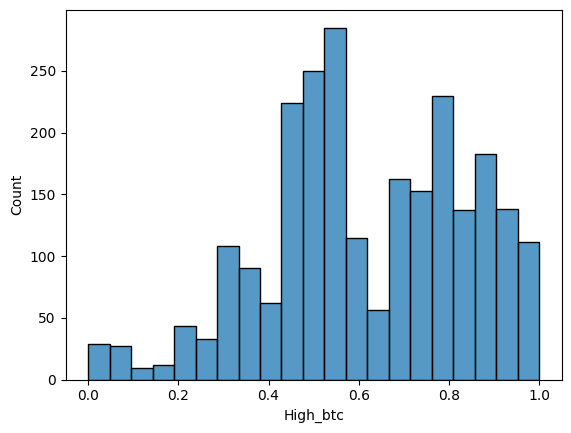

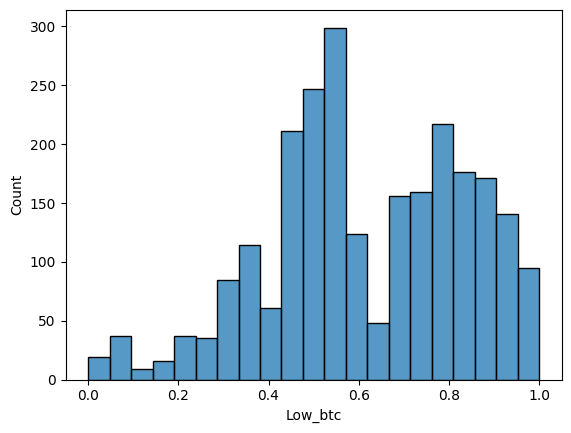

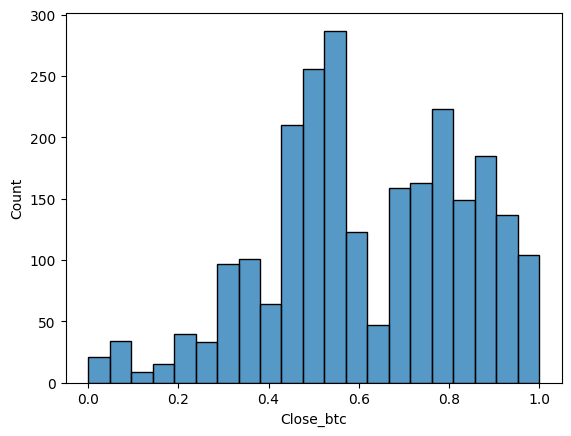

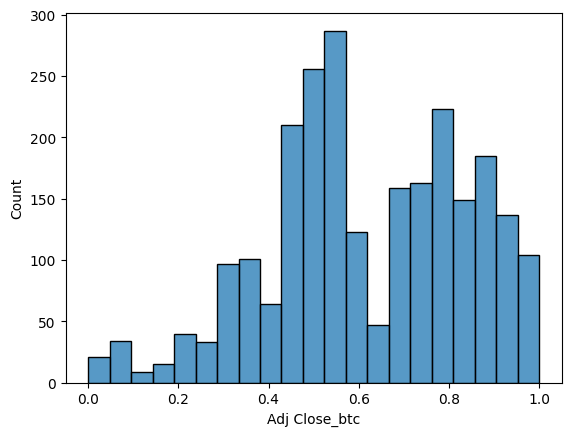

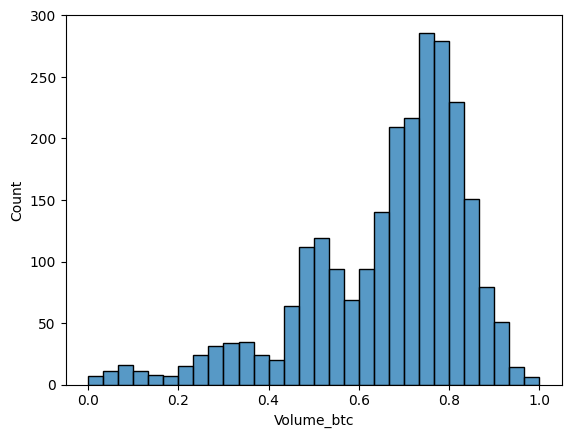

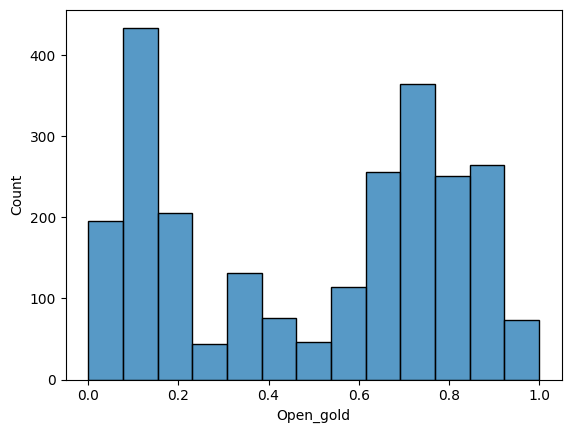

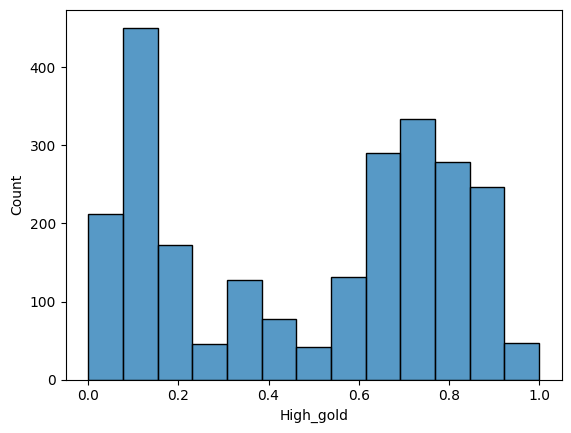

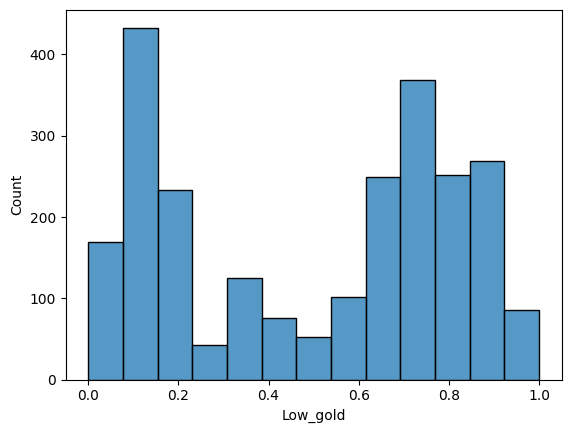

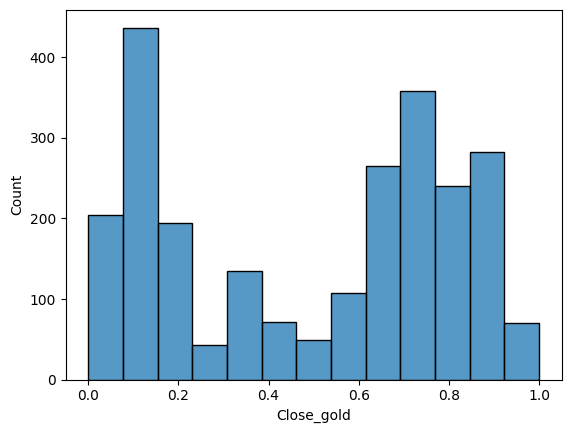

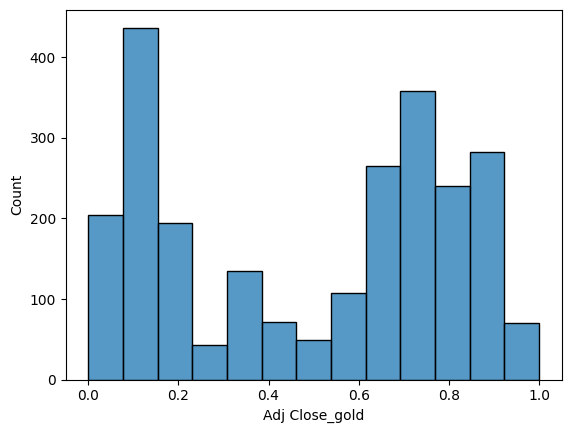

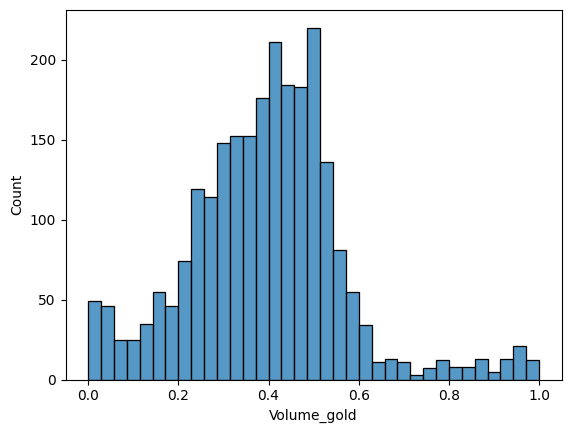

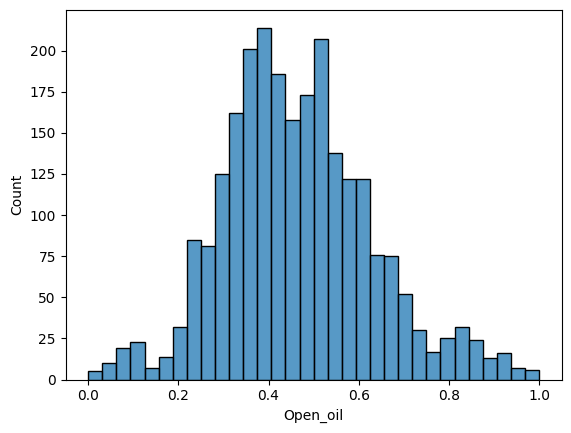

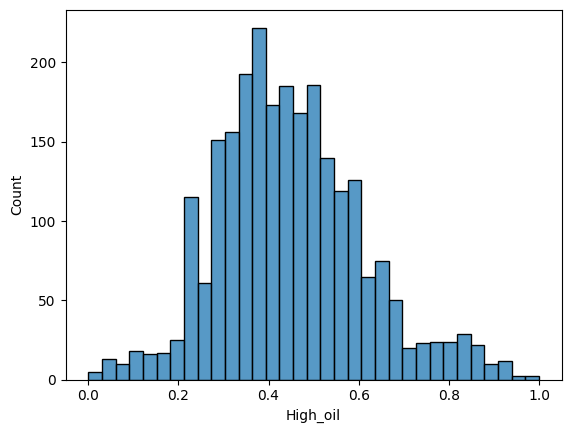

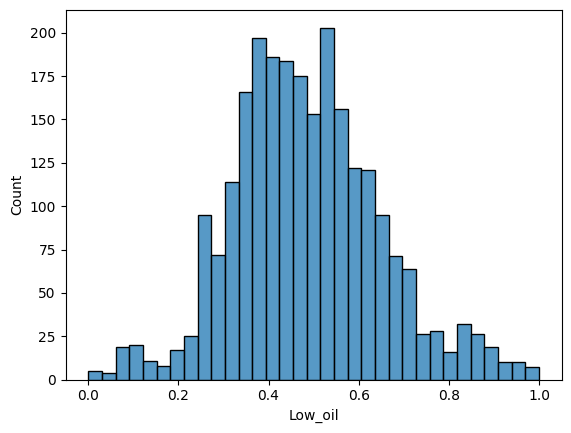

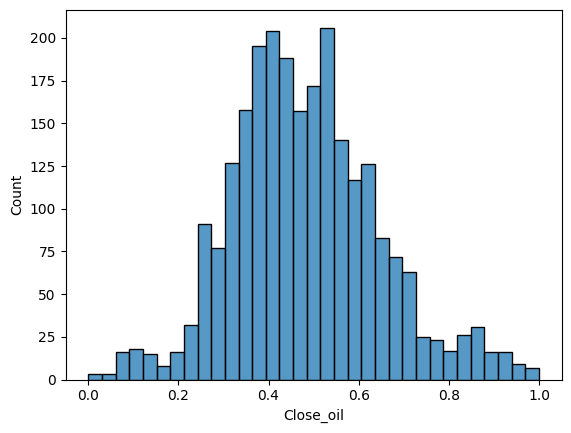

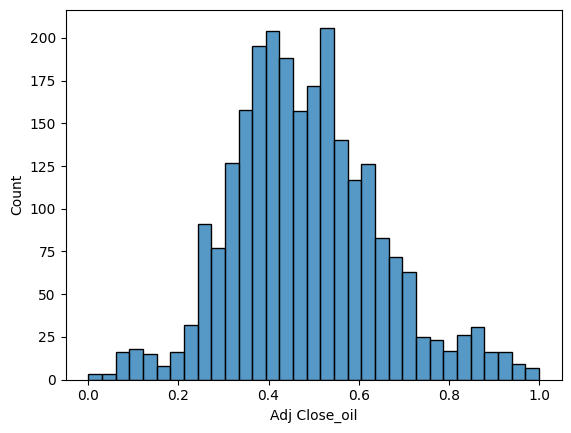

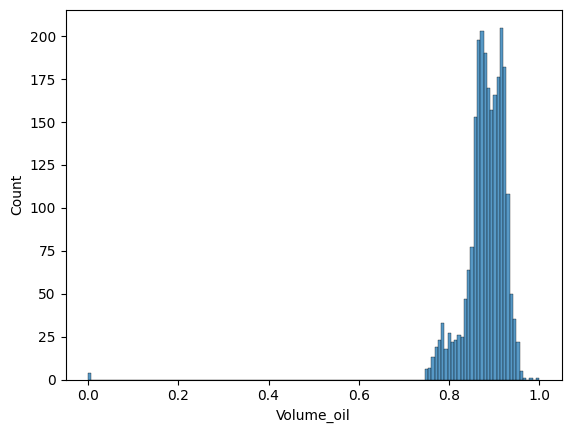

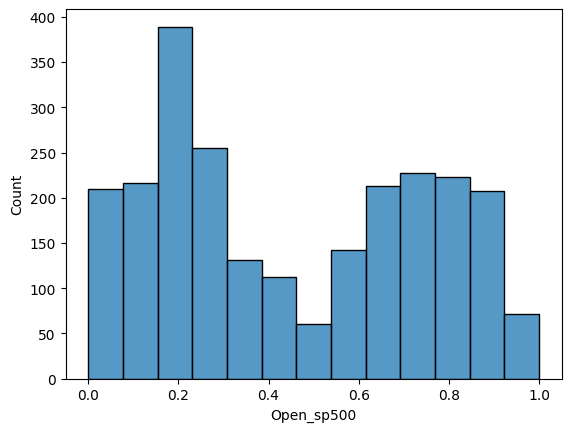

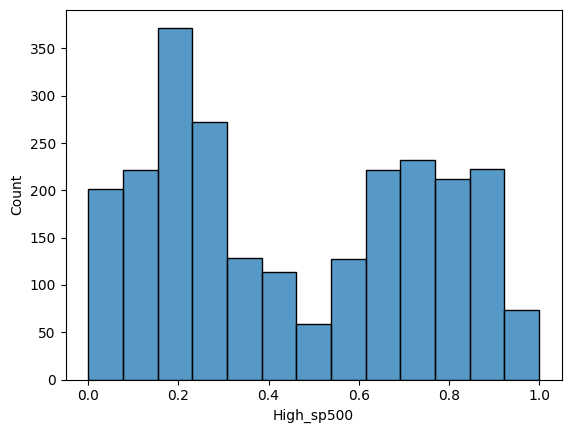

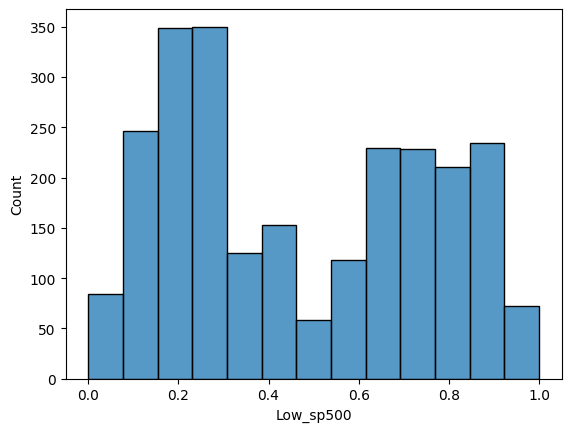

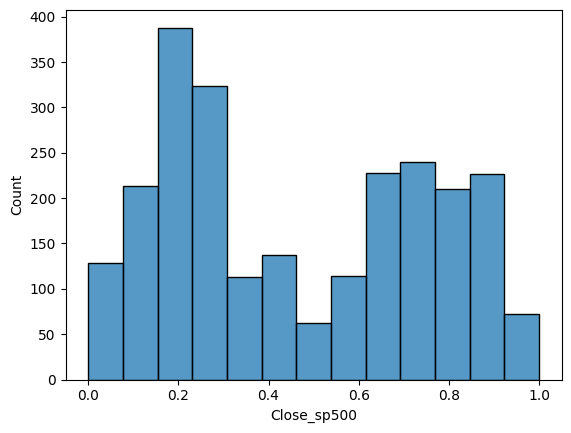

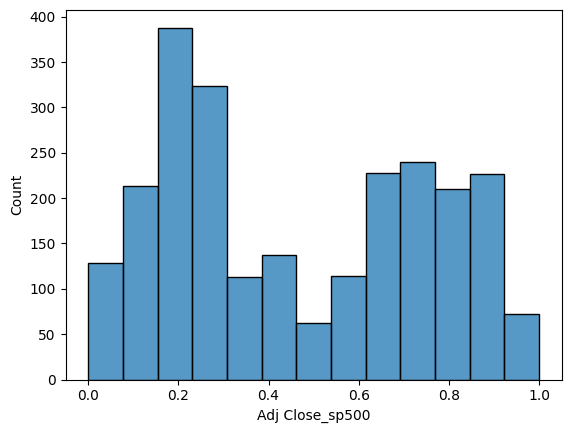

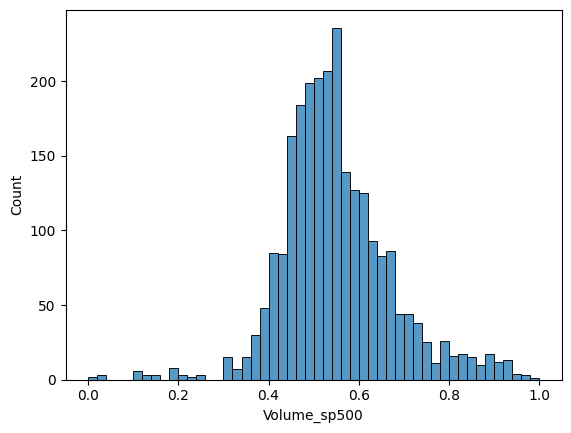

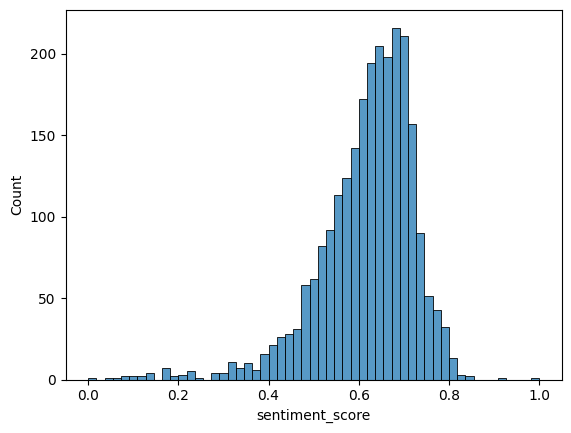

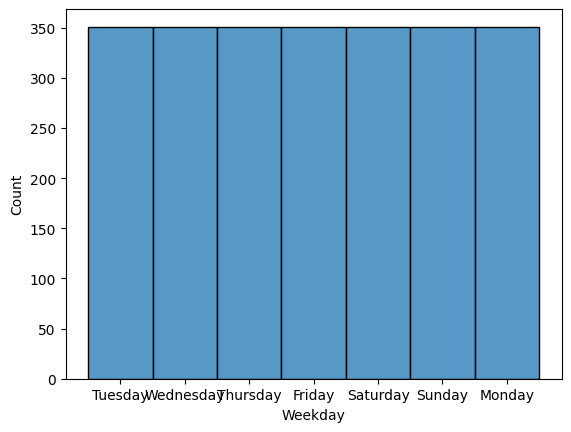

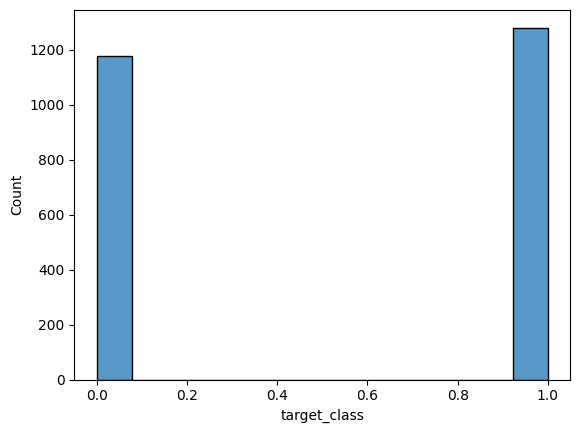

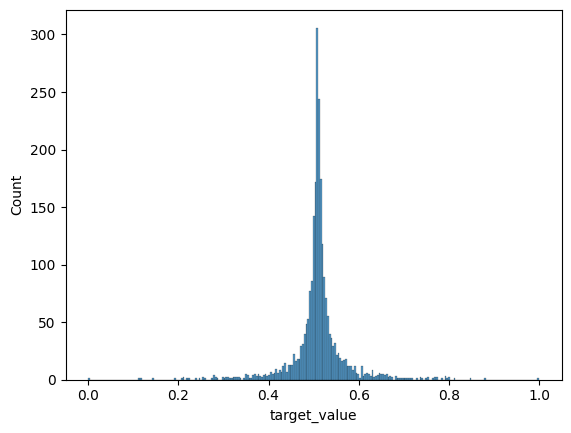

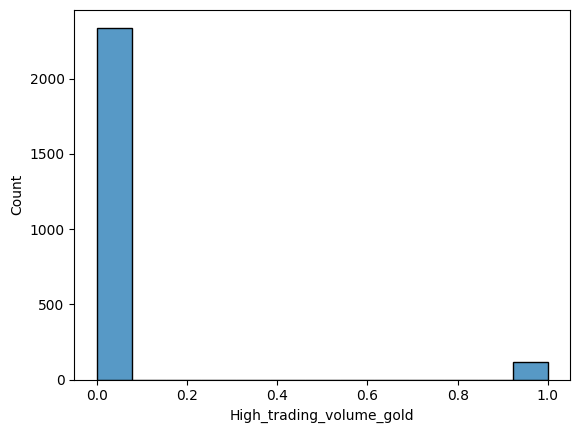

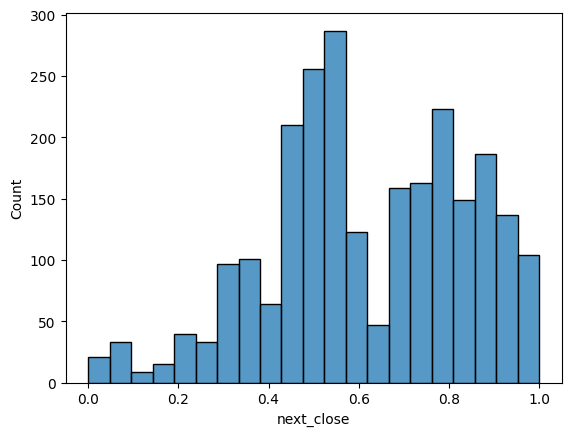

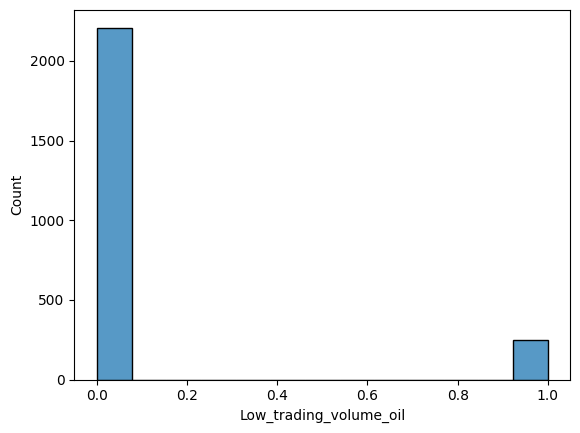

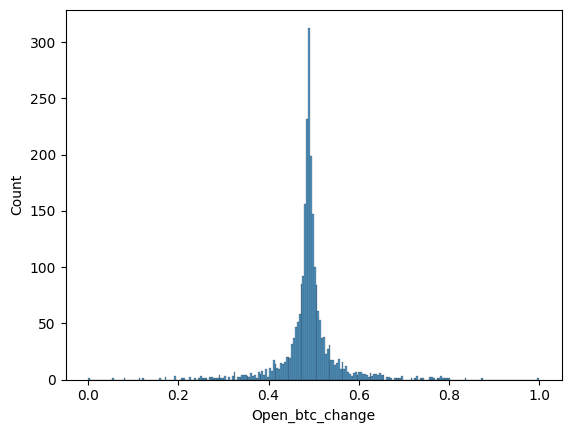

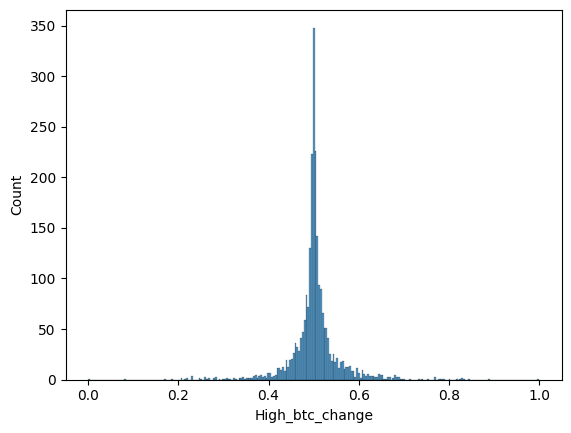

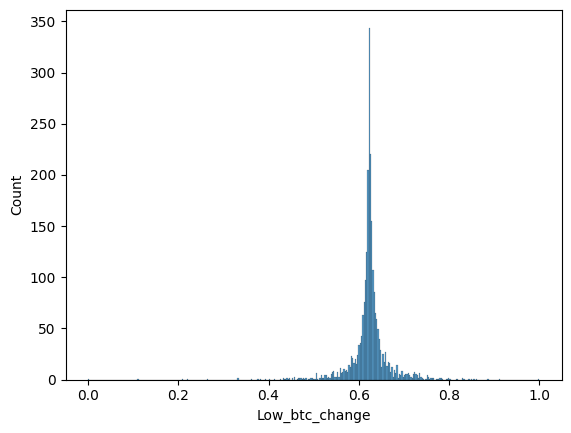

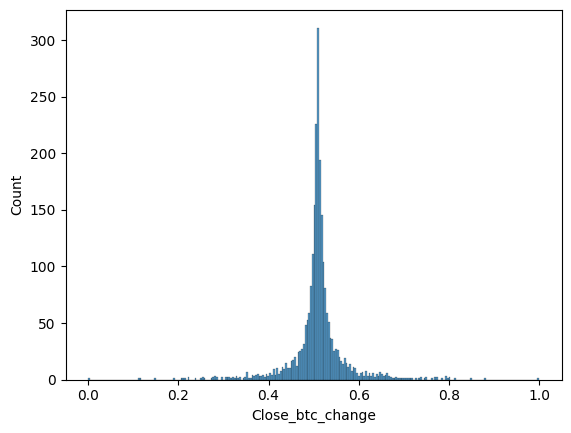

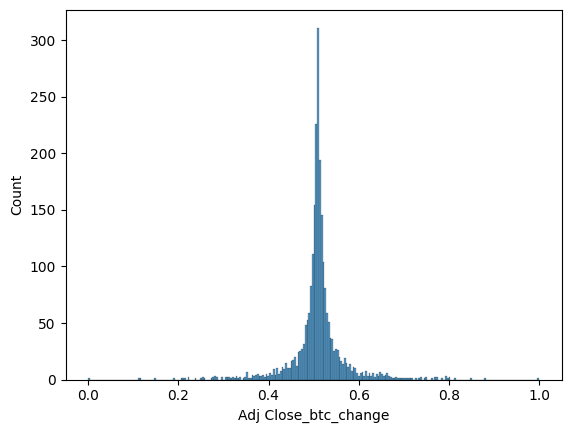

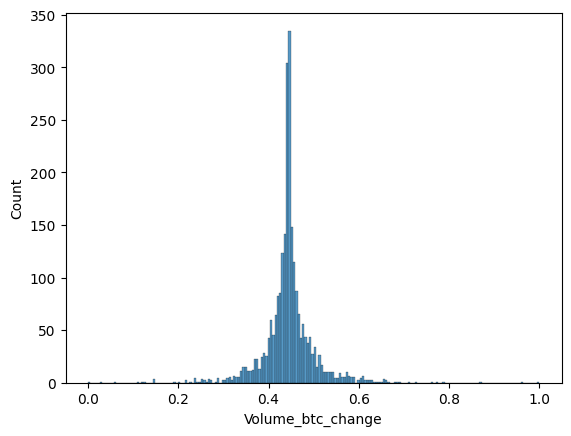

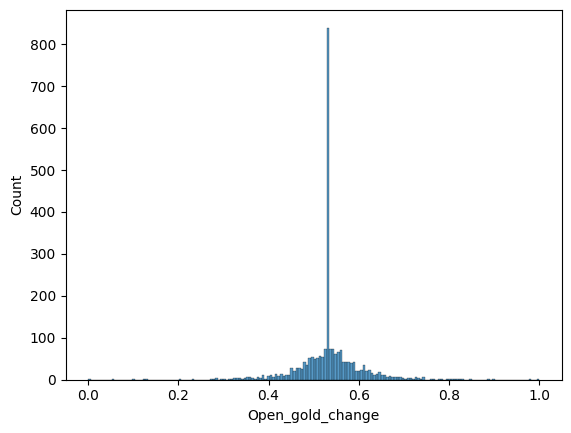

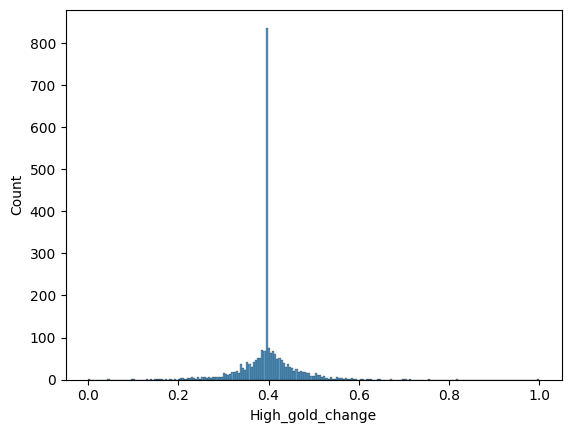

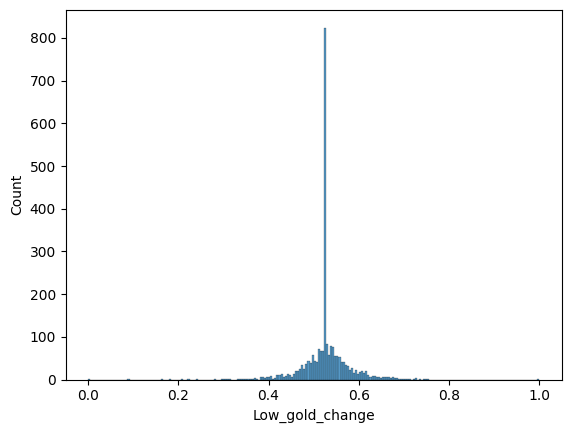

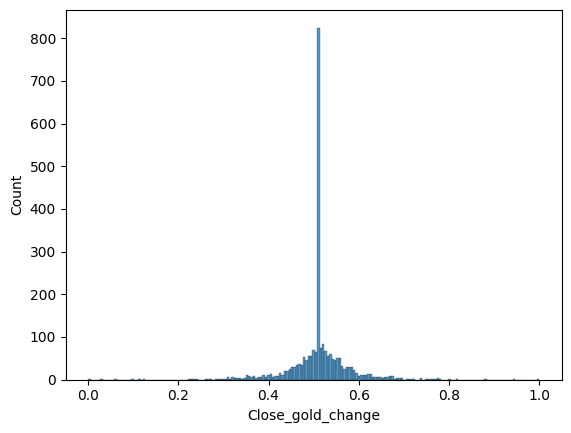

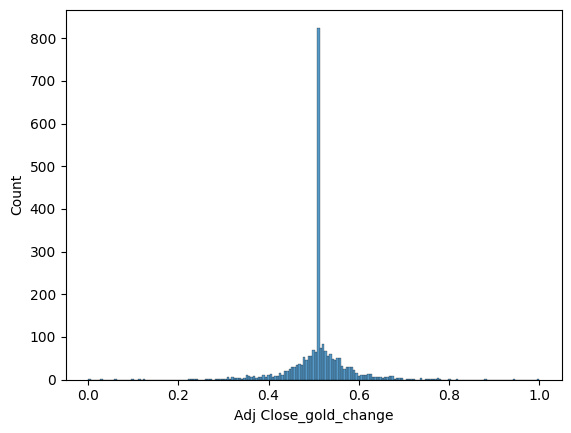

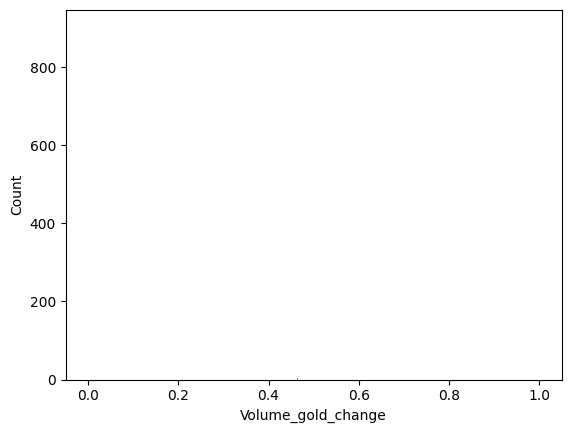

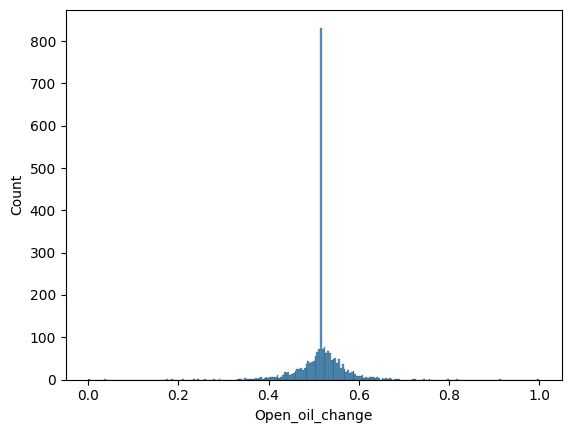

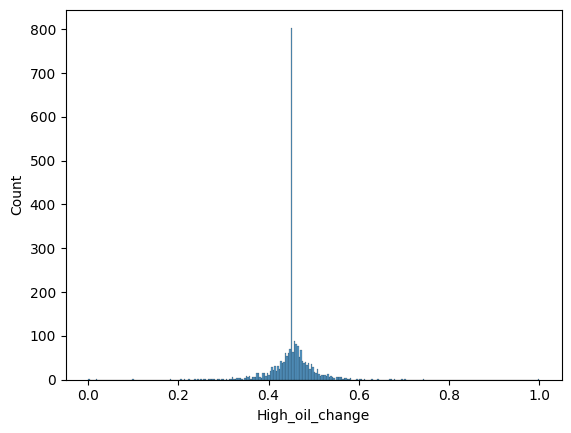

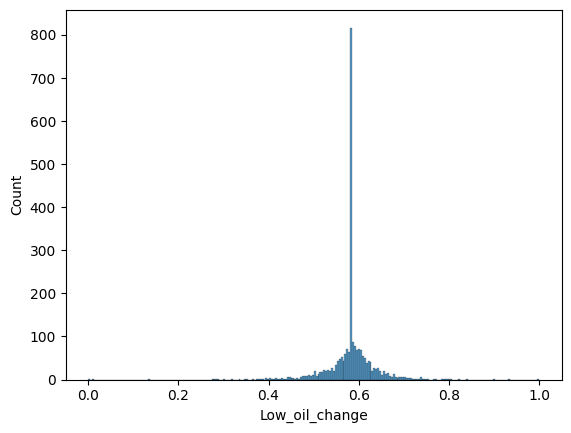

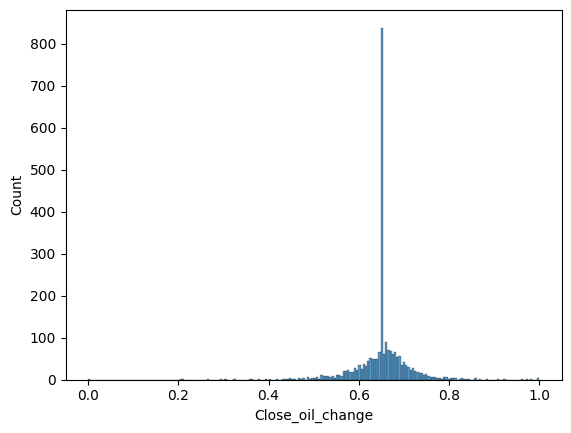

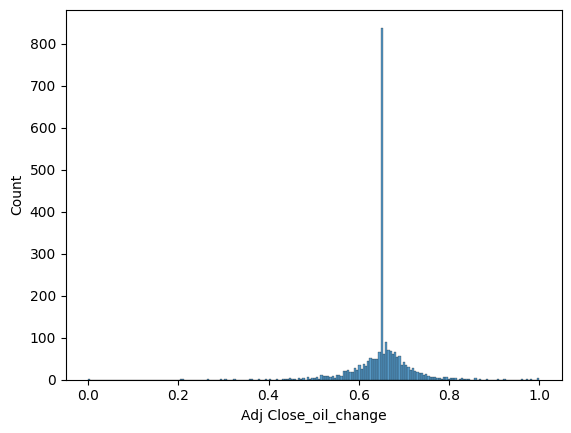

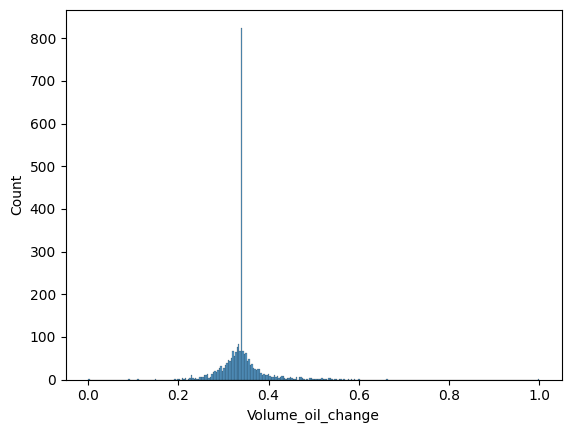

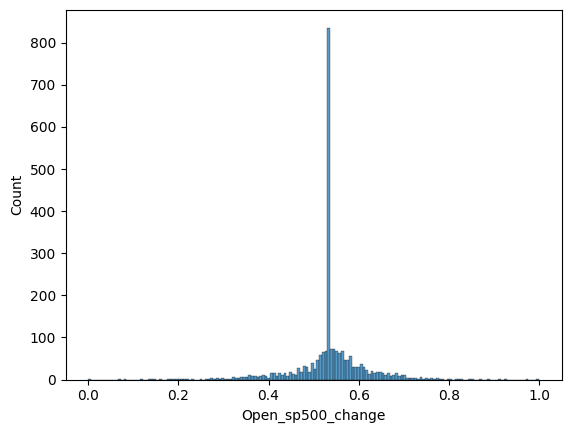

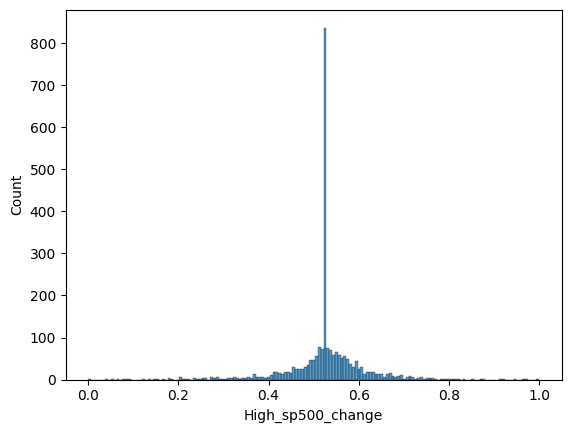

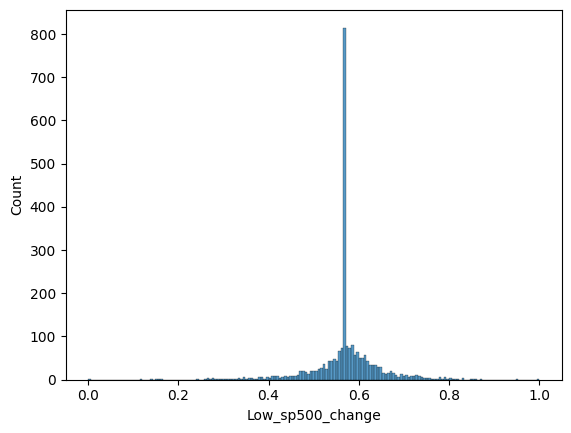

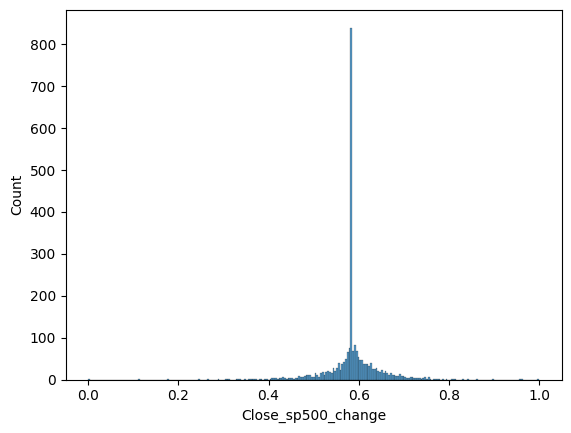

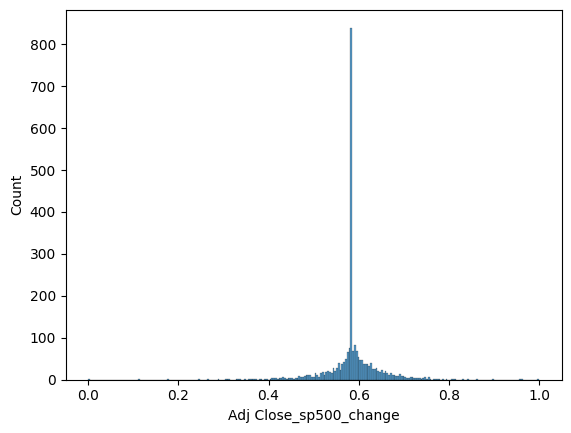

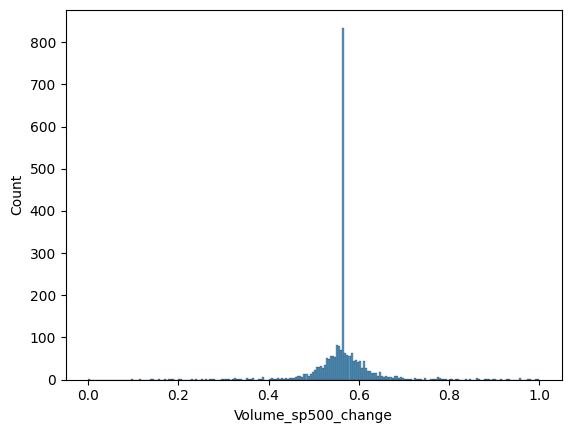

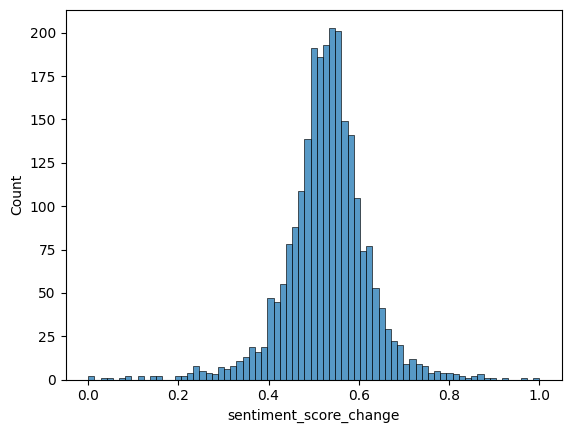

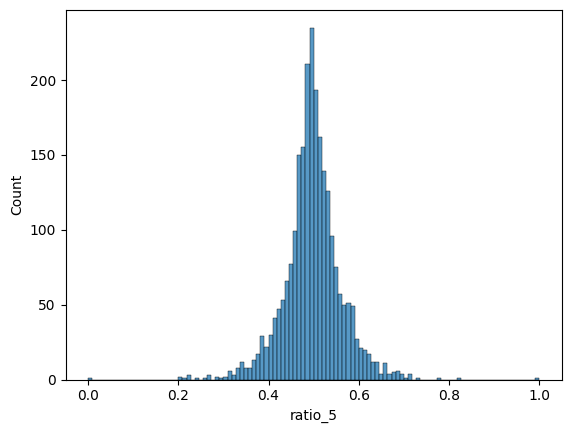

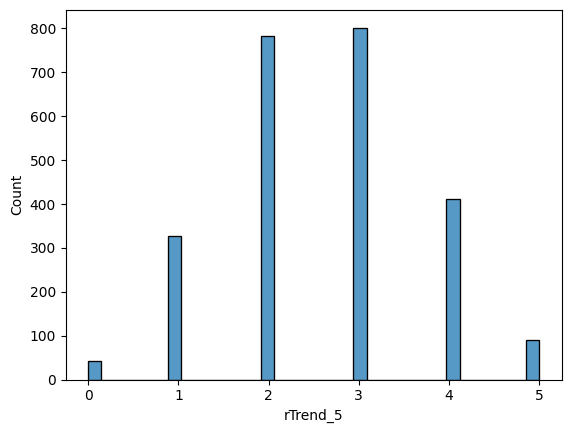

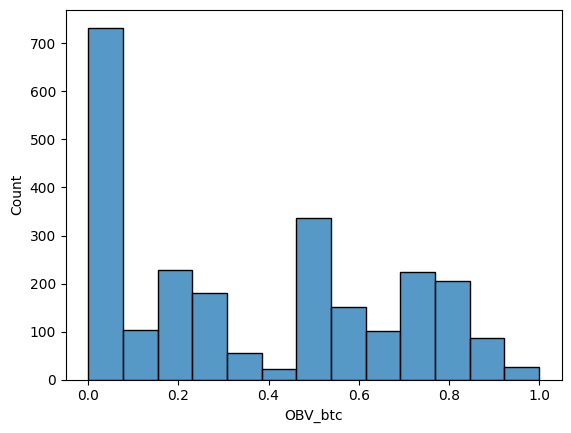

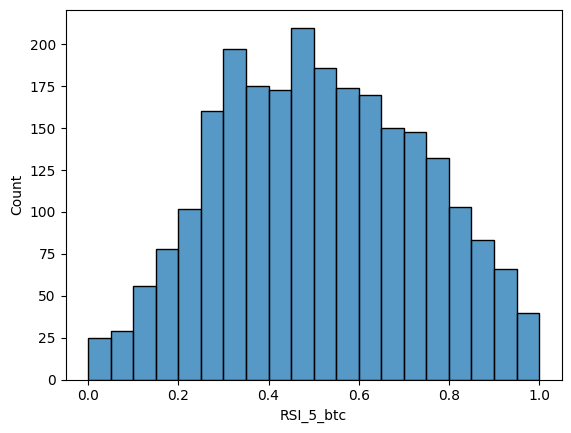

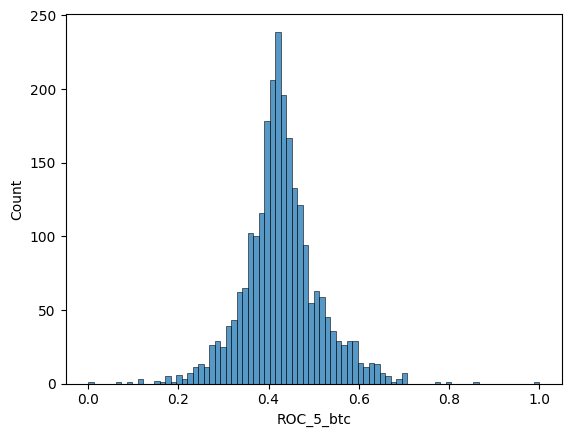

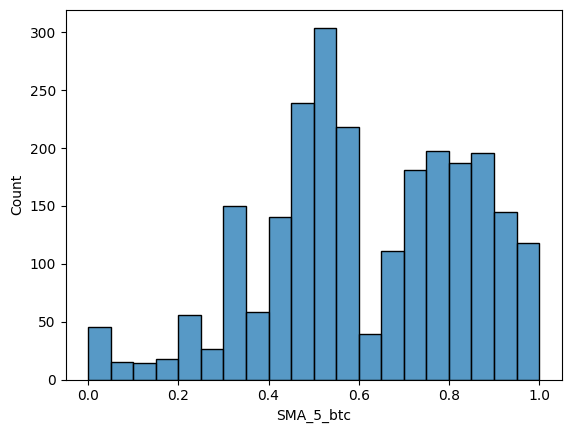

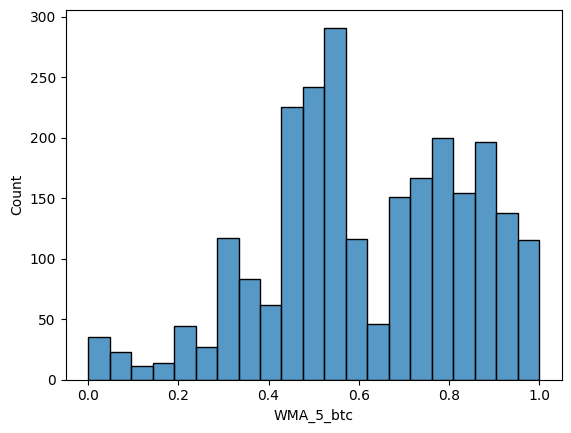

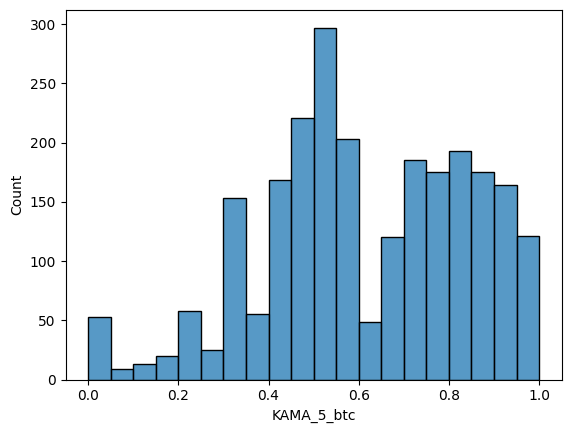

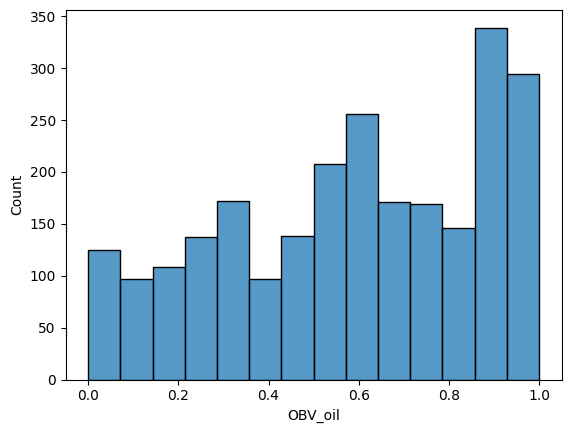

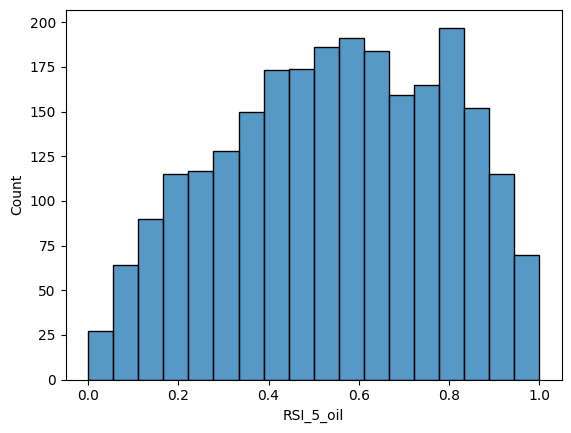

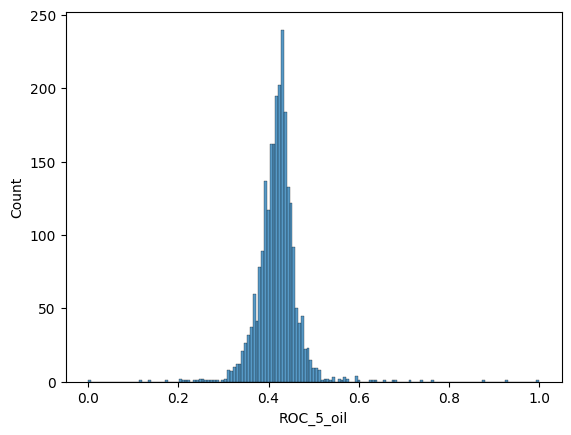

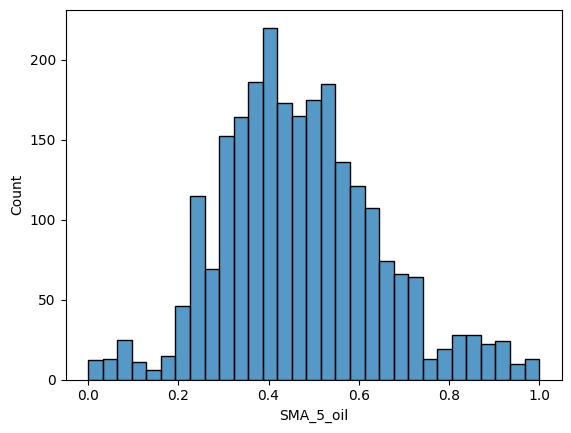

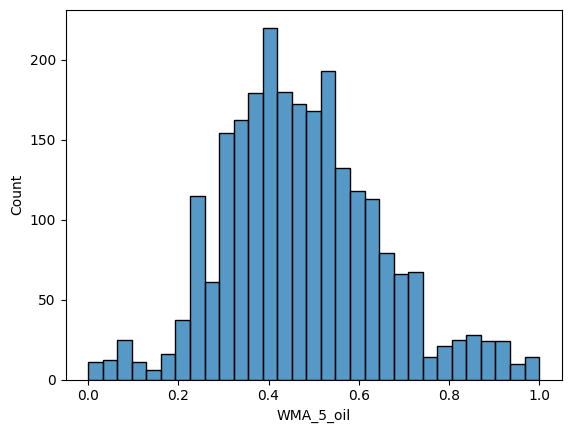

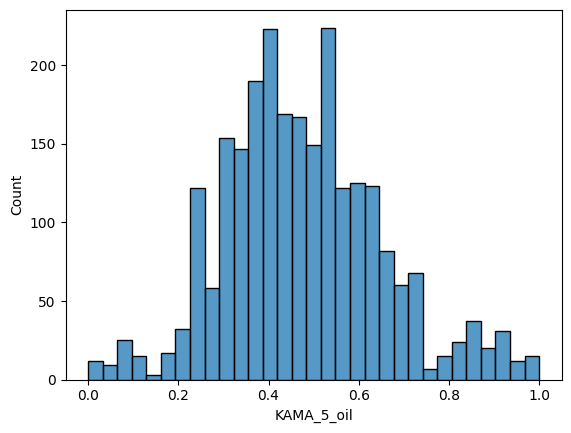

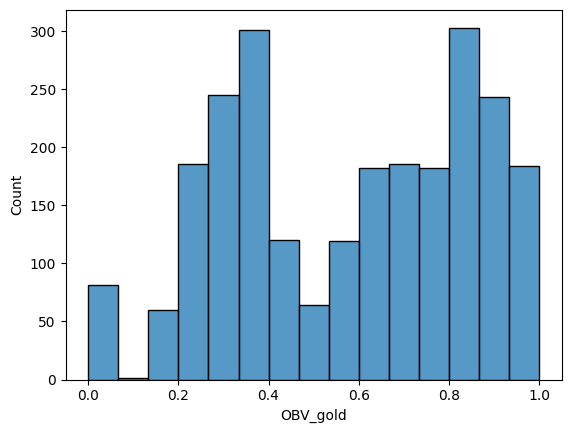

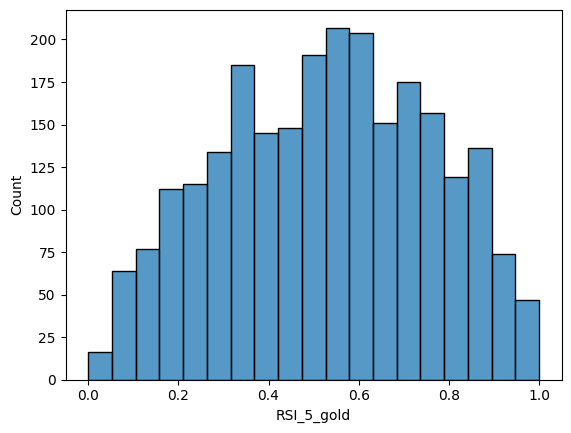

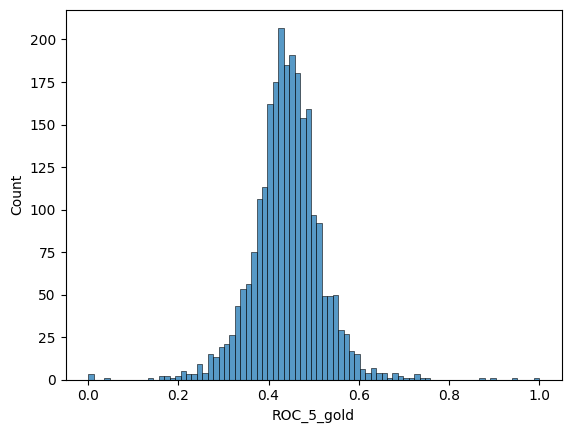

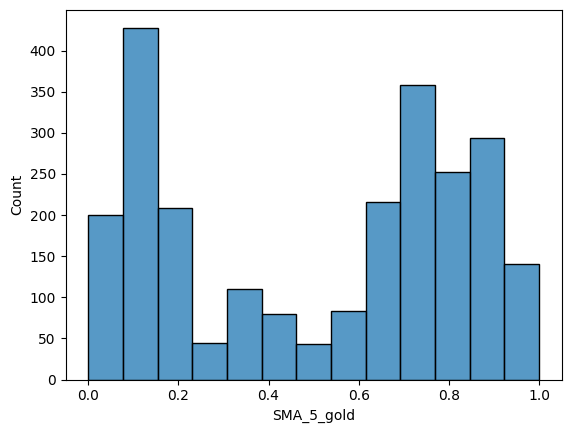

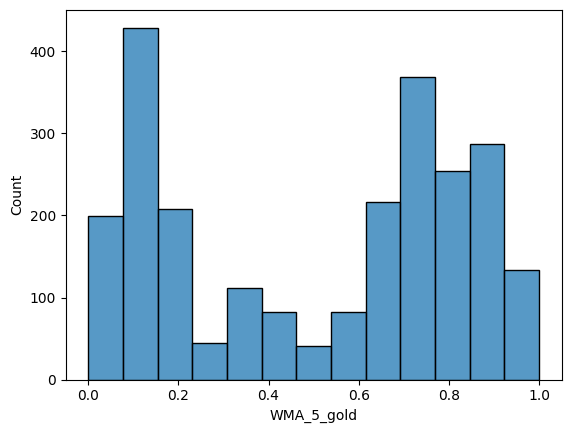

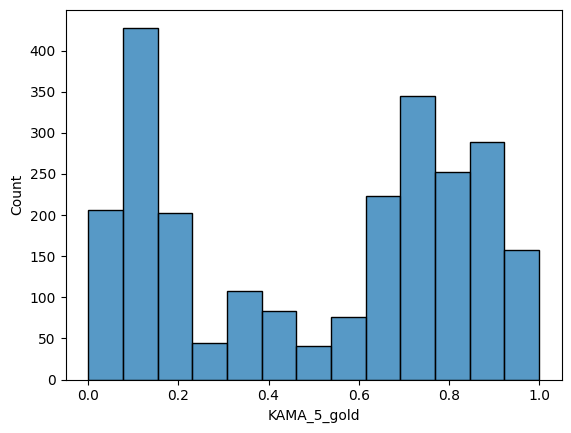

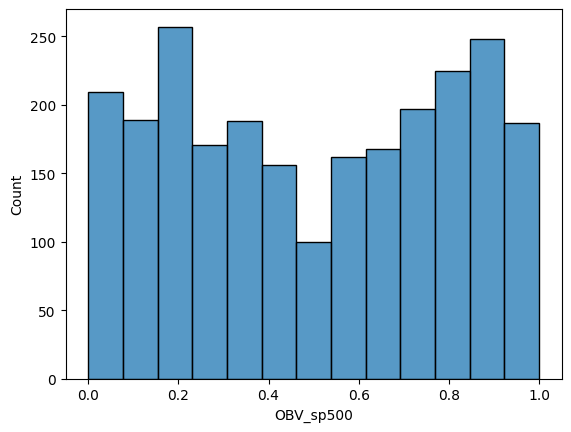

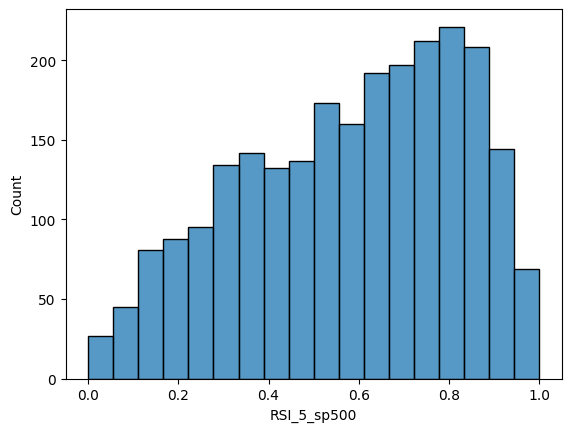

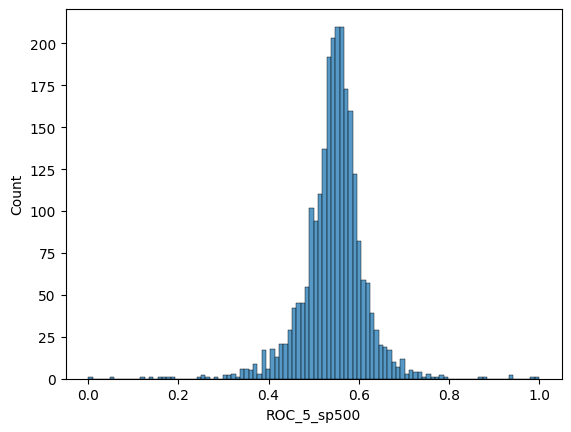

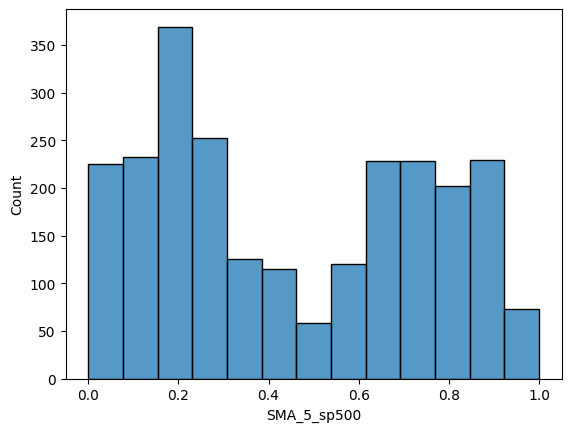

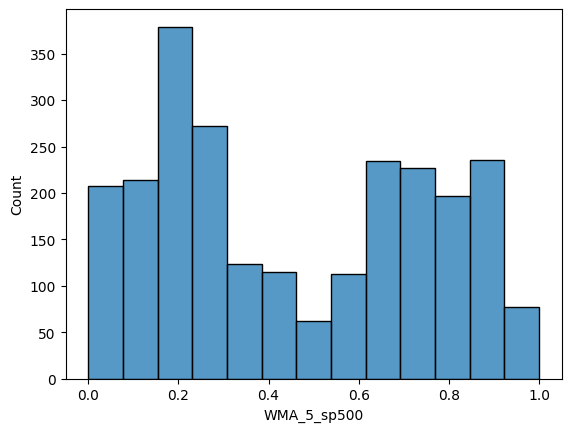

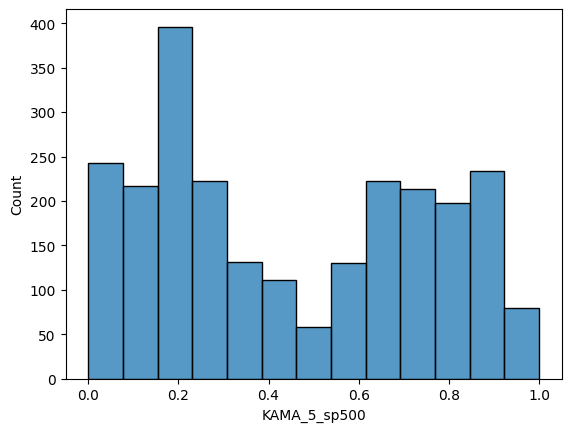

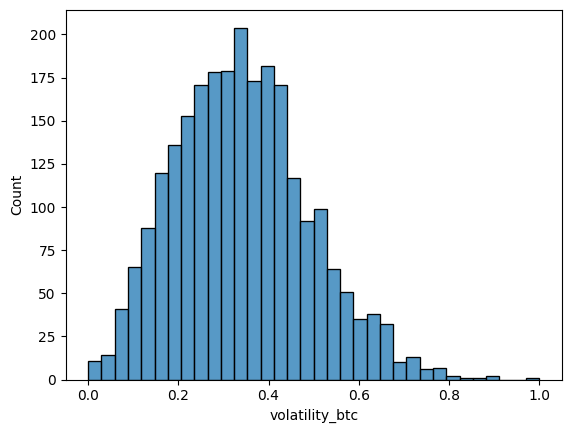

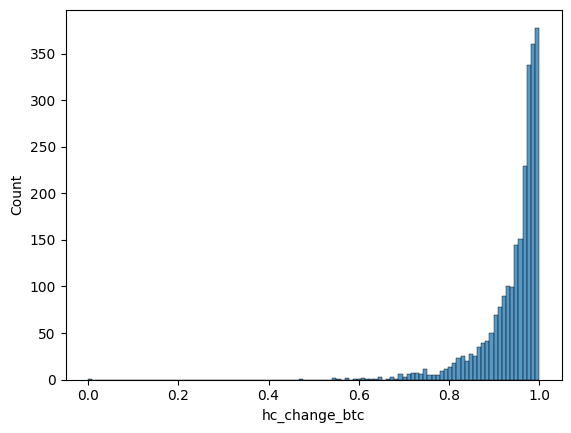

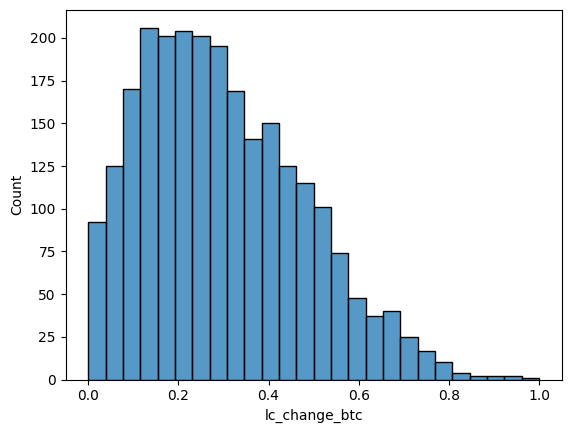

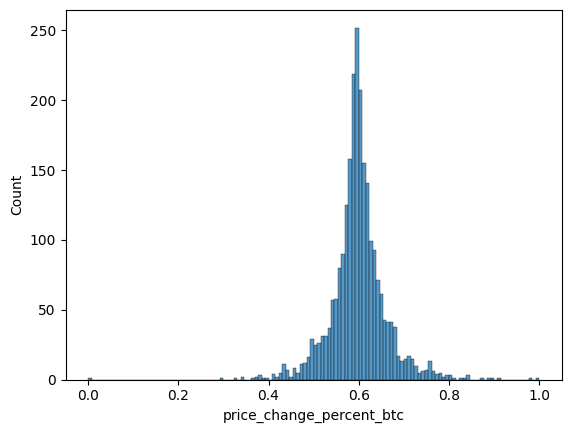

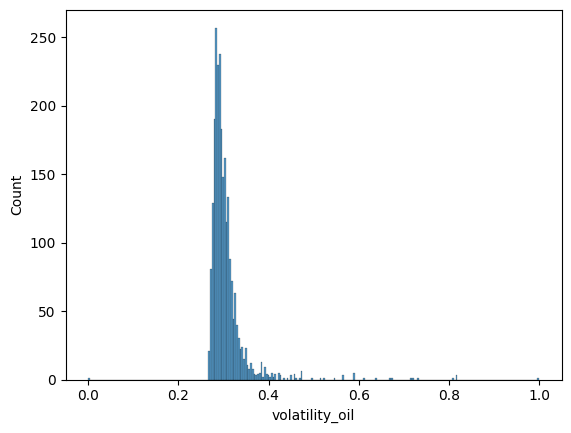

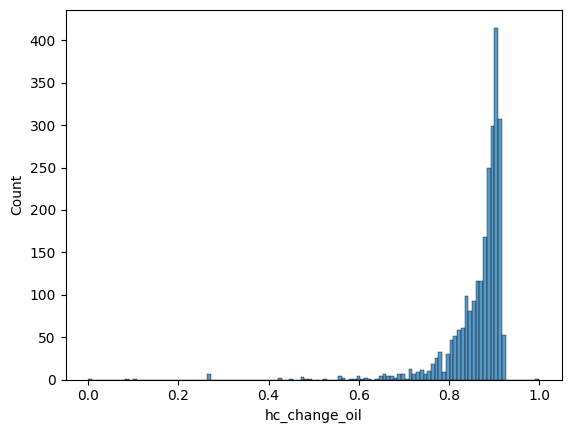

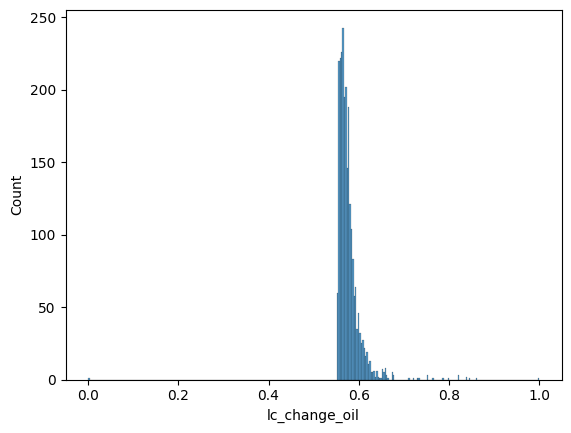

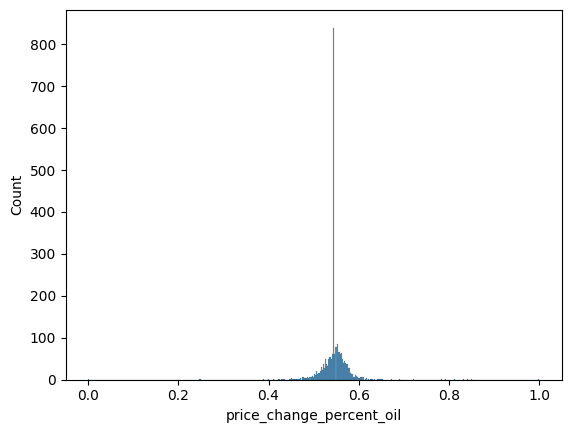

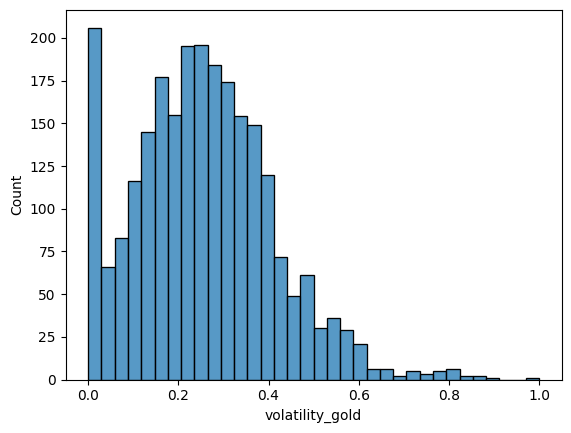

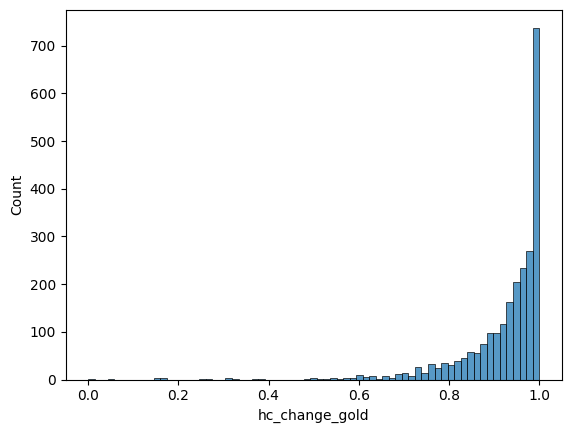

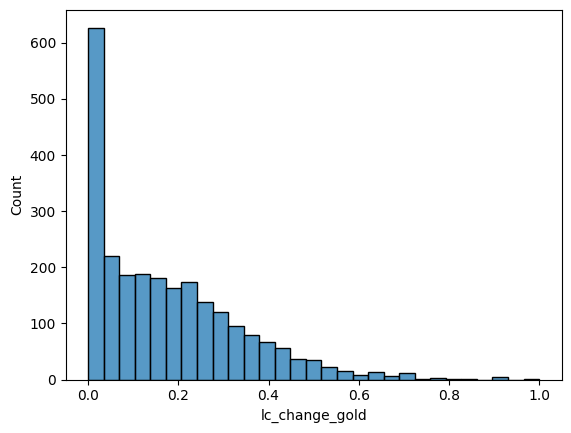

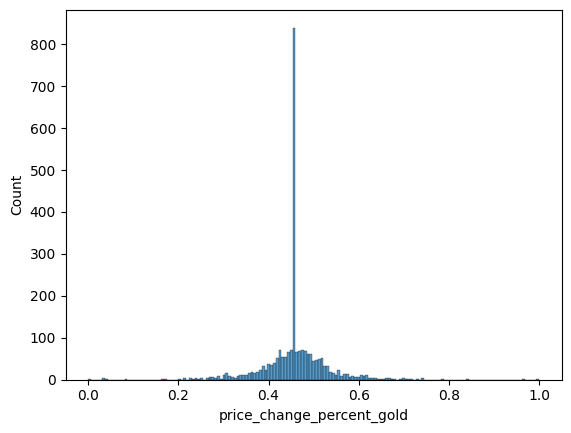

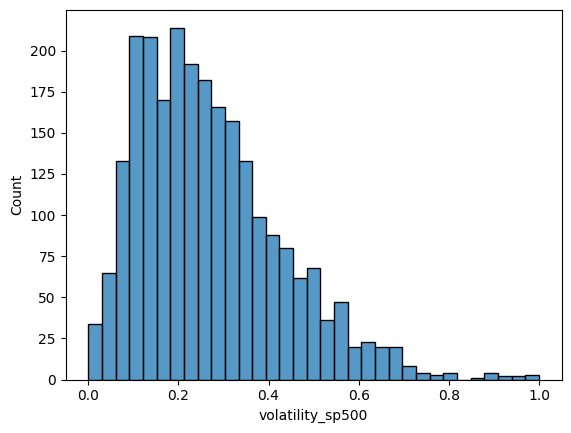

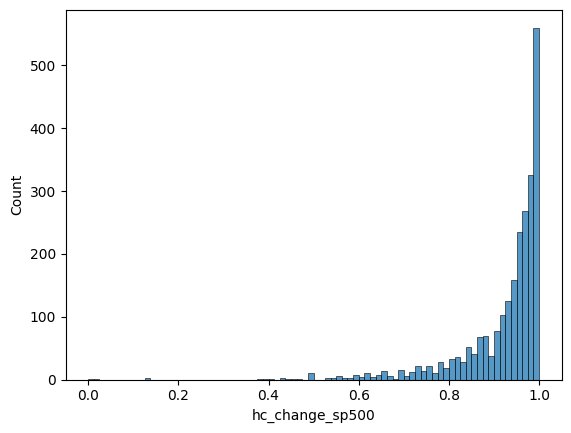

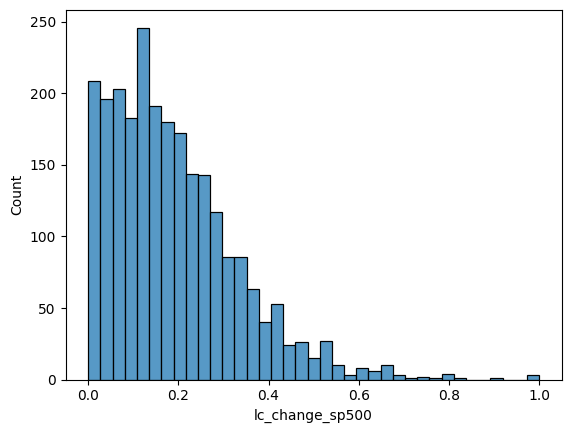

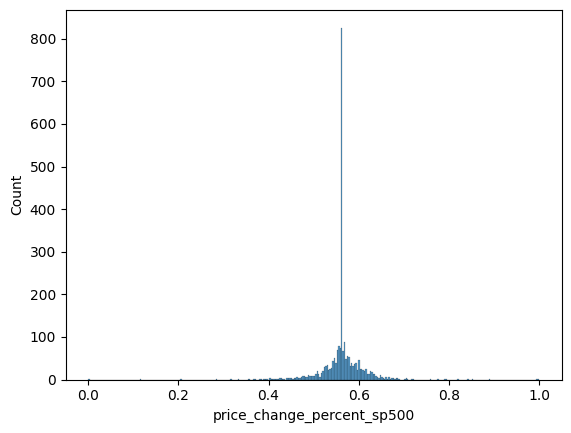

In [54]:
for i in range(cols.shape[0]):
    sns.histplot(data_transformed.loc[:,cols[i]])
    plt.show()

In [55]:
data_transformed.to_csv('data/btc_gold_oil_sp500_sentiment_clean_transformed.csv')

In [63]:
numerical_data = data_transformed.select_dtypes(include=['number'])

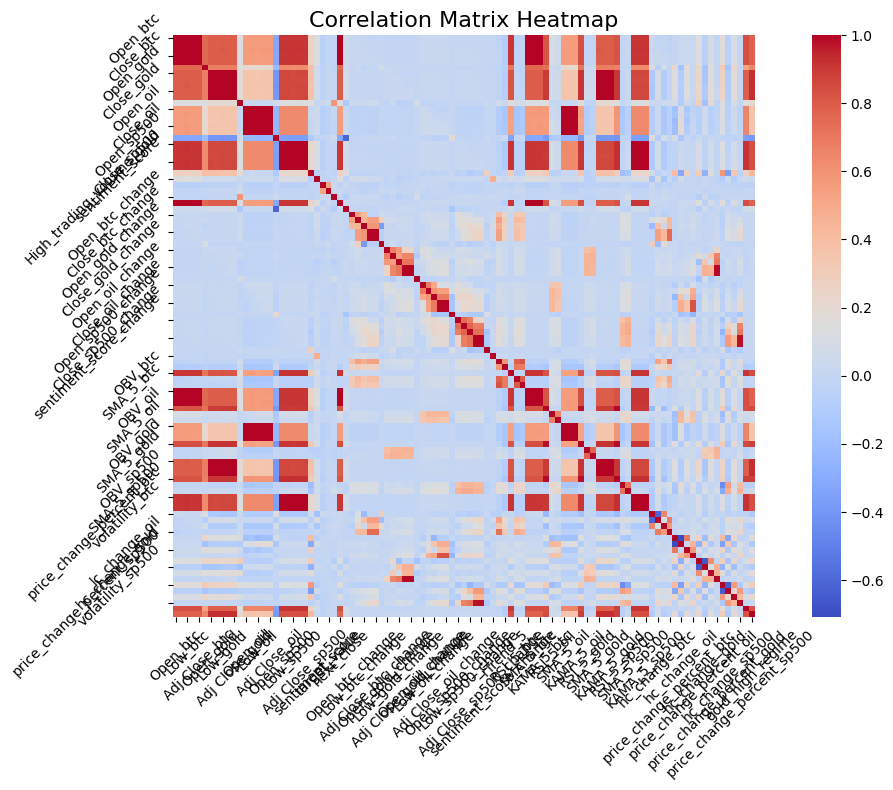

In [64]:
# Assuming 'data_aug' is your DataFrame
correlation_matrix = numerical_data.corr()


plt.figure(figsize=(12, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, cbar=True)

# Customize the title and labels
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()

/var/folders/bh/cksbyqqj7vg311k79hl0wrs00000gn/T/ipykernel_6756/4213624430.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/bh/cksbyqqj7vg311k79hl0wrs00000gn/T/ipykernel_6756/4213624430.py:9: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


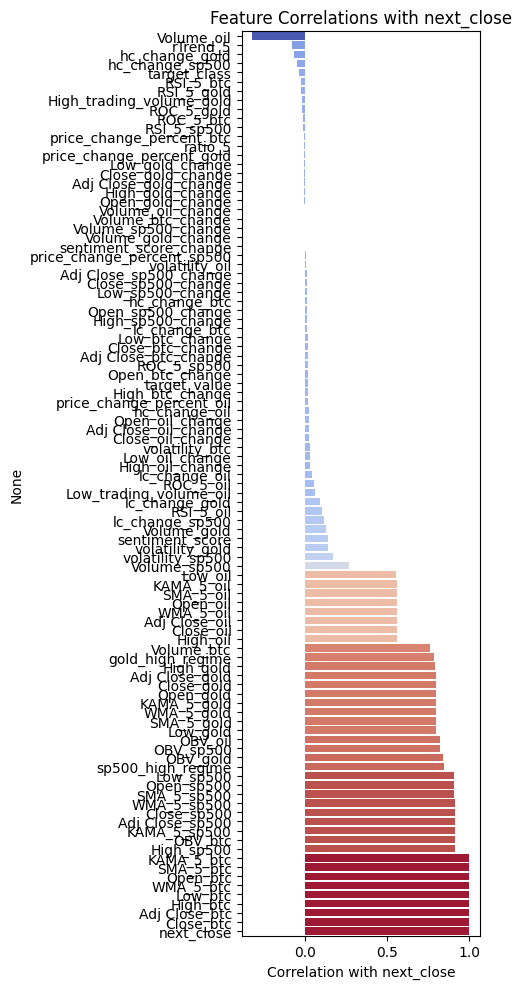

In [65]:
sorted_values = correlation_matrix.loc['next_close'].sort_values()

# Normalize values for color mapping (from blue to red)
norm = plt.Normalize(sorted_values.min(), sorted_values.max())
colors = plt.cm.coolwarm(norm(sorted_values.values))

# Create a horizontal bar plot
plt.figure(figsize=(5, 10))
sns.barplot(
    x=sorted_values.values,
    y=sorted_values.index,
    palette=colors
)
plt.xlabel('Correlation with next_close')
plt.title('Feature Correlations with next_close')
plt.tight_layout()
plt.show()

/var/folders/bh/cksbyqqj7vg311k79hl0wrs00000gn/T/ipykernel_6756/3214666178.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/bh/cksbyqqj7vg311k79hl0wrs00000gn/T/ipykernel_6756/3214666178.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


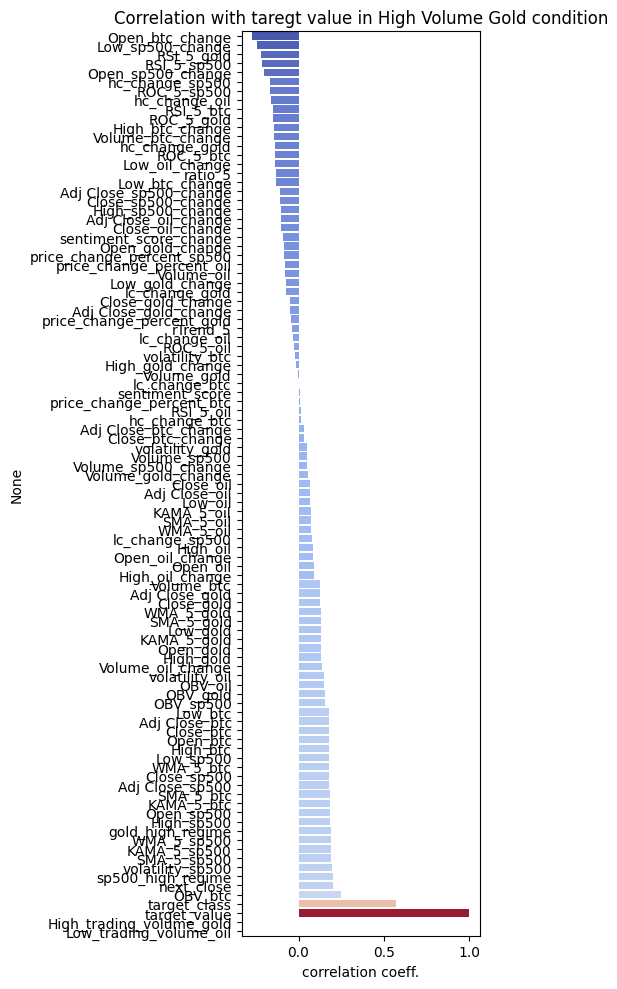

In [66]:
correlation_matrix = numerical_data.loc[numerical_data.High_trading_volume_gold==1].corr()
sorted_values = correlation_matrix.loc['target_value'].sort_values()

# Normalize values for color mapping (from blue to red)
norm = plt.Normalize(sorted_values.min(), sorted_values.max())
colors = plt.cm.coolwarm(norm(sorted_values.values))

# Create a horizontal bar plot
plt.figure(figsize=(5, 10))
sns.barplot(
    x=sorted_values.values,
    y=sorted_values.index,
    palette=colors
)

plt.xlabel('correlation coeff.')
plt.title('Correlation with taregt value in High Volume Gold condition')
plt.tight_layout()
plt.show()

/var/folders/bh/cksbyqqj7vg311k79hl0wrs00000gn/T/ipykernel_6756/1958134411.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/bh/cksbyqqj7vg311k79hl0wrs00000gn/T/ipykernel_6756/1958134411.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


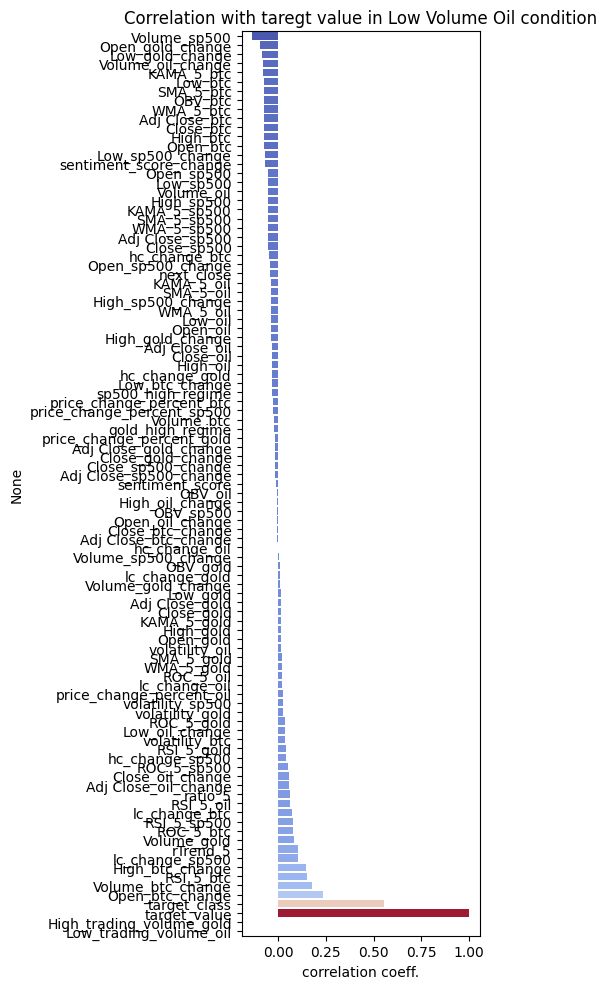

In [67]:
correlation_matrix = numerical_data.loc[numerical_data.Low_trading_volume_oil==1].corr()
sorted_values = correlation_matrix.loc['target_value'].sort_values()

# Normalize values for color mapping (from blue to red)
norm = plt.Normalize(sorted_values.min(), sorted_values.max())
colors = plt.cm.coolwarm(norm(sorted_values.values))

# Create a horizontal bar plot
plt.figure(figsize=(5, 10))
sns.barplot(
    x=sorted_values.values,
    y=sorted_values.index,
    palette=colors
)

plt.xlabel('correlation coeff.')
plt.title('Correlation with taregt value in Low Volume Oil condition')
plt.tight_layout()
plt.show()

<Axes: xlabel='OBV_btc', ylabel='target_value'>

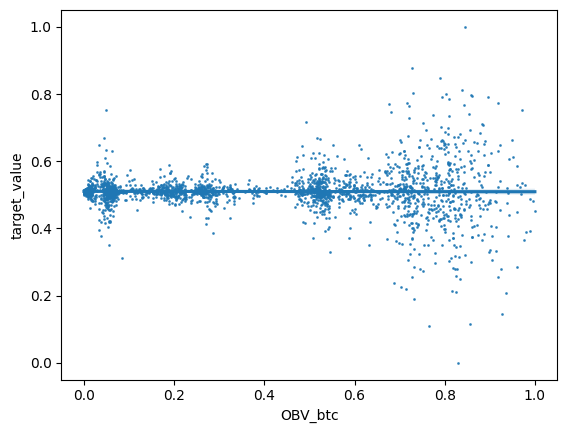

In [81]:
sns.regplot(data=numerical_data,
            y='target_value',
            x='OBV_btc',
            scatter_kws={'s':1})

/var/folders/bh/cksbyqqj7vg311k79hl0wrs00000gn/T/ipykernel_6756/2793170929.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/bh/cksbyqqj7vg311k79hl0wrs00000gn/T/ipykernel_6756/2793170929.py:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


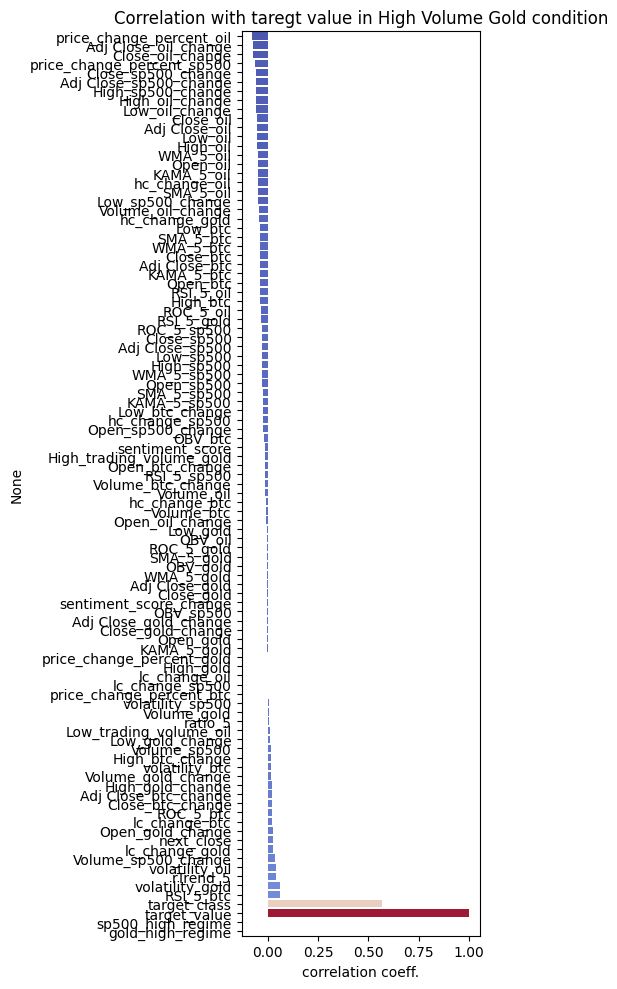

In [84]:
correlation_matrix = numerical_data.loc[numerical_data.gold_high_regime==0].corr()
sorted_values = correlation_matrix.loc['target_value'].sort_values()

# Normalize values for color mapping (from blue to red)
norm = plt.Normalize(sorted_values.min(), sorted_values.max())
colors = plt.cm.coolwarm(norm(sorted_values.values))

# Create a horizontal bar plot
plt.figure(figsize=(5, 10))
sns.barplot(
    x=sorted_values.values,
    y=sorted_values.index,
    palette=colors
)

plt.xlabel('correlation coeff.')
plt.title('Correlation with taregt value in High Volume Gold condition')
plt.tight_layout()
plt.show()

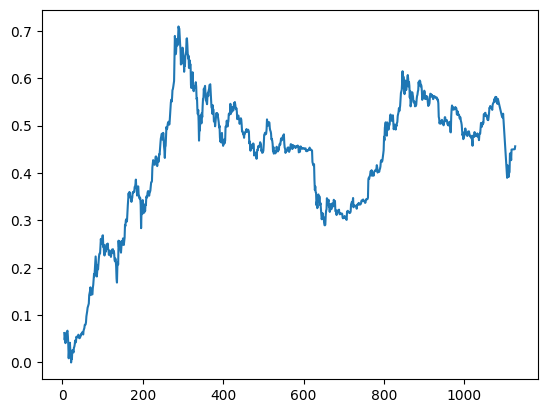

In [90]:
plt.plot(numerical_data.loc[numerical_data.gold_high_regime==0].index,
numerical_data.loc[numerical_data.gold_high_regime==0,'Close_btc'])

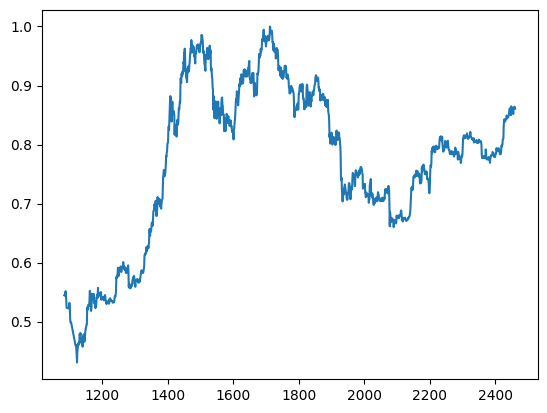

In [91]:
plt.plot(numerical_data.loc[numerical_data.gold_high_regime==1].index,
numerical_data.loc[numerical_data.gold_high_regime==1,'Close_btc'])